In [ ]:
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import date
import os

#with open('nodes_for_category.pkl', 'wb') as f:
#    pickle.dump(nodes_for_category, f)
#with open('category_for_node.pkl', 'rb') as f:
#    category_for_node = pickle.load(f)

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from torch.utils import tensorboard
from torch.utils.tensorboard import SummaryWriter
from torchvision import transforms
from torch.autograd.variable import Variable

from sklearn import model_selection
from sklearn.preprocessing import StandardScaler    
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import confusion_matrix, classification_report

from google.colab import drive
import os.path
drive.mount('/content/drive')

# Hyperparameters
EPOCHS = 100
BATCH_SIZE = 32
LEARNING_RATE = 0.001

# Model
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

dir = '/content/drive/MyDrive/tesi_beatrice/material/dummy_dataset/'

# model_1 = candidate gender
# model_2 = candidate selected
# model_3 = compas gender
# model_4 = compas ethnic code
# model_5 = candidate gender (without disable)
# model_6 = candidate selected (without disable)

Mounted at /content/drive
cpu


### is_pass

In [ ]:
train = pd.read_csv(dir+'train.csv')
test = pd.read_csv(dir+'test.csv')

train.head()

id program_id  ... trainee_engagement_rating  is_pass
0   9389_150        Y_1  ...                       1.0        0
1   16523_44        T_1  ...                       3.0        1
2  13987_178        Z_2  ...                       2.0        1
3   13158_32        T_2  ...                       1.0        1
4   10591_84        V_3  ...                       4.0        1

[5 rows x 16 columns]

In [ ]:
# Label Encoding
train.program_type = train.program_type.astype('category').cat.codes
train.program_id = train.program_id.astype('category').cat.codes
train.is_handicapped = train.is_handicapped.astype('category').cat.codes
train.difficulty_level = train.difficulty_level.astype('category').cat.codes
#train.gender = train.gender.astype('category').cat.codes
train.education = train.education.astype('category').cat.codes

cand_sensitive = train.test_type.astype('category').cat.codes

new_df = train.drop(['age', 'id', 'test_id','gender', 'city_tier', 'trainee_id', 'program_id'], axis = 1)

label = train.gender.astype('category').cat.codes
# Scalars Normalization
new_df["total_programs_enrolled"] = (new_df["total_programs_enrolled"] - new_df['total_programs_enrolled'].min()) / (new_df['total_programs_enrolled'].max() - new_df['total_programs_enrolled'].min())
# new_df["program_id"] = (new_df["program_id"] - new_df['program_id'].min()) / (new_df['program_id'].max() - new_df['program_id'].min())
new_df["program_type"] = (new_df["program_type"] - new_df['program_type'].min()) / (new_df['program_type'].max() - new_df['program_type'].min())
new_df["difficulty_level"] = (new_df["difficulty_level"] - new_df['difficulty_level'].min()) / (new_df['difficulty_level'].max() - new_df['difficulty_level'].min())
#new_df["city_tier"] = (new_df["city_tier"] - new_df['city_tier'].min()) / (new_df['city_tier'].max() - new_df['city_tier'].min())
new_df["education"] = (new_df["education"] - new_df['education'].min()) / (new_df['education'].max() - new_df['education'].min())
new_df["trainee_engagement_rating"] = (new_df["trainee_engagement_rating"] - new_df['trainee_engagement_rating'].min()) / (new_df['trainee_engagement_rating'].max() - new_df['trainee_engagement_rating'].min())
new_df["trainee_engagement_rating"].fillna(value=new_df["trainee_engagement_rating"].mean(), inplace=True)
new_df["program_duration"] = (new_df["program_duration"] - new_df['program_duration'].min()) / (new_df['program_duration'].max() - new_df['program_duration'].min())

new_df = pd.concat([new_df, cand_sensitive, label], axis = 1)

print(new_df.shape)
new_df.head()

(73147, 11)


program_type  program_duration  test_type  ...  is_pass  0  1
0      0.833333          1.000000          0  ...        0  0  1
1      0.166667          0.736842          0  ...        1  0  0
2      1.000000          0.157895          1  ...        1  1  1
3      0.166667          0.000000          0  ...        1  0  0
4      0.500000          0.736842          0  ...        1  0  0

[5 rows x 11 columns]

### COMPAS

In [ ]:
def calculate_age(born):
    today = date.today()
    return today.year - born.year - ((today.month, today.day) < (born.month, born.day))

def minmax_norm(column):
    min = column.min()
    max = column.max()
    return (column - min) / (max - min)

def binary_race(row):
    if row == 'Caucasian':
        return 0
    else:
        return 1

In [ ]:
compas = pd.read_csv(dir+'compas-scores-raw.csv')
print(compas.shape)
compas.head()

(60843, 28)


Person_ID  AssessmentID  Case_ID  ... AssessmentType IsCompleted IsDeleted
0      50844         57167    51950  ...            New           1         0
1      50844         57167    51950  ...            New           1         0
2      50844         57167    51950  ...            New           1         0
3      50848         57174    51956  ...            New           1         0
4      50848         57174    51956  ...            New           1         0

[5 rows x 28 columns]

In [ ]:
#compas_sensitive = compas.Ethnic_Code_Text.apply(lambda x: binary_race(x))
compas_sensitive = compas.Sex_Code_Text.astype('category').cat.codes

In [ ]:
# Comment according to which label we wish to predict
label = compas.Ethnic_Code_Text.apply(lambda x: binary_race(x))
#label = compas.Sex_Code_Text.astype('category').cat.codes
compas.drop(['Person_ID', 'AssessmentID', 'Case_ID', 'LastName', 'FirstName', 'MiddleName', 'Sex_Code_Text', 'Ethnic_Code_Text', 'ScaleSet_ID', 'ScoreText', 'AssessmentReason', 'RecSupervisionLevelText', 'Screening_Date'], axis = 1, inplace = True)


# Label Encoding
compas.Agency_Text = compas.Agency_Text.astype('category').cat.codes
#compas.Sex_Code_Text = compas.Sex_Code_Text.astype('category').cat.codes
#compas.Ethnic_Code_Text = compas.Ethnic_Code_Text.apply(lambda x: binary_race(x))
compas.ScaleSet = compas.ScaleSet.astype('category').cat.codes
compas.Language = compas.Language.astype('category').cat.codes
compas.LegalStatus = compas.LegalStatus.astype('category').cat.codes
compas.CustodyStatus = compas.CustodyStatus.astype('category').cat.codes
compas.MaritalStatus = compas.MaritalStatus.astype('category').cat.codes
compas.DisplayText = compas.DisplayText.astype('category').cat.codes
compas.AssessmentType = compas.AssessmentType.astype('category').cat.codes


# Normalization
compas.DateOfBirth = pd.to_datetime(compas.DateOfBirth)
compas.DateOfBirth = compas.DateOfBirth.apply(lambda x: calculate_age(x))
compas.Agency_Text = minmax_norm(compas.Agency_Text)
compas.DateOfBirth = minmax_norm(compas.DateOfBirth)
compas.LegalStatus = minmax_norm(compas.LegalStatus)
compas.CustodyStatus = minmax_norm(compas.CustodyStatus)
compas.MaritalStatus = minmax_norm(compas.MaritalStatus)
compas.RecSupervisionLevel = minmax_norm(compas.RecSupervisionLevel)
compas.Scale_ID = minmax_norm(compas.Scale_ID)
compas.DisplayText = minmax_norm(compas.DisplayText)
compas.RawScore = minmax_norm(compas.RawScore)
compas.DecileScore = minmax_norm(compas.DecileScore)

#compas = pd.concat([compas, label], axis = 1)
compas = pd.concat([compas, compas_sensitive, label], axis = 1)

print(compas.shape)
compas.head()

(60843, 17)


Agency_Text  DateOfBirth  ScaleSet  ...  IsDeleted  0  Ethnic_Code_Text
0     0.666667         0.78         1  ...          0  1                 0
1     0.666667         0.78         1  ...          0  1                 0
2     0.666667         0.78         1  ...          0  1                 0
3     0.666667         0.87         1  ...          0  1                 0
4     0.666667         0.87         1  ...          0  1                 0

[5 rows x 17 columns]

In [ ]:
# Dataset
x = compas.iloc[:, 0:-1]
y = compas.iloc[:, -1]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=69)

train_data = trainData(torch.FloatTensor(x_train.values), torch.FloatTensor(y_train.values))
test_data = testData(torch.FloatTensor(x_test.values))
train_loader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(dataset=test_data, batch_size=1)


classifier = binaryClassification(x.shape[1])
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(classifier.parameters(), lr=0.001) 

classifier.train()
for e in range(1, EPOCHS+1):
    epoch_loss = 0
    epoch_acc = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        
        y_pred = classifier(X_batch)
        
        loss = criterion(y_pred, y_batch.unsqueeze(1))
        acc = binary_acc(y_pred, y_batch.unsqueeze(1))
        
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        

    print(f'Epoch {e+0:03}: | Loss: {epoch_loss/len(train_loader):.5f} | Acc: {epoch_acc/len(train_loader):.3f}')

torch.save(classifier.state_dict(), dir + 'model_4')

### Binary Classification

In [ ]:
class trainData(Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)


class testData(Dataset):
    
    def __init__(self, X_data):
        self.X_data = X_data
        
    def __getitem__(self, index):
        return self.X_data[index]
        
    def __len__ (self):
        return len(self.X_data)


class binaryClassification(nn.Module):
    def __init__(self, set_size):
        super(binaryClassification, self).__init__()
        self.set_size = set_size
        self.layer_1 = nn.Linear(self.set_size, 64) 
        self.layer_2 = nn.Linear(64, 64)
        self.layer_out = nn.Linear(64, 1) 
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.1)
        self.batchnorm1 = nn.BatchNorm1d(64)
        self.batchnorm2 = nn.BatchNorm1d(64)
        
    def forward(self, inputs):
        x = self.layer_1(inputs)
        x = self.batchnorm1(x)
        x = self.relu(x)
        x = self.layer_2(x)
        x = self.batchnorm2(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.layer_out(x)
        
        return x


def binary_acc(y_pred, y_test):
    y_pred_tag = torch.round(torch.sigmoid(y_pred))

    correct_results_sum = (y_pred_tag == y_test).sum().float()
    acc = correct_results_sum/y_test.shape[0]
    acc = torch.round(acc * 100)
    
    return acc


def data_prep(data, test_siz = 0.33, batch_siz = 32):
  x = data.iloc[:, 0:-1]
  y = data.iloc[:, -1]

  x_train, x_test, y_train, y_test = train_test_split(x, y, test_size= 0.33)
  train_data = trainData(torch.FloatTensor(x_train.values), torch.FloatTensor(y_train.values))
  val_data = trainData(torch.FloatTensor(x_test.values), torch.FloatTensor(y_test.values))

  train_loader = DataLoader(dataset=train_data, batch_size = batch_siz, shuffle=True)
  val_loader = DataLoader(dataset=val_data, batch_size=8)

  return train_loader, val_loader

In [ ]:
# Dataset
train_loader, val_loader = data_prep(new_df)


classifier = binaryClassification(new_df.shape[1]-1)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(classifier.parameters(), lr=0.01) 


counter = 0
previous_loss = 0

for e in range(1, EPOCHS+1):
    classifier.train()
    epoch_loss = 0
    epoch_acc = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        
        y_pred = classifier(X_batch)
        
        loss = criterion(y_pred, y_batch.unsqueeze(1))
        acc = binary_acc(y_pred, y_batch.unsqueeze(1))
        
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()

    print(f'Epoch {e+0:03}: | Training Loss: {epoch_loss/len(train_loader):.5f} | Training Acc: {epoch_acc/len(train_loader):.3f}')

    total = 0
    val_acc = 0
    val_loss = 0
    classifier.eval()
    with torch.no_grad():
        for X_batch, y_batch in val_loader:

            output = classifier(X_batch)
            loss = criterion(output, y_batch.unsqueeze(1))
            acc = binary_acc(output, y_batch.unsqueeze(1))

            val_acc += acc.item()
            val_loss += loss.item()
            total += 1
        
        print(f'Epoch {e+0:03}: | Val Loss: {val_loss/total:.5f} | Val Acc: {val_acc/total:.3f}')

    if val_loss/total > previous_loss or abs(previous_loss - val_loss/total) < 1e-3:
      print(previous_loss - val_loss/total)
      counter += 1
    else:
      counter = 0


    if counter == 4:
      break

    previous_loss = val_loss/total




torch.save(classifier.state_dict(), dir + 'model_6')

Epoch 001: | Training Loss: 0.57738 | Training Acc: 70.146
Epoch 001: | Val Loss: 0.57441 | Val Acc: 70.174
-0.5744135344340519
Epoch 002: | Training Loss: 0.56995 | Training Acc: 70.765
Epoch 002: | Val Loss: 0.57885 | Val Acc: 70.301
-0.004434996548079773
Epoch 003: | Training Loss: 0.56897 | Training Acc: 70.768
Epoch 003: | Val Loss: 0.56490 | Val Acc: 71.138
Epoch 004: | Training Loss: 0.56770 | Training Acc: 70.837
Epoch 004: | Val Loss: 0.56284 | Val Acc: 70.966
Epoch 005: | Training Loss: 0.56478 | Training Acc: 71.255
Epoch 005: | Val Loss: 0.56662 | Val Acc: 71.079
-0.0037799862597934775
Epoch 006: | Training Loss: 0.56484 | Training Acc: 71.174
Epoch 006: | Val Loss: 0.56195 | Val Acc: 71.460
Epoch 007: | Training Loss: 0.56374 | Training Acc: 71.174
Epoch 007: | Val Loss: 0.56029 | Val Acc: 71.431
Epoch 008: | Training Loss: 0.56277 | Training Acc: 71.309
Epoch 008: | Val Loss: 0.56180 | Val Acc: 71.180
-0.0015103922103950618
Epoch 009: | Training Loss: 0.56324 | Training A

### Reprogramming

##### VAE

In [ ]:
class pre_generator(nn.Module):
    def __init__(self, missing_features, original_features, latent_space):
        super(pre_generator, self).__init__()

        self.missing_features = missing_features
        self.original_features = original_features
        self.latent_space = latent_space
        self.fc_mean = nn.Linear(self.latent_space, self.latent_space)
        self.fc_sd = nn.Linear(self.latent_space, self.latent_space)

        self.encoder = nn.Sequential(
            nn.Linear((self.original_features-self.missing_features), 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Linear(32, self.latent_space))
        
    def forward(self, x):
        encoder_output = self.encoder(x)
        return self.fc_mean(encoder_output), self.fc_sd(encoder_output) # mu, log_var



class VAE_generator(nn.Module):
    def __init__(self, original_features, latent_space):
        super(VAE_generator, self).__init__()

        self.original_features = original_features
        self.latent_space = latent_space
        
        self.dec = nn.Sequential(             
            nn.Linear(self.latent_space, 16),
            nn.BatchNorm1d(16),
            nn.ReLU(),
            nn.Linear(16, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Linear(64, self.original_features))
      

    def sampling(self, mu, log_var):
        std = torch.exp(0.5*log_var)
        eps = torch.randn_like(std)
        return eps.mul(std).add_(mu)

    
    def decoder(self, resampled_input):
        decoder_output = self.dec(resampled_input)
        return torch.sigmoid(decoder_output)

    def forward(self, mu, log_var):
        z = self.sampling(mu, log_var)
        return self.decoder(z)

def loss_function(reconstructed_x, x, mu, log_var):
    ''' VAE uses regularized loss function, KL divergence of distribution with mean μi and 
    standard deviation 𝛔i with standard normal distribution ( KL(N(μi,𝜎I),N(0,1)) ) is '''
    loss = F.mse_loss(reconstructed_x, x)
    regularized_term = (-0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())).mean(dim=0)
    return loss + regularized_term

In [ ]:
class vae_tab_reprogram(nn.Module):
    def __init__(self, set_size, original_size, latent_space, pretrained_model):
        super(vae_tab_reprogram, self).__init__()
        
        self.pretrained_model = pretrained_model
        # the sizes do not consider the target variable
        self.set_size = set_size
        self.original_size = original_size
        self.latent_space = latent_space
        self.missing_cols = self.original_size - self.set_size
        self.encoder = pre_generator(self.missing_cols, self.original_size, self.latent_space)
        self.decoder = VAE_generator(self.original_size, self.latent_space)


    def forward(self, inputs):
        mu, log_var = self.encoder(inputs)
        x = self.decoder(mu, log_var)
        y_hat = self.pretrained_model(x)
        return x, y_hat

##### AE

In [ ]:
class pre_generator(nn.Module):
    def __init__(self, missing_features, original_features, latent_space):
        super(pre_generator,self).__init__()

        self.missing_features = missing_features
        self.original_features = original_features
        self.latent_space = latent_space
        
        self.encoder = nn.Sequential(
            nn.Linear((self.original_features-self.missing_features), 32),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Linear(32, 15),
            nn.BatchNorm1d(15),
            nn.ReLU(),
            nn.Linear(15, self.latent_space))
        
    def forward(self,x):
        x = self.encoder(x)
        return x



class AE_generator(nn.Module):
    def __init__(self, original_features, latent_space):
        super(AE_generator,self).__init__()

        self.original_features = original_features
        self.latent_space = latent_space
        
        self.decoder = nn.Sequential(             
            nn.Linear(self.latent_space, 15),
            nn.BatchNorm1d(15),
            nn.ReLU(),
            nn.Linear(15, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Linear(32, self.original_features))
      
    def forward(self, x):
        x = self.decoder(x)
        return x

##### Result 

In [ ]:
df = new_df.drop(columns = ['difficulty_level', 'education', 'city_tier'])
df.head()

program_type  program_duration  ...  is_pass  0
0      0.833333          1.000000  ...        0  1
1      0.166667          0.736842  ...        1  0
2      1.000000          0.157895  ...        1  1
3      0.166667          0.000000  ...        1  0
4      0.500000          0.736842  ...        1  0

[5 rows x 8 columns]

In [ ]:
train_loader, val_loader = data_prep(new_df)
criterion = nn.BCEWithLogitsLoss()
l = {2:{'fake_dataset_init': pd.DataFrame(), 'fake_dataset_mid': pd.DataFrame(), 'fake_dataset_mid2': pd.DataFrame(), 
        'fake_dataset_end': pd.DataFrame(), 'accuracy_history': [], 'loss_history': [], 'val_accuracy': 0},
     5:{'fake_dataset_init': pd.DataFrame(), 'fake_dataset_mid': pd.DataFrame(), 'fake_dataset_mid2': pd.DataFrame(), 
        'fake_dataset_end': pd.DataFrame(), 'accuracy_history': [], 'loss_history': [], 'val_accuracy': 0},
     7:{'fake_dataset_init': pd.DataFrame(), 'fake_dataset_mid': pd.DataFrame(), 'fake_dataset_mid2': pd.DataFrame(), 
        'fake_dataset_end': pd.DataFrame(), 'accuracy_history': [], 'loss_history': [], 'val_accuracy': 0},
     10:{'fake_dataset_init': pd.DataFrame(), 'fake_dataset_mid': pd.DataFrame(), 'fake_dataset_mid2': pd.DataFrame(), 
        'fake_dataset_end': pd.DataFrame(), 'accuracy_history': [], 'loss_history': [], 'val_accuracy': 0}}

# Training
for latent in l.keys():
  classifier = binaryClassification(new_df.shape[1]-1)
  classifier.load_state_dict(torch.load(dir+'model_1'))
  model = vae_tab_reprogram(new_df.shape[1]-1, new_df.shape[1]-1, latent, classifier)
  optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)
  for name, child in model.named_children():
   if name == 'pretrained_model':
       for param in child.parameters():
           param.requires_grad = False
   else:
       for param in child.parameters():
           param.requires_grad = True

  model.train()
  for e in range(1, EPOCHS+1):
      epoch_loss = 0
      epoch_acc = 0
      for X_batch, y_batch in train_loader:
          optimizer.zero_grad()
          
          x_fake, y_pred = model(X_batch)
          
          loss = criterion(y_pred, y_batch.unsqueeze(1))
          acc = binary_acc(y_pred, y_batch.unsqueeze(1))

          if e == 1:
            l[latent]['fake_dataset_init'] = pd.concat([l[latent]['fake_dataset_init'], pd.DataFrame(x_fake.tolist())], ignore_index=True)
          if e == 5:
            l[latent]['fake_dataset_mid'] = pd.concat([l[latent]['fake_dataset_mid'], pd.DataFrame(x_fake.tolist())], ignore_index=True)
          if e == 20:
            l[latent]['fake_dataset_mid2'] = pd.concat([l[latent]['fake_dataset_mid2'], pd.DataFrame(x_fake.tolist())], ignore_index=True)
          if e == 40:
            l[latent]['fake_dataset_end'] = pd.concat([l[latent]['fake_dataset_end'], pd.DataFrame(x_fake.tolist())], ignore_index=True)
          
          loss.backward()
          optimizer.step()
          
          epoch_loss += loss.item()
          epoch_acc += acc.item()

      l[latent]['accuracy_history'].append(epoch_acc/len(train_loader))
      l[latent]['loss_history'].append(epoch_loss/len(train_loader))

      print(f'Epoch {e+0:03}: | Training Loss: {epoch_loss/len(train_loader):.5f} | Training Acc: {epoch_acc/len(train_loader):.3f}')

  total = 0
  val_acc = 0
  val_loss = 0
  model.eval()
  with torch.no_grad():
      for X_batch, y_batch in val_loader:

          x_fake, y_pred = model(X_batch)
          loss = criterion(y_pred, y_batch.unsqueeze(1))
          acc = binary_acc(y_pred, y_batch.unsqueeze(1))

          val_acc += acc.item()
          val_loss += loss.item()
          total += 1
      
  print(f'Val Loss: {val_loss/total:.5f} | Val Acc: {val_acc/total:.3f}')
  l[latent]['val_accuracy'] = val_acc/total

Epoch 001: | Training Loss: 0.67130 | Training Acc: 66.289
Epoch 002: | Training Loss: 0.65198 | Training Acc: 67.307
Epoch 003: | Training Loss: 0.63764 | Training Acc: 68.014
Epoch 004: | Training Loss: 0.62307 | Training Acc: 68.678
Epoch 005: | Training Loss: 0.61135 | Training Acc: 68.786
Epoch 006: | Training Loss: 0.60337 | Training Acc: 69.144
Epoch 007: | Training Loss: 0.59802 | Training Acc: 69.343
Epoch 008: | Training Loss: 0.59581 | Training Acc: 69.663
Epoch 009: | Training Loss: 0.59197 | Training Acc: 69.431
Epoch 010: | Training Loss: 0.58954 | Training Acc: 69.710
Epoch 011: | Training Loss: 0.58879 | Training Acc: 69.742
Epoch 012: | Training Loss: 0.58823 | Training Acc: 69.786
Epoch 013: | Training Loss: 0.58433 | Training Acc: 70.061
Epoch 014: | Training Loss: 0.58244 | Training Acc: 70.042
Epoch 015: | Training Loss: 0.57985 | Training Acc: 70.329
Epoch 016: | Training Loss: 0.58073 | Training Acc: 70.294
Epoch 017: | Training Loss: 0.58005 | Training Acc: 70.4

In [ ]:
with open(dir + 'sddt_candidate.pkl', 'wb') as f:
    pickle.dump(l, f)

In [ ]:
for i in l.keys():
  print(l[i]['val_accuracy'])

79.59318944446746
79.23691950785037
79.62218816023862
79.63875885496499


In [ ]:
train_loader, val_loader = data_prep(compas)
criterion = nn.BCEWithLogitsLoss()
l = {5:{'fake_dataset_init': pd.DataFrame(), 'fake_dataset_mid': pd.DataFrame(), 'fake_dataset_mid2': pd.DataFrame(), 
        'fake_dataset_end': pd.DataFrame(), 'accuracy_history': [], 'loss_history': [], 'val_accuracy': 0},
     10:{'fake_dataset_init': pd.DataFrame(), 'fake_dataset_mid': pd.DataFrame(), 'fake_dataset_mid2': pd.DataFrame(), 
        'fake_dataset_end': pd.DataFrame(), 'accuracy_history': [], 'loss_history': [], 'val_accuracy': 0},
     12:{'fake_dataset_init': pd.DataFrame(), 'fake_dataset_mid': pd.DataFrame(), 'fake_dataset_mid2': pd.DataFrame(), 
        'fake_dataset_end': pd.DataFrame(), 'accuracy_history': [], 'loss_history': [], 'val_accuracy': 0},
     15:{'fake_dataset_init': pd.DataFrame(), 'fake_dataset_mid': pd.DataFrame(), 'fake_dataset_mid2': pd.DataFrame(), 
        'fake_dataset_end': pd.DataFrame(), 'accuracy_history': [], 'loss_history': [], 'val_accuracy': 0}}

# Training
for latent in l.keys():
  classifier = binaryClassification(compas.shape[1]-1)
  classifier.load_state_dict(torch.load(dir+'model_4'))
  model = vae_tab_reprogram(compas.shape[1]-1, compas.shape[1]-1, latent, classifier)
  optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)
  for name, child in model.named_children():
   if name == 'pretrained_model':
       for param in child.parameters():
           param.requires_grad = False
   else:
       for param in child.parameters():
           param.requires_grad = True

  model.train()
  for e in range(1, EPOCHS+1):
      epoch_loss = 0
      epoch_acc = 0
      for X_batch, y_batch in train_loader:
          optimizer.zero_grad()
          
          x_fake, y_pred = model(X_batch)
          y_pred = 1 - y_pred

          loss = criterion(y_pred, y_batch.unsqueeze(1))
          acc = binary_acc(y_pred, y_batch.unsqueeze(1))

          if e == 1:
            l[latent]['fake_dataset_init'] = pd.concat([l[latent]['fake_dataset_init'], pd.DataFrame(x_fake.tolist())], ignore_index=True)
          if e == 5:
            l[latent]['fake_dataset_mid'] = pd.concat([l[latent]['fake_dataset_mid'], pd.DataFrame(x_fake.tolist())], ignore_index=True)
          if e == 20:
            l[latent]['fake_dataset_mid2'] = pd.concat([l[latent]['fake_dataset_mid2'], pd.DataFrame(x_fake.tolist())], ignore_index=True)
          if e == 40:
            l[latent]['fake_dataset_end'] = pd.concat([l[latent]['fake_dataset_end'], pd.DataFrame(x_fake.tolist())], ignore_index=True)
          
          loss.backward()
          optimizer.step()
          
          epoch_loss += loss.item()
          epoch_acc += acc.item()

      l[latent]['accuracy_history'].append(epoch_acc/len(train_loader))
      l[latent]['loss_history'].append(epoch_loss/len(train_loader))

      print(f'Epoch {e+0:03}: | Training Loss: {epoch_loss/len(train_loader):.5f} | Training Acc: {epoch_acc/len(train_loader):.3f}')

  total = 0
  val_acc = 0
  val_loss = 0
  model.eval()
  with torch.no_grad():
      for X_batch, y_batch in val_loader:

          x_fake, y_pred = model(X_batch)
          y_pred = 1- y_pred
          loss = criterion(y_pred, y_batch.unsqueeze(1))
          acc = binary_acc(y_pred, y_batch.unsqueeze(1))

          val_acc += acc.item()
          val_loss += loss.item()
          total += 1
      
  print(f'Val Loss: {val_loss/total:.5f} | Val Acc: {val_acc/total:.3f}')
  l[latent]['val_accuracy'] = val_acc/total

Epoch 001: | Training Loss: 0.53332 | Training Acc: 78.099
Epoch 002: | Training Loss: 0.52587 | Training Acc: 78.135
Epoch 003: | Training Loss: 0.52298 | Training Acc: 78.141
Epoch 004: | Training Loss: 0.52022 | Training Acc: 78.157
Epoch 005: | Training Loss: 0.51815 | Training Acc: 78.163
Epoch 006: | Training Loss: 0.51906 | Training Acc: 78.143
Epoch 007: | Training Loss: 0.51712 | Training Acc: 78.149
Epoch 008: | Training Loss: 0.51620 | Training Acc: 78.115
Epoch 009: | Training Loss: 0.51506 | Training Acc: 78.118
Epoch 010: | Training Loss: 0.51476 | Training Acc: 78.141
Epoch 011: | Training Loss: 0.51364 | Training Acc: 78.135
Epoch 012: | Training Loss: 0.51249 | Training Acc: 78.115
Epoch 013: | Training Loss: 0.51263 | Training Acc: 78.140
Epoch 014: | Training Loss: 0.51093 | Training Acc: 78.124
Epoch 015: | Training Loss: 0.50985 | Training Acc: 78.157
Epoch 016: | Training Loss: 0.50955 | Training Acc: 78.126
Epoch 017: | Training Loss: 0.50925 | Training Acc: 78.1

KeyboardInterrupt: ignored

In [ ]:
100 - 35.365

64.63499999999999

In [ ]:
with open(dir + 'sddt_compas.pkl', 'wb') as f:
    pickle.dump(l, f)

In [ ]:
train_loader, val_loader = data_prep(compas)
criterion = nn.BCEWithLogitsLoss()
l = {2:{'fake_dataset_init': pd.DataFrame(), 'fake_dataset_mid': pd.DataFrame(), 'fake_dataset_mid2': pd.DataFrame(), 
        'fake_dataset_end': pd.DataFrame(), 'accuracy_history': [], 'loss_history': [], 'val_accuracy': 0},
     5:{'fake_dataset_init': pd.DataFrame(), 'fake_dataset_mid': pd.DataFrame(), 'fake_dataset_mid2': pd.DataFrame(), 
        'fake_dataset_end': pd.DataFrame(), 'accuracy_history': [], 'loss_history': [], 'val_accuracy': 0},
     7:{'fake_dataset_init': pd.DataFrame(), 'fake_dataset_mid': pd.DataFrame(), 'fake_dataset_mid2': pd.DataFrame(), 
        'fake_dataset_end': pd.DataFrame(), 'accuracy_history': [], 'loss_history': [], 'val_accuracy': 0},
     10:{'fake_dataset_init': pd.DataFrame(), 'fake_dataset_mid': pd.DataFrame(), 'fake_dataset_mid2': pd.DataFrame(), 
        'fake_dataset_end': pd.DataFrame(), 'accuracy_history': [], 'loss_history': [], 'val_accuracy': 0}}

# Training
for latent in l.keys():
  classifier = binaryClassification(new_df.shape[1]-1)
  classifier.load_state_dict(torch.load(dir+'model_1'))
  model = vae_tab_reprogram(compas.shape[1]-1, new_df.shape[1]-1, latent, classifier)
  optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)
  for name, child in model.named_children():
   if name == 'pretrained_model':
       for param in child.parameters():
           param.requires_grad = False
   else:
       for param in child.parameters():
           param.requires_grad = True

  model.train()
  for e in range(1, EPOCHS+1):
      epoch_loss = 0
      epoch_acc = 0
      for X_batch, y_batch in train_loader:
          optimizer.zero_grad()
          
          x_fake, y_pred = model(X_batch)
          y_pred = 1- y_pred
          
          loss = criterion(y_pred, y_batch.unsqueeze(1))
          acc = binary_acc(y_pred, y_batch.unsqueeze(1))

          if e == 1:
            l[latent]['fake_dataset_init'] = pd.concat([l[latent]['fake_dataset_init'], pd.DataFrame(x_fake.tolist())], ignore_index=True)
          if e == 5:
            l[latent]['fake_dataset_mid'] = pd.concat([l[latent]['fake_dataset_mid'], pd.DataFrame(x_fake.tolist())], ignore_index=True)
          if e == 20:
            l[latent]['fake_dataset_mid2'] = pd.concat([l[latent]['fake_dataset_mid2'], pd.DataFrame(x_fake.tolist())], ignore_index=True)
          if e == 40:
            l[latent]['fake_dataset_end'] = pd.concat([l[latent]['fake_dataset_end'], pd.DataFrame(x_fake.tolist())], ignore_index=True)
          
          loss.backward()
          optimizer.step()
          
          epoch_loss += loss.item()
          epoch_acc += acc.item()

      l[latent]['accuracy_history'].append(epoch_acc/len(train_loader))
      l[latent]['loss_history'].append(epoch_loss/len(train_loader))

      print(f'Epoch {e+0:03}: | Training Loss: {epoch_loss/len(train_loader):.5f} | Training Acc: {epoch_acc/len(train_loader):.3f}')

  total = 0
  val_acc = 0
  val_loss = 0
  model.eval()
  with torch.no_grad():
      for X_batch, y_batch in val_loader:

          x_fake, y_pred = model(X_batch)
          loss = criterion(y_pred, y_batch.unsqueeze(1))
          acc = binary_acc(y_pred, y_batch.unsqueeze(1))

          val_acc += acc.item()
          val_loss += loss.item()
          total += 1
      
  print(f'Val Loss: {val_loss/total:.5f} | Val Acc: {val_acc/total:.3f}')
  l[latent]['val_accuracy'] = val_acc/total

Epoch 001: | Training Loss: 0.79256 | Training Acc: 45.243
Epoch 002: | Training Loss: 0.74609 | Training Acc: 47.041
Epoch 003: | Training Loss: 0.72669 | Training Acc: 49.339
Epoch 004: | Training Loss: 0.71124 | Training Acc: 52.835
Epoch 005: | Training Loss: 0.70479 | Training Acc: 54.069
Epoch 006: | Training Loss: 0.70125 | Training Acc: 54.708
Epoch 007: | Training Loss: 0.69916 | Training Acc: 55.126
Epoch 008: | Training Loss: 0.69520 | Training Acc: 55.504
Epoch 009: | Training Loss: 0.69402 | Training Acc: 55.708
Epoch 010: | Training Loss: 0.69490 | Training Acc: 55.681
Epoch 011: | Training Loss: 0.68734 | Training Acc: 56.717
Epoch 012: | Training Loss: 0.68680 | Training Acc: 56.334
Epoch 013: | Training Loss: 0.68550 | Training Acc: 56.314
Epoch 014: | Training Loss: 0.68488 | Training Acc: 56.666
Epoch 015: | Training Loss: 0.68170 | Training Acc: 57.631
Epoch 016: | Training Loss: 0.67982 | Training Acc: 57.637
Epoch 017: | Training Loss: 0.68126 | Training Acc: 57.2

In [ ]:
with open(dir + 'dddt_compas.pkl', 'wb') as f:
    pickle.dump(l, f)

In [ ]:
train_loader, val_loader = data_prep(new_df)
criterion = nn.BCEWithLogitsLoss()
l = {5:{'fake_dataset_init': pd.DataFrame(), 'fake_dataset_mid': pd.DataFrame(), 'fake_dataset_mid2': pd.DataFrame(), 
        'fake_dataset_end': pd.DataFrame(), 'accuracy_history': [], 'loss_history': [], 'val_accuracy': 0},
     10:{'fake_dataset_init': pd.DataFrame(), 'fake_dataset_mid': pd.DataFrame(), 'fake_dataset_mid2': pd.DataFrame(), 
        'fake_dataset_end': pd.DataFrame(), 'accuracy_history': [], 'loss_history': [], 'val_accuracy': 0},
     12:{'fake_dataset_init': pd.DataFrame(), 'fake_dataset_mid': pd.DataFrame(), 'fake_dataset_mid2': pd.DataFrame(), 
        'fake_dataset_end': pd.DataFrame(), 'accuracy_history': [], 'loss_history': [], 'val_accuracy': 0},
     15:{'fake_dataset_init': pd.DataFrame(), 'fake_dataset_mid': pd.DataFrame(), 'fake_dataset_mid2': pd.DataFrame(), 
        'fake_dataset_end': pd.DataFrame(), 'accuracy_history': [], 'loss_history': [], 'val_accuracy': 0}}

# Training
for latent in l.keys():
  classifier = binaryClassification(compas.shape[1]-1)
  classifier.load_state_dict(torch.load(dir+'model_3'))
  model = vae_tab_reprogram(new_df.shape[1]-1, compas.shape[1]-1, latent, classifier)
  optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)
  for name, child in model.named_children():
   if name == 'pretrained_model':
       for param in child.parameters():
           param.requires_grad = False
   else:
       for param in child.parameters():
           param.requires_grad = True

  model.train()
  for e in range(1, EPOCHS+1):
      epoch_loss = 0
      epoch_acc = 0
      for X_batch, y_batch in train_loader:
          optimizer.zero_grad()
          
          x_fake, y_pred = model(X_batch)
          y_pred = 1- y_pred
          
          loss = criterion(y_pred, y_batch.unsqueeze(1))
          acc = binary_acc(y_pred, y_batch.unsqueeze(1))

          if e == 1:
            l[latent]['fake_dataset_init'] = pd.concat([l[latent]['fake_dataset_init'], pd.DataFrame(x_fake.tolist())], ignore_index=True)
          if e == 5:
            l[latent]['fake_dataset_mid'] = pd.concat([l[latent]['fake_dataset_mid'], pd.DataFrame(x_fake.tolist())], ignore_index=True)
          if e == 20:
            l[latent]['fake_dataset_mid2'] = pd.concat([l[latent]['fake_dataset_mid2'], pd.DataFrame(x_fake.tolist())], ignore_index=True)
          if e == 40:
            l[latent]['fake_dataset_end'] = pd.concat([l[latent]['fake_dataset_end'], pd.DataFrame(x_fake.tolist())], ignore_index=True)
          
          loss.backward()
          optimizer.step()
          
          epoch_loss += loss.item()
          epoch_acc += acc.item()

      l[latent]['accuracy_history'].append(epoch_acc/len(train_loader))
      l[latent]['loss_history'].append(epoch_loss/len(train_loader))

      print(f'Epoch {e+0:03}: | Training Loss: {epoch_loss/len(train_loader):.5f} | Training Acc: {epoch_acc/len(train_loader):.3f}')

  total = 0
  val_acc = 0
  val_loss = 0
  model.eval()
  with torch.no_grad():
      for X_batch, y_batch in val_loader:

          x_fake, y_pred = model(X_batch)
          loss = criterion(y_pred, y_batch.unsqueeze(1))
          acc = binary_acc(y_pred, y_batch.unsqueeze(1))

          val_acc += acc.item()
          val_loss += loss.item()
          total += 1
      
  print(f'Val Loss: {val_loss/total:.5f} | Val Acc: {val_acc/total:.3f}')
  l[latent]['val_accuracy'] = val_acc/total

Epoch 001: | Training Loss: 0.63801 | Training Acc: 65.211
Epoch 002: | Training Loss: 0.54197 | Training Acc: 76.309
Epoch 003: | Training Loss: 0.52436 | Training Acc: 77.488
Epoch 004: | Training Loss: 0.51458 | Training Acc: 77.676
Epoch 005: | Training Loss: 0.50863 | Training Acc: 78.000
Epoch 006: | Training Loss: 0.50479 | Training Acc: 78.078
Epoch 007: | Training Loss: 0.50120 | Training Acc: 78.108
Epoch 008: | Training Loss: 0.49643 | Training Acc: 78.273
Epoch 009: | Training Loss: 0.49599 | Training Acc: 78.376
Epoch 010: | Training Loss: 0.49636 | Training Acc: 78.322
Epoch 011: | Training Loss: 0.49357 | Training Acc: 78.413
Epoch 012: | Training Loss: 0.49465 | Training Acc: 78.416
Epoch 013: | Training Loss: 0.49147 | Training Acc: 78.598
Epoch 014: | Training Loss: 0.48989 | Training Acc: 78.581
Epoch 015: | Training Loss: 0.49052 | Training Acc: 78.689
Epoch 016: | Training Loss: 0.48860 | Training Acc: 78.590
Epoch 017: | Training Loss: 0.48902 | Training Acc: 78.6

In [ ]:
for i in l.keys():
  print(100 - l[i]['val_accuracy'])

73.29632544844443
70.13960810306972
73.76444757446455
74.54327022660425


In [ ]:
with open(dir + 'dddt_candidate.pkl', 'wb') as f:
    pickle.dump(l, f)

##### Visualization

In [ ]:
with open(dir + 'dddt_compas.pkl', 'rb') as f:
    l = pickle.load(f)

In [ ]:
with open(dir + 'dddt_candidate.pkl', 'rb') as f:
    l = pickle.load(f)

In [ ]:
for i in l.keys():
  print(l[i]['val_accuracy'])

78.02181383535037
78.02181383535037
78.05169580158375
78.03177449076149


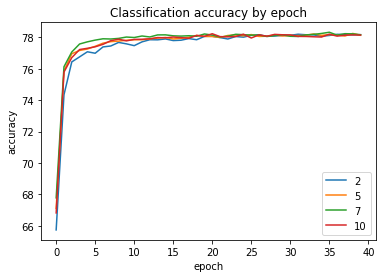

In [ ]:
fig, ax = plt.subplots()

for i in l.keys():
  ax.plot(np.arange(0, EPOCHS), l[i]['accuracy_history'])

ax.set(xlabel='epoch', ylabel='accuracy',
       title='Classification accuracy by epoch')
ax.legend(l.keys())

plt.show()

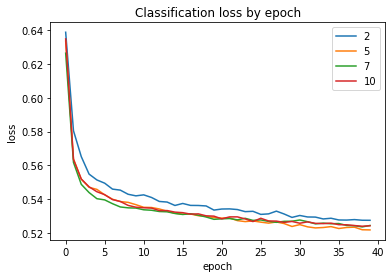

In [ ]:
fig, ax = plt.subplots()

for i in l.keys():
  ax.plot(np.arange(0, EPOCHS), l[i]['loss_history'])

ax.set(xlabel='epoch', ylabel='loss',
       title='Classification loss by epoch')
ax.legend(l.keys())

plt.show()

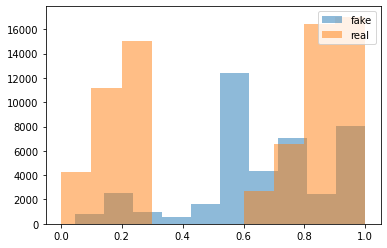

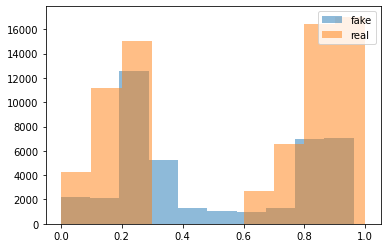

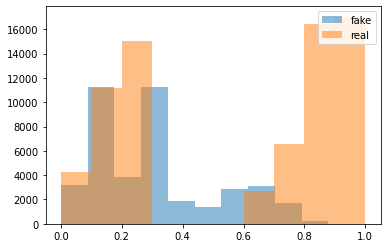

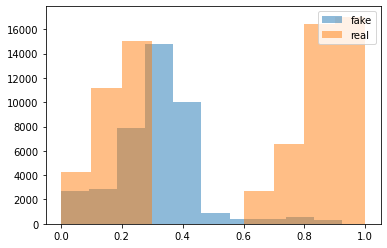

In [ ]:
for i in l.keys():
  data = l[i]['fake_dataset_end']
  data.columns = list(new_df.columns)[:-1]
  fig, ax = plt.subplots()
  col = new_df.columns[1]
  ax.hist(data[col], 10, label = 'fake', alpha = 0.5)
  ax.hist(new_df[col], 10, label = 'real', alpha = 0.5)
  ax.legend(loc='upper right')

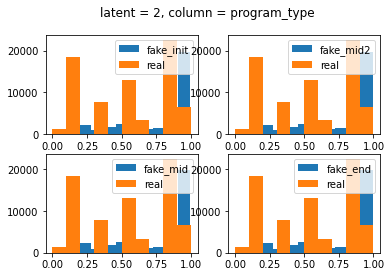

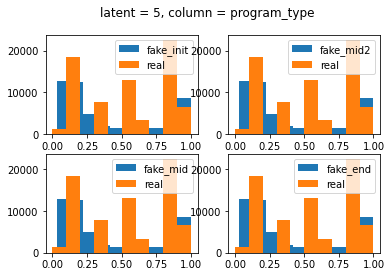

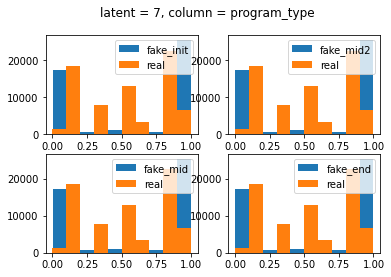

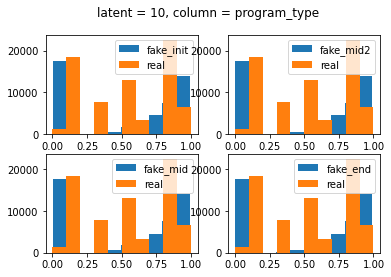

In [ ]:
for i in l.keys():
    names = [l[i]['fake_dataset_init'], l[i]['fake_dataset_mid'], 
            l[i]['fake_dataset_mid2'], l[i]['fake_dataset_end']]
    for nm in names:
        nm.columns = list(new_df.columns)[:-1]

    col = new_df.columns[0]
    fig, ax = plt.subplots(nrows=2, ncols=2)
    
    ax[0,0].hist(nm[col], 10, label = 'fake_init')
    ax[0,0].hist(new_df[col], 10, label = 'real')
    ax[0,0].legend(loc='upper right')

    ax[1,0].hist(nm[col], 10, label = 'fake_mid')
    ax[1,0].hist(new_df[col], 10, label = 'real')
    ax[1,0].legend(loc='upper right')

    ax[0,1].hist(nm[col], 10, label = 'fake_mid2')
    ax[0,1].hist(new_df[col], 10, label = 'real')
    ax[0,1].legend(loc='upper right')

    ax[1,1].hist(nm[col], 10, label = 'fake_end')
    ax[1,1].hist(new_df[col], 10, label = 'real')
    ax[1,1].legend(loc='upper right')

    fig.suptitle(f'latent = {i}, column = {col}')

    plt.show() 

## Hyperparameters

In [ ]:
l = {1: {'hp': [1e-2, 16], 'val_accuracy': 0},
     2: {'hp': [1e-2, 32], 'val_accuracy': 0},
     3: {'hp': [1e-2, 64], 'val_accuracy': 0},
     4: {'hp': [1e-3, 16], 'val_accuracy': 0},
     5: {'hp': [1e-3, 32], 'val_accuracy': 0},
     6: {'hp': [1e-3, 64], 'val_accuracy': 0},
     7: {'hp': [1e-4, 16], 'val_accuracy': 0},
     8: {'hp': [1e-4, 32], 'val_accuracy': 0},
     9: {'hp': [1e-4, 64], 'val_accuracy': 0},
     10: {'hp': [1e-5, 16], 'val_accuracy': 0},
     11: {'hp': [1e-5, 32], 'val_accuracy': 0},
     12: {'hp': [1e-5, 64], 'val_accuracy': 0}}

# Configuration options
k_folds = 10
num_epochs = 20

for ki in l.keys():

  results = {}
  torch.manual_seed(42)

  LEARNING_RATE = l[ki]['hp'][0]
  BATCH_SIZE = l[ki]['hp'][1]

  kfold = KFold(n_splits=k_folds, shuffle=True)

  for fold, (train_ids, test_ids) in enumerate(kfold.split(new_df)):
    
    # Print
    print(f'FOLD {fold}')
    print('--------------------------------')
    
    # Sample elements randomly from a given list of ids, no replacement.
    x_train = new_df.iloc[train_ids, 0:-1]
    y_train = new_df.iloc[train_ids, -1]
    x_test = new_df.iloc[test_ids, 0:-1]
    y_test = new_df.iloc[test_ids, -1]


    train_data = trainData(torch.FloatTensor(x_train.values), torch.FloatTensor(y_train.values))
    test_data = trainData(torch.FloatTensor(x_test.values), torch.FloatTensor(y_test.values))
    train_loader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE)
    test_loader = DataLoader(dataset=test_data, batch_size=1)

    classifier = binaryClassification(new_df.shape[1]-1)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(classifier.parameters(), lr=LEARNING_RATE)

    classifier.train()
    # Run the training loop for defined number of epochs
    for epoch in range(0, num_epochs):

      print(f'Starting epoch {epoch+1}')

      current_loss = 0.0
      current_acc = 0

      for i, data in enumerate(train_loader, 0):
        
        inputs, targets = data
        optimizer.zero_grad()
        
        outputs = classifier(inputs)
        
        # Compute loss and accuracy
        loss = criterion(outputs, targets.unsqueeze(1))
        acc = binary_acc(outputs, targets.unsqueeze(1))

        # Perform backward pass and optimization
        loss.backward()
        optimizer.step()
        
        # Print statistics
        current_loss += loss.item()
        current_acc += acc.item()
        if i % 500 == 499:
            print('Loss after mini-batch %5d: %.3f' %
                  (i + 1, current_loss / 500))
            print('Accuracy after mini-batch %5d: %.3f' %
                  (i + 1, current_acc / 500))
            current_loss = 0.0
            current_acc = 0

    # Process is complete.
    print('Training process has finished. Saving trained model.')

    # Print about testing
    print('Starting testing')
    
    # Saving the model
    save_path = f'./model-fold-{fold}.pth'
    torch.save(classifier.state_dict(), save_path)

    # Evaluationfor this fold
    classifier.eval()
    correct, total = 0, 0
    tot_acc = 0
    with torch.no_grad():

        # Iterate over the test data and generate predictions
        for i, data in enumerate(test_loader, 0):

              inputs, targets = data

              outputs = classifier(inputs)
              acc = binary_acc(outputs, targets.unsqueeze(1))

              tot_acc += acc.item()
        
        # Print accuracy
        print('Accuracy for fold %d: %d %%' % (fold, tot_acc/i))
        print('--------------------------------')
        results[fold] = tot_acc/i
    
  # Print fold results
  print(f'K-FOLD CROSS VALIDATION RESULTS FOR {k_folds} FOLDS')
  print('--------------------------------')
  count = 0.0
  for key, value in results.items():
    print(f'Fold {key}: {value} %')
    count += value
  print(f'Average: {count/len(results.items())} %')

  l[ki]['val_accuracy'] = count/len(results.items())

Output streaming troncato alle ultime 5000 righe.
Accuracy after mini-batch  4000: 67.264
Starting epoch 3
Loss after mini-batch   500: 0.611
Accuracy after mini-batch   500: 67.578
Loss after mini-batch  1000: 0.610
Accuracy after mini-batch  1000: 67.944
Loss after mini-batch  1500: 0.612
Accuracy after mini-batch  1500: 67.584
Loss after mini-batch  2000: 0.602
Accuracy after mini-batch  2000: 68.678
Loss after mini-batch  2500: 0.602
Accuracy after mini-batch  2500: 68.796
Loss after mini-batch  3000: 0.602
Accuracy after mini-batch  3000: 68.724
Loss after mini-batch  3500: 0.609
Accuracy after mini-batch  3500: 67.656
Loss after mini-batch  4000: 0.607
Accuracy after mini-batch  4000: 68.394
Starting epoch 4
Loss after mini-batch   500: 0.604
Accuracy after mini-batch   500: 68.404
Loss after mini-batch  1000: 0.599
Accuracy after mini-batch  1000: 69.204
Loss after mini-batch  1500: 0.605
Accuracy after mini-batch  1500: 68.310
Loss after mini-batch  2000: 0.593
Accuracy after m

In [ ]:
with open(dir + 'kfold_candidate.pkl', 'wb') as f:
    pickle.dump(l, f)

In [ ]:
l

{1: {'hp': [0.01, 16], 'val_accuracy': 78.2599633684882},
 2: {'hp': [0.01, 32], 'val_accuracy': 78.5389195883986},
 3: {'hp': [0.01, 64], 'val_accuracy': 78.92175826021595},
 4: {'hp': [0.001, 16], 'val_accuracy': 78.53344239851259},
 5: {'hp': [0.001, 32], 'val_accuracy': 78.81235786107058},
 6: {'hp': [0.001, 64], 'val_accuracy': 78.93679529275764},
 7: {'hp': [0.0001, 16], 'val_accuracy': 76.89677501279651},
 8: {'hp': [0.0001, 32], 'val_accuracy': 76.85167139358472},
 9: {'hp': [0.0001, 64], 'val_accuracy': 76.85303321264294},
 10: {'hp': [1e-05, 16], 'val_accuracy': 75.15623059702304},
 11: {'hp': [1e-05, 32], 'val_accuracy': 74.7323561888974},
 12: {'hp': [1e-05, 64], 'val_accuracy': 74.72416452195121}}

In [ ]:
l = {1: {'hp': [1e-2, 16], 'val_accuracy': 0},
     2: {'hp': [1e-2, 32], 'val_accuracy': 0},
     3: {'hp': [1e-2, 64], 'val_accuracy': 0},
     4: {'hp': [1e-3, 16], 'val_accuracy': 0},
     5: {'hp': [1e-3, 32], 'val_accuracy': 0},
     6: {'hp': [1e-3, 64], 'val_accuracy': 0},
     7: {'hp': [1e-4, 16], 'val_accuracy': 0},
     8: {'hp': [1e-4, 32], 'val_accuracy': 0},
     9: {'hp': [1e-4, 64], 'val_accuracy': 0},
     10: {'hp': [1e-5, 16], 'val_accuracy': 0},
     11: {'hp': [1e-5, 32], 'val_accuracy': 0},
     12: {'hp': [1e-5, 64], 'val_accuracy': 0}}

# Configuration options
k_folds = 10
num_epochs = 20

for ki in l.keys():

  results = {}
  torch.manual_seed(42)

  LEARNING_RATE = l[ki]['hp'][0]
  BATCH_SIZE = l[ki]['hp'][1]

  kfold = KFold(n_splits=k_folds, shuffle=True)

  for fold, (train_ids, test_ids) in enumerate(kfold.split(compas)):
    
    # Print
    print(f'FOLD {fold}')
    print('--------------------------------')
    
    # Sample elements randomly from a given list of ids, no replacement.
    x_train = compas.iloc[train_ids, 0:-1]
    y_train = compas.iloc[train_ids, -1]
    x_test = compas.iloc[test_ids, 0:-1]
    y_test = compas.iloc[test_ids, -1]


    train_data = trainData(torch.FloatTensor(x_train.values), torch.FloatTensor(y_train.values))
    test_data = trainData(torch.FloatTensor(x_test.values), torch.FloatTensor(y_test.values))
    train_loader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE)
    test_loader = DataLoader(dataset=test_data, batch_size=1)

    classifier = binaryClassification(compas.shape[1]-1)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(classifier.parameters(), lr=LEARNING_RATE)

    classifier.train()
    # Run the training loop for defined number of epochs
    for epoch in range(0, num_epochs):

      print(f'Starting epoch {epoch+1}')

      current_loss = 0.0
      current_acc = 0

      for i, data in enumerate(train_loader, 0):
        
        inputs, targets = data
        optimizer.zero_grad()
        
        outputs = classifier(inputs)
        
        # Compute loss and accuracy
        loss = criterion(outputs, targets.unsqueeze(1))
        acc = binary_acc(outputs, targets.unsqueeze(1))

        # Perform backward pass and optimization
        loss.backward()
        optimizer.step()
        
        # Print statistics
        current_loss += loss.item()
        current_acc += acc.item()
        if i % 500 == 499:
            print('Loss after mini-batch %5d: %.3f' %
                  (i + 1, current_loss / 500))
            print('Accuracy after mini-batch %5d: %.3f' %
                  (i + 1, current_acc / 500))
            current_loss = 0.0
            current_acc = 0

    # Process is complete.
    print('Training process has finished. Saving trained model.')

    # Print about testing
    print('Starting testing')
    
    # Saving the model
    save_path = f'./model-fold-{fold}.pth'
    torch.save(classifier.state_dict(), save_path)

    # Evaluationfor this fold
    classifier.eval()
    correct, total = 0, 0
    tot_acc = 0
    with torch.no_grad():

        # Iterate over the test data and generate predictions
        for i, data in enumerate(test_loader, 0):

              inputs, targets = data

              outputs = classifier(inputs)
              acc = binary_acc(outputs, targets.unsqueeze(1))

              tot_acc += acc.item()
        
        # Print accuracy
        print('Accuracy for fold %d: %d %%' % (fold, tot_acc/i))
        print('--------------------------------')
        results[fold] = tot_acc/i
    
  # Print fold results
  print(f'K-FOLD CROSS VALIDATION RESULTS FOR {k_folds} FOLDS')
  print('--------------------------------')
  count = 0.0
  for key, value in results.items():
    print(f'Fold {key}: {value} %')
    count += value
  print(f'Average: {count/len(results.items())} %')

  l[ki]['val_accuracy'] = count/len(results.items())

Output streaming troncato alle ultime 5000 righe.
Loss after mini-batch   500: 0.505
Accuracy after mini-batch   500: 78.894
Starting epoch 11
Loss after mini-batch   500: 0.503
Accuracy after mini-batch   500: 78.896
Starting epoch 12
Loss after mini-batch   500: 0.503
Accuracy after mini-batch   500: 78.896
Starting epoch 13
Loss after mini-batch   500: 0.502
Accuracy after mini-batch   500: 78.896
Starting epoch 14
Loss after mini-batch   500: 0.502
Accuracy after mini-batch   500: 78.894
Starting epoch 15
Loss after mini-batch   500: 0.502
Accuracy after mini-batch   500: 78.896
Starting epoch 16
Loss after mini-batch   500: 0.502
Accuracy after mini-batch   500: 78.896
Starting epoch 17
Loss after mini-batch   500: 0.501
Accuracy after mini-batch   500: 78.894
Starting epoch 18
Loss after mini-batch   500: 0.500
Accuracy after mini-batch   500: 78.900
Starting epoch 19
Loss after mini-batch   500: 0.500
Accuracy after mini-batch   500: 78.896
Starting epoch 20
Loss after mini-batc

In [ ]:
with open(dir + 'kfold_compas.pkl', 'wb') as f:
    pickle.dump(l, f)

In [ ]:
l

{1: {'hp': [0.01, 16], 'val_accuracy': 78.10562044252404},
 2: {'hp': [0.01, 32], 'val_accuracy': 78.61030887321053},
 3: {'hp': [0.01, 64], 'val_accuracy': 80.82127166353067},
 4: {'hp': [0.001, 16], 'val_accuracy': 78.2223386264282},
 5: {'hp': [0.001, 32], 'val_accuracy': 78.66946317773971},
 6: {'hp': [0.001, 64], 'val_accuracy': 79.90075271477414},
 7: {'hp': [0.0001, 16], 'val_accuracy': 78.10398354215297},
 8: {'hp': [0.0001, 32], 'val_accuracy': 78.11549615590512},
 9: {'hp': [0.0001, 64], 'val_accuracy': 78.1089107257559},
 10: {'hp': [1e-05, 16], 'val_accuracy': 78.10561233638154},
 11: {'hp': [1e-05, 32], 'val_accuracy': 78.10564286951823},
 12: {'hp': [1e-05, 64], 'val_accuracy': 78.10564232910873}}

## GAN

### Normal GAN

In [ ]:
def ones_target(size):
    '''
    Tensor containing ones, with shape = size
    '''
    data = Variable(torch.ones(size, 1))
    return data

def zeros_target(size):
    '''
    Tensor containing zeros, with shape = size
    '''
    data = Variable(torch.zeros(size, 1))
    return data



def train_discriminator(optimizer, real_data, fake_data, penalty = 0.01):
    N = real_data.size(0)
    
    # 1.1 Train on Real Data
    prediction_real = discriminator(real_data)
    # Calculate error and backpropagate
    error_real = loss(prediction_real, 0.9*ones_target(N) )

    # 1.2 Train on Fake Data
    prediction_fake = discriminator(fake_data)
    # Calculate error and backpropagate
    error_fake = loss(prediction_fake, zeros_target(N))

    # 1.3 L2 regularization
    l2_parameters = []
    for parameter in discriminator.parameters():
        l2_parameters.append(parameter.view(-1))
    l2 = 1/N * penalty * torch.square(torch.cat(l2_parameters)).sum()

    d_loss = error_real + error_fake + l2
    
    # 1.4 Update weights with gradients
    d_loss.backward()
    optimizer.step()
    
    return d_loss/2



def train_generator(optimizer_encoder, optimizer_decoder, fake_data, target, lam):
    N = fake_data.size(0)

    #Generator
    prediction = discriminator(fake_data)
    g_error = loss(prediction, ones_target(N))

    #Classificator
    fake_labels = classifier(fake_data).reshape(-1)
    #fake_labels = 1-fake_labels
    c_loss = loss(fake_labels, target)
    acc = binary_acc(fake_labels, target)
    
    #Total Error
    error = g_error + lam * c_loss
    error.backward()
    optimizer_encoder.step()
    optimizer_decoder.step()
    
    return g_error, c_loss, acc


##### hyperparameters

In [ ]:
loss = nn.BCEWithLogitsLoss()
EPOCHS = 50

l = {0: {'accuracy_history': [], 'gErr_history': [], 'dErr_history': [], 'gErr_details': [], 'dErr_details': [], 'closs_history': [], 
           'fake_dataset_init': pd.DataFrame(), 'fake_dataset_mid': pd.DataFrame(), 'fake_dataset_mid2': pd.DataFrame(), 'fake_dataset_end': pd.DataFrame()},
     0.1: {'accuracy_history': [], 'gErr_history': [], 'dErr_history': [], 'gErr_details': [], 'dErr_details': [], 'closs_history': [], 
           'fake_dataset_init': pd.DataFrame(), 'fake_dataset_mid': pd.DataFrame(), 'fake_dataset_mid2': pd.DataFrame(), 'fake_dataset_end': pd.DataFrame()},
     1e-2: {'accuracy_history': [], 'gErr_history': [], 'dErr_history': [], 'gErr_details': [], 'dErr_details': [], 'closs_history': [], 
           'fake_dataset_init': pd.DataFrame(), 'fake_dataset_mid': pd.DataFrame(), 'fake_dataset_mid2': pd.DataFrame(), 'fake_dataset_end': pd.DataFrame()},
     1e-4: {'accuracy_history': [], 'gErr_history': [], 'dErr_history': [], 'gErr_details': [], 'dErr_details': [], 'closs_history': [], 
           'fake_dataset_init': pd.DataFrame(), 'fake_dataset_mid': pd.DataFrame(), 'fake_dataset_mid2': pd.DataFrame(), 'fake_dataset_end': pd.DataFrame()},
     1e-5: {'accuracy_history': [], 'gErr_history': [], 'dErr_history': [], 'gErr_details': [], 'dErr_details': [], 'closs_history': [], 
           'fake_dataset_init': pd.DataFrame(), 'fake_dataset_mid': pd.DataFrame(), 'fake_dataset_mid2': pd.DataFrame(), 'fake_dataset_end': pd.DataFrame()},
     1e-8: {'accuracy_history': [], 'gErr_history': [], 'dErr_history': [], 'gErr_details': [], 'dErr_details': [], 'closs_history': [], 
           'fake_dataset_init': pd.DataFrame(), 'fake_dataset_mid': pd.DataFrame(), 'fake_dataset_mid2': pd.DataFrame(), 'fake_dataset_end': pd.DataFrame()},
     1e-10: {'accuracy_history': [], 'gErr_history': [], 'dErr_history': [], 'gErr_details': [], 'dErr_details': [], 'closs_history': [], 
           'fake_dataset_init': pd.DataFrame(), 'fake_dataset_mid': pd.DataFrame(), 'fake_dataset_mid2': pd.DataFrame(), 'fake_dataset_end': pd.DataFrame()}}

In [ ]:
for counter, value in enumerate(l.keys()):
  classifier = binaryClassification(15)
  classifier.load_state_dict(torch.load(dir+'model_3'))

  train_loader, test_loader = data_prep(compas)
  preprocessing = pre_generator(0, 15, 10) #encoder
  generator = VAE_generator(15, 10) #decoder
  discriminator = binaryClassification(15)

  preproc_optimizer = optim.Adam(preprocessing.parameters(), lr=LEARNING_RATE, betas = (0,0.99))
  g_optimizer = optim.Adam(generator.parameters(), lr=LEARNING_RATE, betas = (0, 0.99))
  d_optimizer = optim.Adam(discriminator.parameters(), lr=LEARNING_RATE, betas = (0, 0.99))
  #preproc_scheduler = optim.lr_scheduler.MultiStepLR(preproc_optimizer, milestones=[10, 20, 30], gamma=0.1)
  #g_scheduler = optim.lr_scheduler.MultiStepLR(g_optimizer, milestones=[10, 20, 30], gamma=0.1)
  #d_scheduler = optim.lr_scheduler.MultiStepLR(d_optimizer, milestones=[10, 20, 30], gamma=0.1)


  for epoch in range(EPOCHS+1):
      epoch_loss = 0
      epoch_acc = 0
      epoch_gErr = []
      epoch_dErr = []
      for n_batch, (real_batch, labels) in enumerate(train_loader):
          N = real_batch.size(0)
          d_optimizer.zero_grad()
          g_optimizer.zero_grad()
          preproc_optimizer.zero_grad()
          # 1. Train Discriminator
          mu,log_var = preprocessing(real_batch)
          fake_data = generator(mu,log_var)
          fak_data = fake_data.detach()
          if epoch == 0:
            l[value]['fake_dataset_init'] = pd.concat([l[value]['fake_dataset_init'], pd.DataFrame(fake_data.tolist())], ignore_index=True)
          if epoch == EPOCHS//3:
            l[value]['fake_dataset_mid'] = pd.concat([l[value]['fake_dataset_mid'], pd.DataFrame(fake_data.tolist())], ignore_index=True)
          if epoch == EPOCHS//3*2:
            l[value]['fake_dataset_mid2'] = pd.concat([l[value]['fake_dataset_mid2'], pd.DataFrame(fake_data.tolist())], ignore_index=True)
          if epoch == EPOCHS: 
            l[value]['fake_dataset_end'] = pd.concat([l[value]['fake_dataset_end'], pd.DataFrame(fake_data.tolist())], ignore_index=True)

          if n_batch%10==9:
            d_error = train_discriminator(d_optimizer, real_batch, fak_data)
            epoch_dErr.append(d_error.item())

          # 2. Train Generator
          g_error, c_loss, acc = train_generator(g_optimizer, preproc_optimizer, fake_data, labels, value)
          epoch_loss += c_loss.item()
          epoch_acc += acc.item()
          epoch_gErr.append(g_error.item())

  
      l[value]['accuracy_history'].append(epoch_acc/len(train_loader))
      l[value]['closs_history'].append(epoch_loss/len(train_loader))
      l[value]['gErr_history'].append(sum(epoch_gErr)/len(train_loader))
      l[value]['dErr_history'].append(sum(epoch_dErr)/(len(epoch_dErr)))
      print(f'Epoch: {epoch+0:03} | D_Error: {sum(epoch_dErr)/(len(epoch_dErr)):.4f} | G_Error: {sum(epoch_gErr)/len(train_loader):.4f}')
      print(f'Epoch: {epoch+0:03} | Loss: {epoch_loss/len(train_loader):.5f} | Acc: {epoch_acc/len(train_loader):.3f}')

Epoch: 000 | D_Error: 0.7090 | G_Error: 0.6295
Epoch: 000 | Loss: 1.10597 | Acc: 69.268
Epoch: 001 | D_Error: 0.7069 | G_Error: 0.6325
Epoch: 001 | Loss: 1.07104 | Acc: 68.737
Epoch: 002 | D_Error: 0.7067 | G_Error: 0.6357
Epoch: 002 | Loss: 1.03427 | Acc: 68.805
Epoch: 003 | D_Error: 0.7065 | G_Error: 0.6392
Epoch: 003 | Loss: 0.99642 | Acc: 68.447
Epoch: 004 | D_Error: 0.7063 | G_Error: 0.6422
Epoch: 004 | Loss: 0.96233 | Acc: 68.720
Epoch: 005 | D_Error: 0.7045 | G_Error: 0.6454
Epoch: 005 | Loss: 0.92115 | Acc: 68.651
Epoch: 006 | D_Error: 0.7052 | G_Error: 0.6482
Epoch: 006 | Loss: 0.86924 | Acc: 69.568
Epoch: 007 | D_Error: 0.7030 | G_Error: 0.6496
Epoch: 007 | Loss: 0.83306 | Acc: 69.819
Epoch: 008 | D_Error: 0.7031 | G_Error: 0.6509
Epoch: 008 | Loss: 0.79768 | Acc: 70.668
Epoch: 009 | D_Error: 0.7036 | G_Error: 0.6514
Epoch: 009 | Loss: 0.76551 | Acc: 70.884
Epoch: 010 | D_Error: 0.7017 | G_Error: 0.6532
Epoch: 010 | Loss: 0.74513 | Acc: 71.552
Epoch: 011 | D_Error: 0.7020 | G

##### Plots with cycles for disc (n.10)

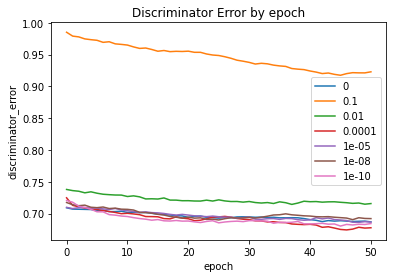

In [ ]:
# Discriminator
fig, ax = plt.subplots()

for i in l.keys():
  ax.plot(np.arange(0, EPOCHS+1), l[i]['dErr_history'])

ax.set(xlabel='epoch', ylabel='discriminator_error',
       title='Discriminator Error by epoch')
ax.legend(l.keys())

plt.show()

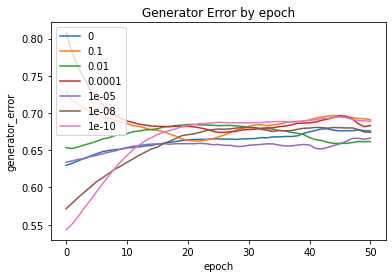

In [ ]:
# Generator
fig, ax = plt.subplots()

for i in l.keys():
  ax.plot(np.arange(0, EPOCHS+1), l[i]['gErr_history'])

ax.set(xlabel='epoch', ylabel='generator_error',
       title='Generator Error by epoch')
ax.legend(l.keys())

plt.show()

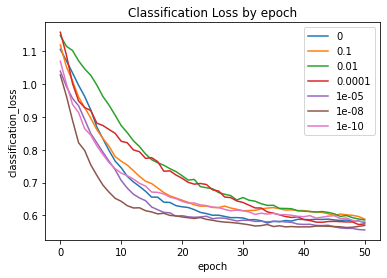

In [ ]:
# Classification
fig, ax = plt.subplots()

for i in l.keys():
  ax.plot(np.arange(0, EPOCHS+1), l[i]['closs_history'])

# blue, orange, green, red, violet

ax.set(xlabel='epoch', ylabel='classification_loss',
       title='Classification Loss by epoch')
ax.legend(l.keys())

plt.show()

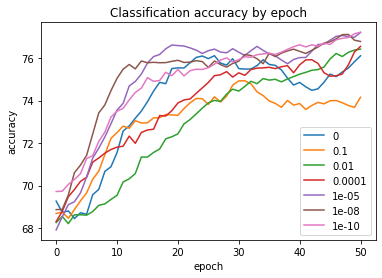

In [ ]:
# Accuracy
fig, ax = plt.subplots()

for i in l.keys():
  ax.plot(np.arange(0, EPOCHS+1), l[i]['accuracy_history'])

ax.set(xlabel='epoch', ylabel='accuracy',
       title='Classification accuracy by epoch')
ax.legend(l.keys())

plt.show()

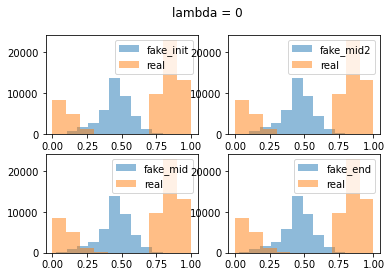

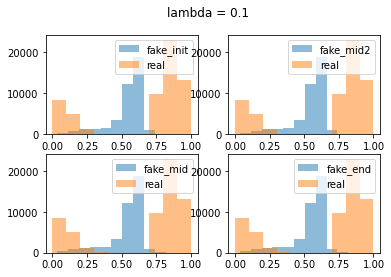

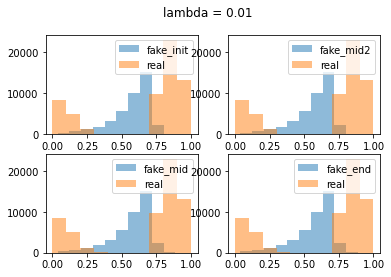

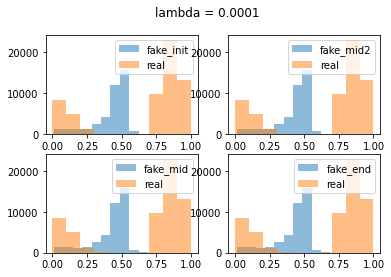

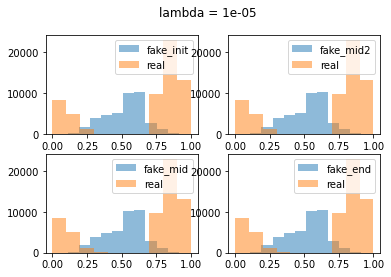

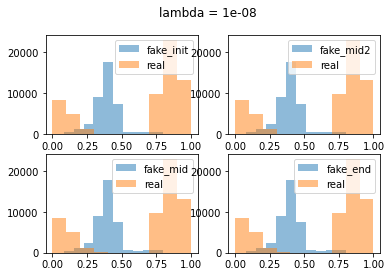

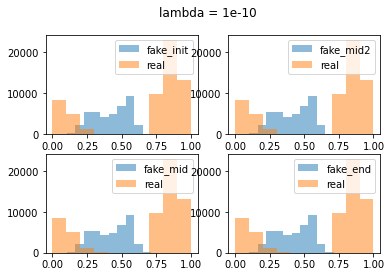

In [ ]:
for i in l.keys():
  names = [l[i]['fake_dataset_init'], l[i]['fake_dataset_mid'], 
           l[i]['fake_dataset_mid2'], l[i]['fake_dataset_end']]
  for nm in names:
    nm.columns = list(compas.columns)[:-1]
  fig, ax = plt.subplots(nrows=2, ncols=2)

  ax[0,0].hist(nm.DateOfBirth, 10, label = 'fake_init', alpha = 0.5)
  ax[0,0].hist(compas.DateOfBirth, 10, label = 'real', alpha = 0.5)
  ax[0,0].legend(loc='upper right')

  ax[1,0].hist(nm.DateOfBirth, 10, label = 'fake_mid', alpha = 0.5)
  ax[1,0].hist(compas.DateOfBirth, 10, label = 'real', alpha = 0.5)
  ax[1,0].legend(loc='upper right')

  ax[0,1].hist(nm.DateOfBirth, 10, label = 'fake_mid2', alpha = 0.5)
  ax[0,1].hist(compas.DateOfBirth, 10, label = 'real', alpha = 0.5)
  ax[0,1].legend(loc='upper right')

  ax[1,1].hist(nm.DateOfBirth, 10, label = 'fake_end', alpha = 0.5)
  ax[1,1].hist(compas.DateOfBirth, 10, label = 'real', alpha = 0.5)
  ax[1,1].legend(loc='upper right')

  fig.suptitle(f'lambda = {i}')

  plt.show()

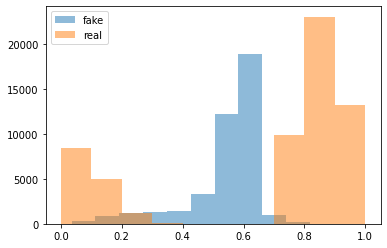

In [ ]:
fig, ax = plt.subplots()
ax.hist(l[0.1]['fake_dataset_end'].DateOfBirth, 10, label = 'fake', alpha = 0.5)
ax.hist(compas.DateOfBirth, 10, label = 'real', alpha = 0.5)
ax.legend(loc='upper left')

In [ ]:
print('---------------------------------------------------')
print('init')
print('---------------------------------------------------')
print(l[0]['fake_dataset_init'].Agency_Text[:6].values)
print(compas.Agency_Text[:6].values)
print('---------------------------------------------------')
print('mid')
print('---------------------------------------------------')
print(l[0]['fake_dataset_mid'].Agency_Text[:6].values)
print(compas.Agency_Text[:6].values)
print('---------------------------------------------------')
print('mid2')
print('---------------------------------------------------')
print(l[0]['fake_dataset_mid2'].Agency_Text[:6].values)
print(compas.Agency_Text[:6].values)
print('---------------------------------------------------')
print('end')
print('---------------------------------------------------')
print(l[0]['fake_dataset_end'].Agency_Text[:6].values)
print(compas.Agency_Text[:6].values)

---------------------------------------------------
init
---------------------------------------------------
[0.43958125 0.6184805  0.32308608 0.3962504  0.43689594 0.38485208]
[0.66666667 0.66666667 0.66666667 0.66666667 0.66666667 0.66666667]
---------------------------------------------------
mid
---------------------------------------------------
[0.78592271 0.40751165 0.37079093 0.77354127 0.39099112 0.37741607]
[0.66666667 0.66666667 0.66666667 0.66666667 0.66666667 0.66666667]
---------------------------------------------------
mid2
---------------------------------------------------
[0.37421602 0.33884132 0.7440151  0.34304959 0.56272441 0.36748669]
[0.66666667 0.66666667 0.66666667 0.66666667 0.66666667 0.66666667]
---------------------------------------------------
end
---------------------------------------------------
[0.35741654 0.43745002 0.38669044 0.55841452 0.72124732 0.70426583]
[0.66666667 0.66666667 0.66666667 0.66666667 0.66666667 0.66666667]


In [ ]:
print('---------------------------------------------------')
print('init')
print('---------------------------------------------------')
print(l[0]['fake_dataset_init'].Language[:6].values)
print(compas.Agency_Text[:6].values)
print('---------------------------------------------------')
print('mid')
print('---------------------------------------------------')
print(l[0]['fake_dataset_mid'].Language[:6].values)
print(compas.Agency_Text[:6].values)
print('---------------------------------------------------')
print('mid2')
print('---------------------------------------------------')
print(l[0]['fake_dataset_mid2'].Language[:6].values)
print(compas.Agency_Text[:6].values)
print('---------------------------------------------------')
print('end')
print('---------------------------------------------------')
print(l[0]['fake_dataset_end'].Language[:6].values)
print(compas.Agency_Text[:6].values)

---------------------------------------------------
init
---------------------------------------------------
[0.48745754 0.3153528  0.53790247 0.54249406 0.45323604 0.5269565 ]
[0.66666667 0.66666667 0.66666667 0.66666667 0.66666667 0.66666667]
---------------------------------------------------
mid
---------------------------------------------------
[0.62325662 0.41270381 0.45008138 0.25949985 0.38955545 0.4678449 ]
[0.66666667 0.66666667 0.66666667 0.66666667 0.66666667 0.66666667]
---------------------------------------------------
mid2
---------------------------------------------------
[0.42466646 0.63016701 0.59261012 0.40610927 0.25769809 0.41357344]
[0.66666667 0.66666667 0.66666667 0.66666667 0.66666667 0.66666667]
---------------------------------------------------
end
---------------------------------------------------
[0.40828735 0.45795876 0.43188518 0.52524722 0.67486674 0.67661184]
[0.66666667 0.66666667 0.66666667 0.66666667 0.66666667 0.66666667]


#### real thing

##### Hyperparameters take 2

In [ ]:
loss = nn.BCEWithLogitsLoss()
EPOCHS = 50

final_acc = {1:0, 2:0, 3:0, 4:0}

for num in range(5):
      l = {1: {'gamma': 0.5, 'lr': 1e-3, 'accuracy_history': [], 'gErr_history': [], 'dErr_history': [], 'gErr_details': [], 'dErr_details': [], 'closs_history': [], 
              'fake_dataset_init': pd.DataFrame(), 'fake_dataset_mid': pd.DataFrame(), 'fake_dataset_mid2': pd.DataFrame(), 'fake_dataset_end': pd.DataFrame(),
              'val_set': pd.DataFrame(), 'val_closs': 0, 'val_acc': 0, 'val_derr':[], 'val_gerr':[], 'total': 0},
          2: {'gamma': 0.5, 'lr': 1e-4, 'accuracy_history': [], 'gErr_history': [], 'dErr_history': [], 'gErr_details': [], 'dErr_details': [], 'closs_history': [], 
              'fake_dataset_init': pd.DataFrame(), 'fake_dataset_mid': pd.DataFrame(), 'fake_dataset_mid2': pd.DataFrame(), 'fake_dataset_end': pd.DataFrame(),
              'val_set': pd.DataFrame(), 'val_closs': 0, 'val_acc': 0, 'val_derr':[], 'val_gerr':[], 'total': 0},
          3: {'gamma': 0.1, 'lr': 1e-3, 'accuracy_history': [], 'gErr_history': [], 'dErr_history': [], 'gErr_details': [], 'dErr_details': [], 'closs_history': [],
              'fake_dataset_init': pd.DataFrame(), 'fake_dataset_mid': pd.DataFrame(), 'fake_dataset_mid2': pd.DataFrame(), 'fake_dataset_end': pd.DataFrame(),
              'val_set': pd.DataFrame(), 'val_closs': 0, 'val_acc': 0, 'val_derr':[], 'val_gerr':[], 'total': 0},
          4: {'gamma': 0.1, 'lr': 1e-4, 'accuracy_history': [], 'gErr_history': [], 'dErr_history': [], 'gErr_details': [], 'dErr_details': [], 'closs_history': [], 
              'fake_dataset_init': pd.DataFrame(), 'fake_dataset_mid': pd.DataFrame(), 'fake_dataset_mid2': pd.DataFrame(), 'fake_dataset_end': pd.DataFrame(),
              'val_set': pd.DataFrame(), 'val_closs': 0, 'val_acc': 0, 'val_derr':[], 'val_gerr':[], 'total': 0}}

      for counter in l.keys():
          classifier = binaryClassification(15)
          classifier.load_state_dict(torch.load(dir+'model_3'))

          train_loader, test_loader = data_prep(compas)
          preprocessing = pre_generator(0, 15, 10) #encoder
          generator = VAE_generator(15, 10) #decoder
          discriminator = binaryClassification(15)

          preproc_optimizer = optim.Adam(preprocessing.parameters(), lr=l[counter]['lr'], betas = (0,0.99))
          g_optimizer = optim.Adam(generator.parameters(), lr=l[counter]['lr'], betas = (0, 0.99))
          d_optimizer = optim.Adam(discriminator.parameters(), lr=l[counter]['lr'], betas = (0, 0.99))
          #preproc_scheduler = optim.lr_scheduler.MultiStepLR(preproc_optimizer, milestones=[20, 40, 60], gamma=0.1)
          #g_scheduler = optim.lr_scheduler.MultiStepLR(g_optimizer, milestones=[20, 40, 60], gamma=0.1)
          #d_scheduler = optim.lr_scheduler.MultiStepLR(d_optimizer, milestones=[20, 40, 60], gamma=0.1)


          for epoch in range(EPOCHS+1):
              epoch_loss = 0
              epoch_acc = 0
              epoch_gErr = []
              epoch_dErr = []
              for n_batch, (real_batch, labels) in enumerate(train_loader):
                  N = real_batch.size(0)
                  d_optimizer.zero_grad()
                  g_optimizer.zero_grad()
                  preproc_optimizer.zero_grad()
                  # 1. Train Discriminator
                  mu,log_var = preprocessing(real_batch)
                  fake_data = generator(mu,log_var)
                  fak_data = fake_data.detach()
                  if epoch == 0:
                    l[counter]['fake_dataset_init'] = pd.concat([l[counter]['fake_dataset_init'], pd.DataFrame(fake_data.tolist())], ignore_index=True, axis = 0)
                  if epoch == EPOCHS//3:
                    l[counter]['fake_dataset_mid'] = pd.concat([l[counter]['fake_dataset_mid'], pd.DataFrame(fake_data.tolist())], ignore_index=True, axis = 0)
                  if epoch == EPOCHS//3*2:
                    l[counter]['fake_dataset_mid2'] = pd.concat([l[counter]['fake_dataset_mid2'], pd.DataFrame(fake_data.tolist())], ignore_index=True, axis = 0)
                  if epoch == EPOCHS: 
                    l[counter]['fake_dataset_end'] = pd.concat([l[counter]['fake_dataset_end'], pd.DataFrame(fake_data.tolist())], ignore_index=True, axis = 0)

                  if n_batch%10==9:
                    d_error = train_discriminator(d_optimizer, real_batch, fak_data)
                    epoch_dErr.append(d_error.item())

                  # 2. Train Generator
                  g_error, c_loss, acc = train_generator(g_optimizer, preproc_optimizer, fake_data, labels, l[counter]['gamma'])
                  epoch_loss += c_loss.item()
                  epoch_acc += acc.item()
                  epoch_gErr.append(g_error.item())


              l[counter]['accuracy_history'].append(epoch_acc/len(train_loader))
              l[counter]['closs_history'].append(epoch_loss/len(train_loader))
              if epoch <3:
                  l[counter]['gErr_details'].append(epoch_gErr)
                  l[counter]['dErr_details'].append(epoch_dErr)
              l[counter]['gErr_history'].append(sum(epoch_gErr)/len(train_loader))
              l[counter]['dErr_history'].append(sum(epoch_dErr)/(len(epoch_dErr)))
              print(f'Epoch: {epoch+0:03} | D_Error: {sum(epoch_dErr)/(len(epoch_dErr)):.4f} | G_Error: {sum(epoch_gErr)/len(train_loader):.4f}')
              print(f'Epoch: {epoch+0:03} | Loss: {epoch_loss/len(train_loader):.5f} | Acc: {epoch_acc/len(train_loader):.3f}')

              # Validation
              if epoch == EPOCHS:
                with torch.no_grad():
                    for X_batch, y_batch in test_loader:
                        N = X_batch.size(0)

                        mu,log_var = preprocessing(X_batch)
                        fake_batch = generator(mu,log_var)
                        output = classifier(fake_batch)

                        # losses
                        prediction = discriminator(fake_batch)
                        derr = loss(prediction, zeros_target(N))
                        gerr = loss(prediction, ones_target(N))
                        closs = loss(output, y_batch.unsqueeze(1))
                        acc = binary_acc(output, y_batch.unsqueeze(1))

                        # results
                        l[counter]['val_set'] = pd.concat([l[counter]['val_set'], pd.DataFrame(fake_batch.tolist())], ignore_index=True)
                        l[counter]['val_gerr'].append(gerr.item())
                        l[counter]['val_derr'].append(derr.item())
                        l[counter]['val_acc'] += acc.item()
                        l[counter]['val_closs'] += closs.item()
                        l[counter]['total'] += 1

      final_acc[1] += l[1]['val_acc']/l[1]['total']
      final_acc[2] += l[2]['val_acc']/l[2]['total']
      final_acc[3] += l[3]['val_acc']/l[3]['total']
      final_acc[4] += l[4]['val_acc']/l[4]['total']

Epoch: 000 | D_Error: 0.7005 | G_Error: 0.7892
Epoch: 000 | Loss: 0.62322 | Acc: 75.805
Epoch: 001 | D_Error: 0.6731 | G_Error: 0.8688
Epoch: 001 | Loss: 0.56190 | Acc: 77.070
Epoch: 002 | D_Error: 0.6864 | G_Error: 0.8669
Epoch: 002 | Loss: 0.56244 | Acc: 76.414
Epoch: 003 | D_Error: 0.6860 | G_Error: 0.8765
Epoch: 003 | Loss: 0.56355 | Acc: 76.500
Epoch: 004 | D_Error: 0.6950 | G_Error: 0.8581
Epoch: 004 | Loss: 0.57721 | Acc: 75.199
Epoch: 005 | D_Error: 0.6852 | G_Error: 0.8722
Epoch: 005 | Loss: 0.59192 | Acc: 75.188
Epoch: 006 | D_Error: 0.6883 | G_Error: 0.8703
Epoch: 006 | Loss: 0.60749 | Acc: 74.881
Epoch: 007 | D_Error: 0.6931 | G_Error: 0.8651
Epoch: 007 | Loss: 0.60112 | Acc: 75.473
Epoch: 008 | D_Error: 0.6899 | G_Error: 0.8675
Epoch: 008 | Loss: 0.58221 | Acc: 75.551
Epoch: 009 | D_Error: 0.6923 | G_Error: 0.8740
Epoch: 009 | Loss: 0.60125 | Acc: 75.539
Epoch: 010 | D_Error: 0.6880 | G_Error: 0.8815
Epoch: 010 | Loss: 0.59811 | Acc: 75.000
Epoch: 011 | D_Error: 0.6874 | G

In [ ]:
#second run (adding another 5 'folds')
final_acc

{1: 742.8657370517928,
 2: 744.5155378486056,
 3: 708.3215139442232,
 4: 731.4828685258964}

In [ ]:
#74.287
#74.452
#70.832
#73.148

In [ ]:
final_acc

{1: 372.81992031872505,
 2: 367.8585657370518,
 3: 350.83107569721113,
 4: 366.32868525896413}

In [ ]:
for key in final_acc.keys():
  print(final_acc[key]/5)

74.56398406374501
73.57171314741035
70.16621513944223
73.26573705179283


##### Changing task

In [ ]:
loss = nn.BCEWithLogitsLoss()
EPOCHS = 50

l = {0.5:{'accuracy_history': [], 'gErr_history': [], 'dErr_history': [], 'gErr_details': [], 'dErr_details': [], 'closs_history': [], 
     'fake_dataset_init': pd.DataFrame(), 'fake_dataset_mid': pd.DataFrame(), 'fake_dataset_mid2': pd.DataFrame(), 'fake_dataset_end': pd.DataFrame(),
     'val_set': pd.DataFrame(), 'val_closs': 0, 'val_acc': 0, 'val_derr':[], 'val_gerr':[], 'total': 0},
     100:{'accuracy_history': [], 'gErr_history': [], 'dErr_history': [], 'gErr_details': [], 'dErr_details': [], 'closs_history': [], 
     'fake_dataset_init': pd.DataFrame(), 'fake_dataset_mid': pd.DataFrame(), 'fake_dataset_mid2': pd.DataFrame(), 'fake_dataset_end': pd.DataFrame(),
     'val_set': pd.DataFrame(), 'val_closs': 0, 'val_acc': 0, 'val_derr':[], 'val_gerr':[], 'total': 0}}

for counter in l.keys():
  classifier = binaryClassification(15)
  classifier.load_state_dict(torch.load(dir+'model_3'))

  train_loader, test_loader = data_prep(compas)
  preprocessing = pre_generator(0, 15, 15) #encoder
  generator = VAE_generator(15, 15) #decoder
  discriminator = binaryClassification(15)

  for name, child in generator.named_children():
    for param in child.parameters():
      param.requires_grad = False


  preproc_optimizer = optim.Adam(preprocessing.parameters(), lr=1e-3, betas = (0,0.99))
  g_optimizer = optim.Adam(generator.parameters(), lr=1e-3, betas = (0, 0.99))
  d_optimizer = optim.Adam(discriminator.parameters(), lr=1e-3, betas = (0, 0.99))
  #preproc_scheduler = optim.lr_scheduler.MultiStepLR(preproc_optimizer, milestones=[20, 40, 60], gamma=0.1)
  #g_scheduler = optim.lr_scheduler.MultiStepLR(g_optimizer, milestones=[20, 40, 60], gamma=0.1)
  #d_scheduler = optim.lr_scheduler.MultiStepLR(d_optimizer, milestones=[20, 40, 60], gamma=0.1)


  for epoch in range(EPOCHS+1):
      epoch_loss = 0
      epoch_acc = 0
      epoch_gErr = []
      epoch_dErr = []
      for n_batch, (real_batch, labels) in enumerate(train_loader):
          N = real_batch.size(0)
          d_optimizer.zero_grad()
          g_optimizer.zero_grad()
          preproc_optimizer.zero_grad()
          # 1. Train Discriminator
          mu,log_var = preprocessing(real_batch)
          fake_data = generator(mu,log_var)
          fak_data = fake_data.detach()
          if epoch == 0:
            l[counter]['fake_dataset_init'] = pd.concat([l[counter]['fake_dataset_init'], pd.DataFrame(fake_data.tolist())], ignore_index=True, axis = 0)
          if epoch == EPOCHS//3:
            l[counter]['fake_dataset_mid'] = pd.concat([l[counter]['fake_dataset_mid'], pd.DataFrame(fake_data.tolist())], ignore_index=True, axis = 0)
          if epoch == EPOCHS//3*2:
            l[counter]['fake_dataset_mid2'] = pd.concat([l[counter]['fake_dataset_mid2'], pd.DataFrame(fake_data.tolist())], ignore_index=True, axis = 0)
          if epoch == EPOCHS: 
            l[counter]['fake_dataset_end'] = pd.concat([l[counter]['fake_dataset_end'], pd.DataFrame(fake_data.tolist())], ignore_index=True, axis = 0)

          if n_batch%10==9:
            d_error = train_discriminator(d_optimizer, real_batch, fak_data)
            epoch_dErr.append(d_error.item())

          # 2. Train Generator
          g_error, c_loss, acc = train_generator(g_optimizer, preproc_optimizer, fake_data, labels, counter)
          epoch_loss += c_loss.item()
          epoch_acc += acc.item()
          epoch_gErr.append(g_error.item())

  
      l[counter]['accuracy_history'].append(epoch_acc/len(train_loader))
      l[counter]['closs_history'].append(epoch_loss/len(train_loader))
      if epoch <3:
          l[counter]['gErr_details'].append(epoch_gErr)
          l[counter]['dErr_details'].append(epoch_dErr)
      l[counter]['gErr_history'].append(sum(epoch_gErr)/len(train_loader))
      l[counter]['dErr_history'].append(sum(epoch_dErr)/(len(epoch_dErr)))
      print(f'Epoch: {epoch+0:03} | D_Error: {sum(epoch_dErr)/(len(epoch_dErr)):.4f} | G_Error: {sum(epoch_gErr)/len(train_loader):.4f}')
      print(f'Epoch: {epoch+0:03} | Loss: {epoch_loss/len(train_loader):.5f} | Acc: {epoch_acc/len(train_loader):.3f}')

      # Validation
      if epoch == EPOCHS:
        with torch.no_grad():
            for X_batch, y_batch in test_loader:
                N = X_batch.size(0)

                mu,log_var = preprocessing(X_batch)
                fake_batch = generator(mu,log_var)
                output = classifier(fake_batch)

                # losses
                prediction = discriminator(fake_batch)
                derr = loss(prediction, zeros_target(N))
                gerr = loss(prediction, ones_target(N))
                closs = loss(output, y_batch.unsqueeze(1))
                acc = binary_acc(output, y_batch.unsqueeze(1))

                # results
                l[counter]['val_set'] = pd.concat([l[counter]['val_set'], pd.DataFrame(fake_batch.tolist())], ignore_index=True)
                l[counter]['val_gerr'].append(gerr.item())
                l[counter]['val_derr'].append(derr.item())
                l[counter]['val_acc'] += acc.item()
                l[counter]['val_closs'] += closs.item()
                l[counter]['total'] += 1
            

Epoch: 000 | D_Error: 0.6713 | G_Error: 0.8408
Epoch: 000 | Loss: 1.07049 | Acc: 63.210
Epoch: 001 | D_Error: 0.5619 | G_Error: 1.0970
Epoch: 001 | Loss: 0.99625 | Acc: 63.652
Epoch: 002 | D_Error: 0.4918 | G_Error: 1.3327
Epoch: 002 | Loss: 0.96771 | Acc: 62.852
Epoch: 003 | D_Error: 0.4463 | G_Error: 1.5463
Epoch: 003 | Loss: 0.96288 | Acc: 61.655
Epoch: 004 | D_Error: 0.4220 | G_Error: 1.7001
Epoch: 004 | Loss: 1.06320 | Acc: 62.407
Epoch: 005 | D_Error: 0.3856 | G_Error: 1.9053
Epoch: 005 | Loss: 1.05090 | Acc: 61.625
Epoch: 006 | D_Error: 0.3576 | G_Error: 2.1278
Epoch: 006 | Loss: 1.04679 | Acc: 60.811
Epoch: 007 | D_Error: 0.3399 | G_Error: 2.2843
Epoch: 007 | Loss: 1.15736 | Acc: 59.570
Epoch: 008 | D_Error: 0.3246 | G_Error: 2.5054
Epoch: 008 | Loss: 1.08888 | Acc: 61.273
Epoch: 009 | D_Error: 0.3187 | G_Error: 2.6250
Epoch: 009 | Loss: 1.12430 | Acc: 60.797
Epoch: 010 | D_Error: 0.3199 | G_Error: 2.7619
Epoch: 010 | Loss: 1.11306 | Acc: 58.879
Epoch: 011 | D_Error: 0.3028 | G

In [ ]:
torch.save(preprocessing.state_dict(), dir + 'encoder_compas_gender')
torch.save(generator.state_dict(), dir + 'decoder_compas_gender')
torch.save(discriminator.state_dict(), dir + 'discriminator_compas_gender')

In [ ]:
l[1]['total']

2510

In [ ]:
for i in l.keys():
  print(i, l[i]['val_acc']/l[i]['total'])

# 0.5: 62.176
# 100: 65.749

0.5 57.57888446215139
100 64.82868525896414


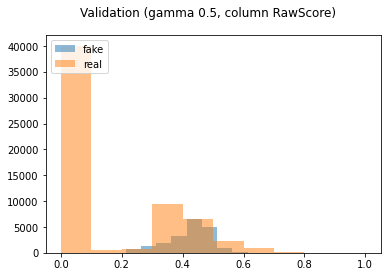

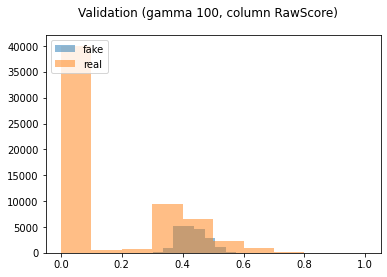

In [ ]:
for i in l.keys():

    for count, col in enumerate(compas.columns[:-1]):
        if col == 'RawScore':
            fig, ax = plt.subplots()

            ax.hist(l[i]['val_set'].iloc[:,count], 10, label = 'fake', alpha = 0.5)
            ax.hist(compas.iloc[:,count], 10, label = 'real', alpha = 0.5)
            ax.legend(loc='upper left')

            fig.suptitle(f'Validation (gamma {i}, column {col})')

            plt.show()

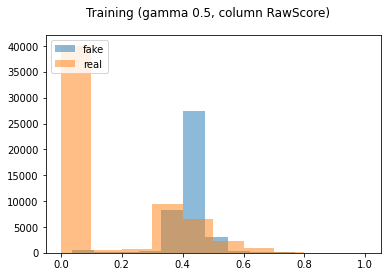

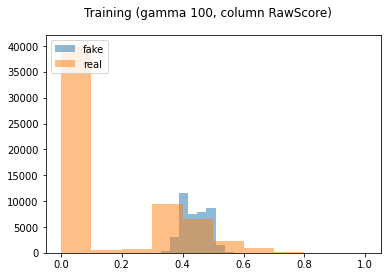

In [ ]:
for i in l.keys():

    for count, col in enumerate(compas.columns[:-1]):
        if col == 'RawScore':
            fig, ax = plt.subplots()

            ax.hist(l[i]['fake_dataset_end'].iloc[:,count], 10, label = 'fake', alpha = 0.5)
            ax.hist(compas.iloc[:,count], 10, label = 'real', alpha = 0.5)
            ax.legend(loc='upper left')

            fig.suptitle(f'Training (gamma {i}, column {col})')

            plt.show()


#### lr = 0.001

##### Plots with cycles for disc (n.10)

In [ ]:
for i in l.keys():
  print(l[i]['val_acc']/l[i]['total'])

69.9191235059761
73.0207171314741
68.11035856573706
73.95019920318725


In [ ]:
for i in l.keys():
  print(l[i]['val_acc']/l[i]['total'])

68.47768924302788
70.81434262948207
73.5410358565737
74.03027888446215


In [ ]:
print((67.625+73.575+72.994+69.919+68.478)/5)
print((76.519+75.627+73.163+73.021+70.814)/5)
print((66.583+73.675+72.434+68.110+73.541)/5)
print((67.879+72.835+70.798+73.950+74.030)/5)

70.51820000000001
73.8288
70.86859999999999
71.8984


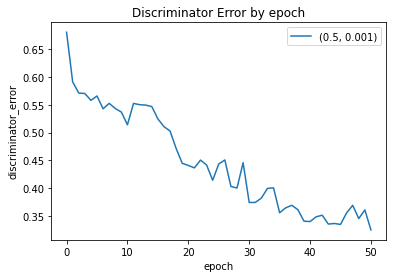

In [ ]:
# Discriminator
fig, ax = plt.subplots()

for i in l.keys():
  ax.plot(np.arange(0, EPOCHS+1), l[i]['dErr_history'])

ax.set(xlabel='epoch', ylabel='discriminator_error',
       title='Discriminator Error by epoch')
ax.legend([(0.5,1e-3), (0.5,1e-4), (0.1, 1e-3), (0.1,1e-4)])

plt.show()

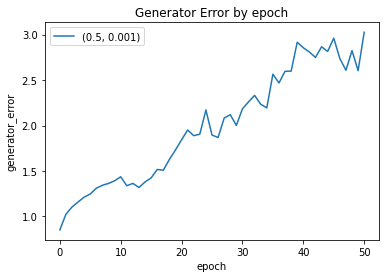

In [ ]:
# Generator
fig, ax = plt.subplots()

for i in l.keys():
  ax.plot(np.arange(0, EPOCHS+1), l[i]['gErr_history'])

ax.set(xlabel='epoch', ylabel='generator_error',
       title='Generator Error by epoch')
ax.legend([(0.5,1e-3), (0.5,1e-4), (0.1, 1e-3), (0.1,1e-4)])

plt.show()

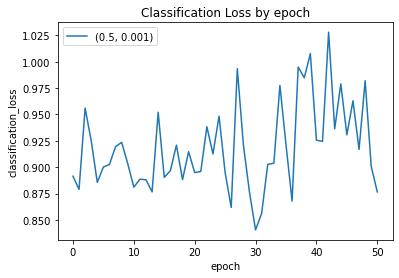

In [ ]:
# Classification
fig, ax = plt.subplots()

for i in l.keys():
  ax.plot(np.arange(0, EPOCHS+1), l[i]['closs_history'])

# blue, orange, green, red, violet

ax.set(xlabel='epoch', ylabel='classification_loss',
       title='Classification Loss by epoch')
ax.legend([(0.5,1e-3), (0.5,1e-4), (0.1, 1e-3), (0.1,1e-4)])

plt.show()

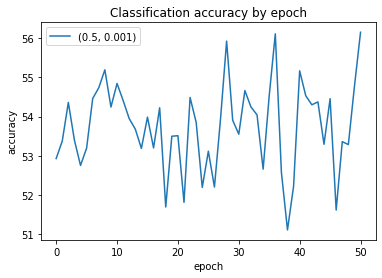

In [ ]:
# Accuracy
fig, ax = plt.subplots()

for i in l.keys():
  ax.plot(np.arange(0, EPOCHS+1), l[i]['accuracy_history'])

ax.set(xlabel='epoch', ylabel='accuracy',
       title='Classification accuracy by epoch')
ax.legend([(0.5,1e-3), (0.5,1e-4), (0.1, 1e-3), (0.1,1e-4)])

plt.show()

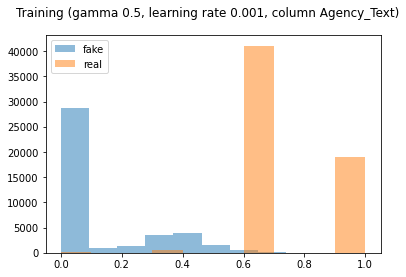

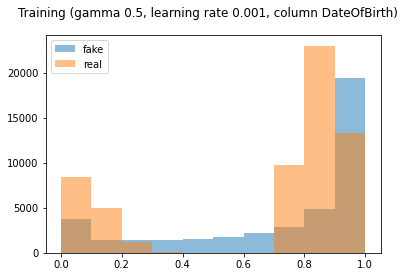

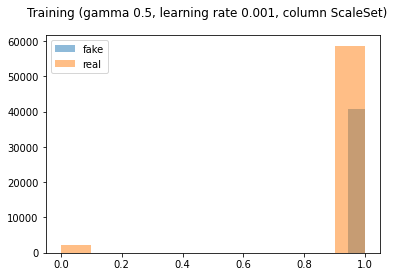

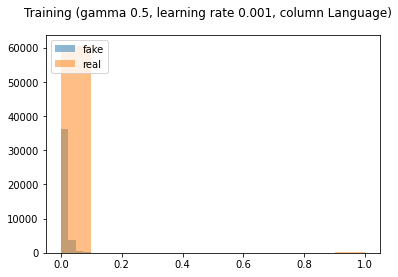

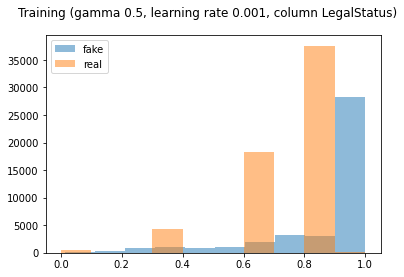

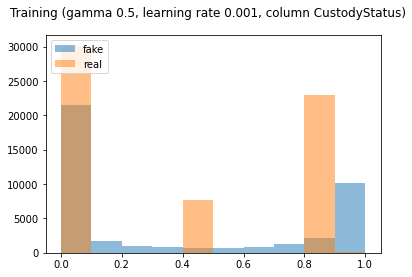

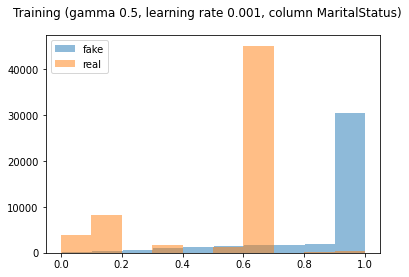

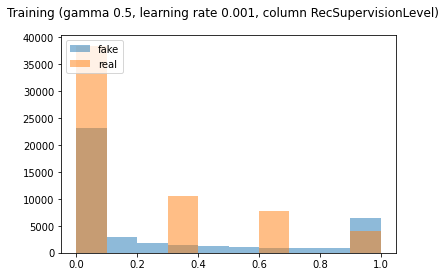

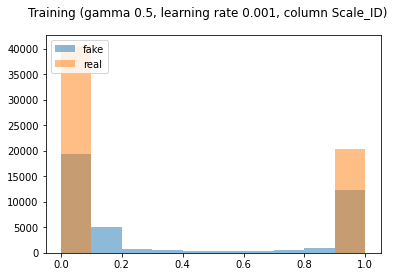

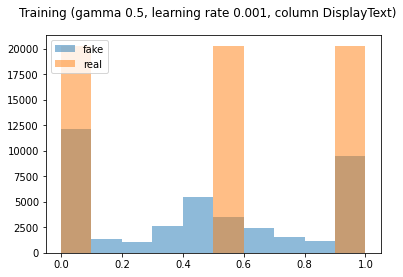

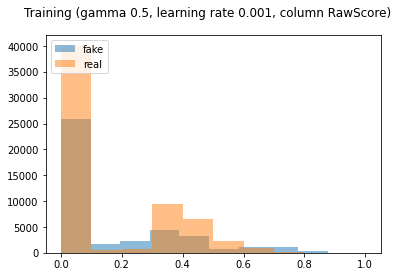

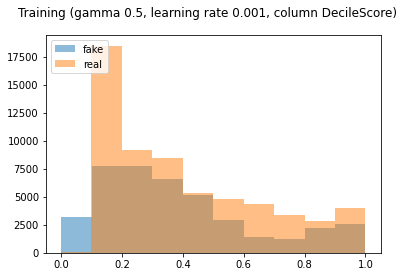

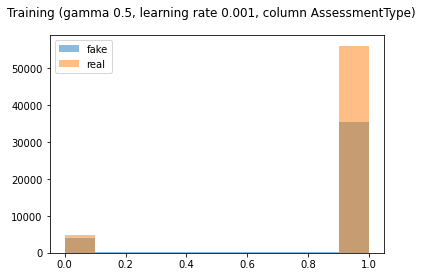

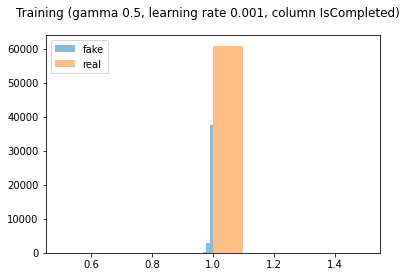

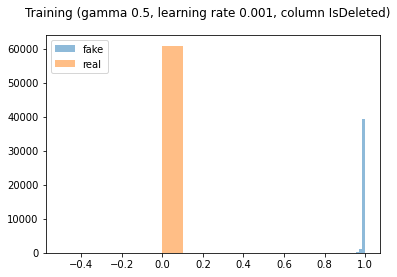

In [ ]:
for i in l.keys():
    gamma = l[i]['gamma']
    lr = l[i]['lr']

    for count, col in enumerate(compas.columns[:-1]):
        fig, ax = plt.subplots()

        ax.hist(l[i]['fake_dataset_end'].iloc[:,count], 10, label = 'fake', alpha = 0.5)
        ax.hist(compas.iloc[:,count], 10, label = 'real', alpha = 0.5)
        ax.legend(loc='upper left')

        fig.suptitle(f'Training (gamma {gamma}, learning rate {lr}, column {col})')

        plt.show()

##### weight decay

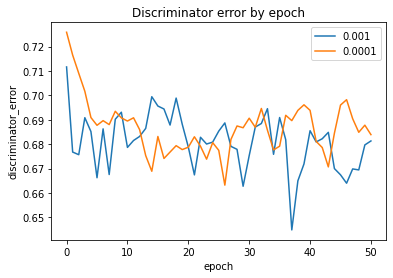

In [ ]:
# Discriminator
fig, ax = plt.subplots()

for i in l.keys():
    ax.plot(np.arange(0, EPOCHS+1), l[i]['dErr_history'])

ax.set(xlabel='epoch', ylabel='discriminator_error',
       title='Discriminator error by epoch')
ax.legend(l.keys())

plt.show()

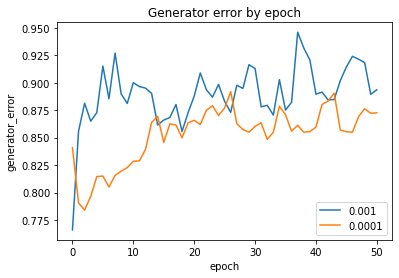

In [ ]:
# Generator
fig, ax = plt.subplots()

for i in l.keys():
    ax.plot(np.arange(0, EPOCHS+1), l[i]['gErr_history'])

ax.set(xlabel='epoch', ylabel='generator_error',
       title='Generator error by epoch')
ax.legend(l.keys())

plt.show()

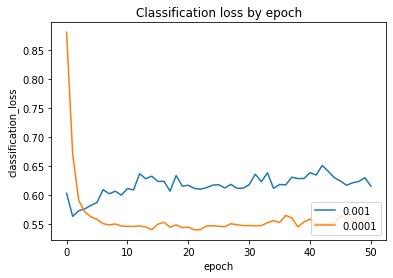

In [ ]:
# Classification
fig, ax = plt.subplots()

for i in l.keys():
    ax.plot(np.arange(0, EPOCHS+1), l[i]['closs_history'])

ax.set(xlabel='epoch', ylabel='classification_loss',
       title='Classification loss by epoch')
ax.legend(l.keys(), loc = "lower right")

plt.show()

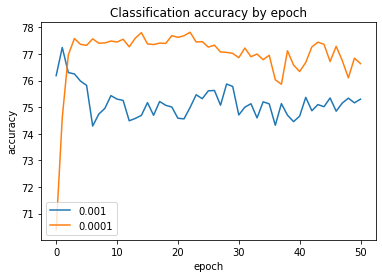

In [ ]:
# Accuracy
fig, ax = plt.subplots()

for i in l.keys():
    ax.plot(np.arange(0, EPOCHS+1), l[i]['accuracy_history'])

ax.set(xlabel='epoch', ylabel='accuracy',
       title='Classification accuracy by epoch')
ax.legend(l.keys(), loc = 'lower left')

plt.show()

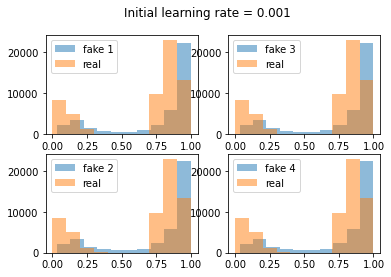

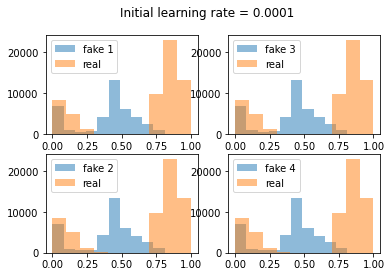

In [ ]:
for i in l.keys():
  names = [l[i]['fake_dataset_init'], l[i]['fake_dataset_mid'], 
           l[i]['fake_dataset_mid2'], l[i]['fake_dataset_end']]
  for nm in names:
    nm.columns = list(compas.columns)[:-1]
  fig, ax = plt.subplots(nrows=2, ncols=2)

  ax[0,0].hist(nm.DateOfBirth, 10, label = 'fake 1', alpha = 0.5)
  ax[0,0].hist(compas.DateOfBirth, 10, label = 'real', alpha = 0.5)
  ax[0,0].legend(loc='upper left')

  ax[1,0].hist(nm.DateOfBirth, 10, label = 'fake 2', alpha = 0.5)
  ax[1,0].hist(compas.DateOfBirth, 10, label = 'real', alpha = 0.5)
  ax[1,0].legend(loc='upper left')

  ax[0,1].hist(nm.DateOfBirth, 10, label = 'fake 3', alpha = 0.5)
  ax[0,1].hist(compas.DateOfBirth, 10, label = 'real', alpha = 0.5)
  ax[0,1].legend(loc='upper left')

  ax[1,1].hist(nm.DateOfBirth, 10, label = 'fake 4', alpha = 0.5)
  ax[1,1].hist(compas.DateOfBirth, 10, label = 'real', alpha = 0.5)
  ax[1,1].legend(loc='upper left')

  fig.suptitle(f'Initial learning rate = {i}')

  plt.show()

In [ ]:
print('---------------------------------------------------')
print('init')
print('---------------------------------------------------')
print(l[0]['fake_dataset_init'].Agency_Text[:6].values)
print(compas.Agency_Text[:6].values)
print('---------------------------------------------------')
print('mid')
print('---------------------------------------------------')
print(l[0]['fake_dataset_mid'].Agency_Text[:6].values)
print(compas.Agency_Text[:6].values)
print('---------------------------------------------------')
print('mid2')
print('---------------------------------------------------')
print(l[0]['fake_dataset_mid2'].Agency_Text[:6].values)
print(compas.Agency_Text[:6].values)
print('---------------------------------------------------')
print('end')
print('---------------------------------------------------')
print(l[0]['fake_dataset_end'].Agency_Text[:6].values)
print(compas.Agency_Text[:6].values)

---------------------------------------------------
init
---------------------------------------------------


KeyError: ignored

In [ ]:
print('---------------------------------------------------')
print('init')
print('---------------------------------------------------')
print(l[0]['fake_dataset_init'].Language[:6].values)
print(compas.Agency_Text[:6].values)
print('---------------------------------------------------')
print('mid')
print('---------------------------------------------------')
print(l[0]['fake_dataset_mid'].Language[:6].values)
print(compas.Agency_Text[:6].values)
print('---------------------------------------------------')
print('mid2')
print('---------------------------------------------------')
print(l[0]['fake_dataset_mid2'].Language[:6].values)
print(compas.Agency_Text[:6].values)
print('---------------------------------------------------')
print('end')
print('---------------------------------------------------')
print(l[0]['fake_dataset_end'].Language[:6].values)
print(compas.Agency_Text[:6].values)

##### weight decay

In [ ]:
np.array(l[0.001]['dErr_details']).shape

(51, 127)

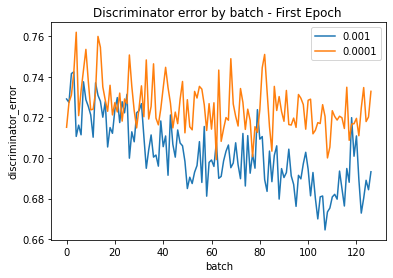

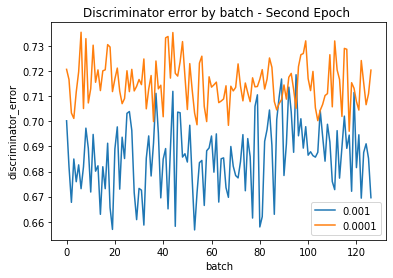

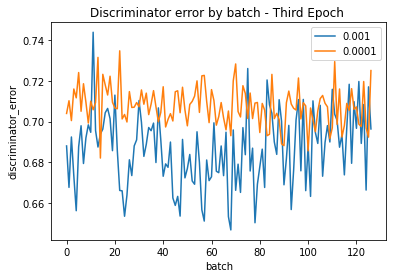

In [ ]:
# Discriminator
fig, ax = plt.subplots()

for i in l.keys():
    ax.plot(np.arange(0, 127), l[i]['dErr_details'][0])

ax.set(xlabel='batch', ylabel='discriminator_error',
       title='Discriminator error by batch - First Epoch ')
ax.legend(l.keys())

plt.show()

# Discriminator
fig, ax = plt.subplots()

for i in l.keys():
    ax.plot(np.arange(0, 127), l[i]['dErr_details'][1])

ax.set(xlabel='batch', ylabel='discriminator_error',
       title='Discriminator error by batch - Second Epoch ')
ax.legend(l.keys())

plt.show()

# Discriminator
fig, ax = plt.subplots()

for i in l.keys():
    ax.plot(np.arange(0, 127), l[i]['dErr_details'][2])

ax.set(xlabel='batch', ylabel='discriminator_error',
       title='Discriminator error by batch - Third Epoch ')
ax.legend(l.keys())

plt.show()

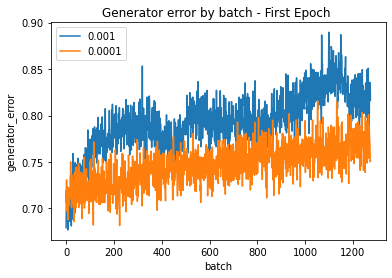

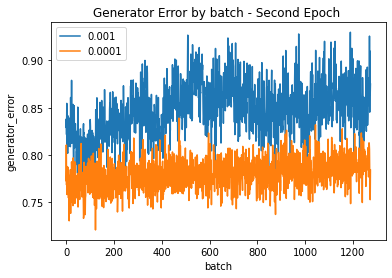

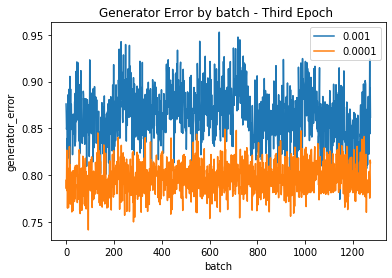

In [ ]:
# Discriminator
fig, ax = plt.subplots()

for i in l.keys():
    ax.plot(np.arange(0, 1274), l[i]['gErr_details'][0])

ax.set(xlabel='batch', ylabel='generator_error',
       title='Generator error by batch - First Epoch ')
ax.legend(l.keys())

plt.show()

# Discriminator
fig, ax = plt.subplots()

for i in l.keys():
    ax.plot(np.arange(0, 1274), l[i]['gErr_details'][1])

ax.set(xlabel='batch', ylabel='generator_error',
       title='Generator Error by batch - Second Epoch ')
ax.legend(l.keys())

plt.show()

# Discriminator
fig, ax = plt.subplots()

for i in l.keys():
    ax.plot(np.arange(0, 1274), l[i]['gErr_details'][2])

ax.set(xlabel='batch', ylabel='generator_error',
       title='Generator Error by batch - Third Epoch ')
ax.legend(l.keys())

plt.show()

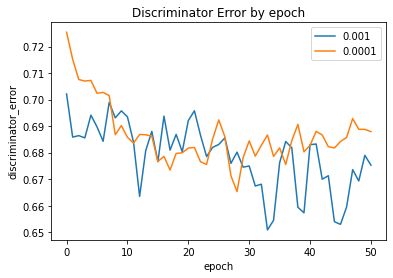

In [ ]:
# Discriminator
fig, ax = plt.subplots()

for i in l.keys():
    ax.plot(np.arange(0, EPOCHS+1), l[i]['dErr_history'])

ax.set(xlabel='epoch', ylabel='discriminator_error',
       title='Discriminator Error by epoch')
ax.legend(l.keys())

plt.show()

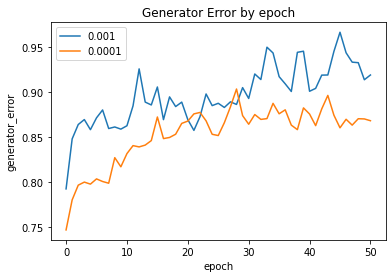

In [ ]:
# Generator
fig, ax = plt.subplots()

for i in l.keys():
  if i != 1e-2:
    ax.plot(np.arange(0, EPOCHS+1), l[i]['gErr_history'])

ax.set(xlabel='epoch', ylabel='generator_error',
       title='Generator Error by epoch')
ax.legend(l.keys())

plt.show()

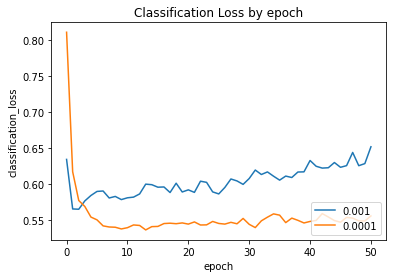

In [ ]:
# Classification
fig, ax = plt.subplots()

for i in l.keys():
  if i != 1e-2:
    ax.plot(np.arange(0, EPOCHS+1), l[i]['closs_history'])

# blue, orange, green, red, violet

ax.set(xlabel='epoch', ylabel='classification_loss',
       title='Classification Loss by epoch')
ax.legend(l.keys(), loc = "lower right")

plt.show()

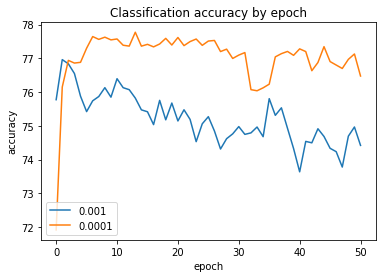

In [ ]:
# Accuracy
fig, ax = plt.subplots()

for i in l.keys():
  if i != 1e-2:
    ax.plot(np.arange(0, EPOCHS+1), l[i]['accuracy_history'])

ax.set(xlabel='epoch', ylabel='accuracy',
       title='Classification accuracy by epoch')
ax.legend(l.keys(), loc = 'lower left')

plt.show()

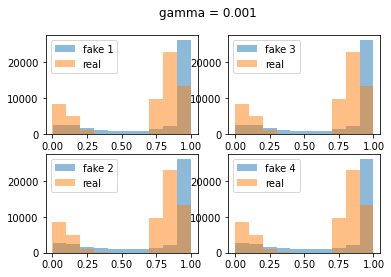

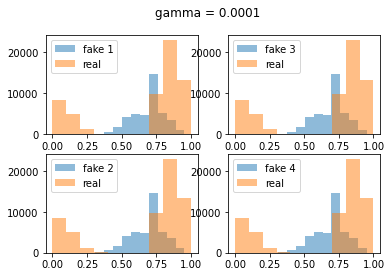

In [ ]:
for i in l.keys():
  names = [l[i]['fake_dataset_init'], l[i]['fake_dataset_mid'], 
           l[i]['fake_dataset_mid2'], l[i]['fake_dataset_end']]
  for nm in names:
    nm.columns = list(compas.columns)[:-1]
  fig, ax = plt.subplots(nrows=2, ncols=2)

  ax[0,0].hist(nm.DateOfBirth, 10, label = 'fake 1', alpha = 0.5)
  ax[0,0].hist(compas.DateOfBirth, 10, label = 'real', alpha = 0.5)
  ax[0,0].legend(loc='upper left')

  ax[1,0].hist(nm.DateOfBirth, 10, label = 'fake 2', alpha = 0.5)
  ax[1,0].hist(compas.DateOfBirth, 10, label = 'real', alpha = 0.5)
  ax[1,0].legend(loc='upper left')

  ax[0,1].hist(nm.DateOfBirth, 10, label = 'fake 3', alpha = 0.5)
  ax[0,1].hist(compas.DateOfBirth, 10, label = 'real', alpha = 0.5)
  ax[0,1].legend(loc='upper left')

  ax[1,1].hist(nm.DateOfBirth, 10, label = 'fake 4', alpha = 0.5)
  ax[1,1].hist(compas.DateOfBirth, 10, label = 'real', alpha = 0.5)
  ax[1,1].legend(loc='upper left')

  fig.suptitle(f'gamma = {i}')

  plt.show()

In [ ]:
print('---------------------------------------------------')
print('init')
print('---------------------------------------------------')
print(l[0]['fake_dataset_init'].Agency_Text[:6].values)
print(compas.Agency_Text[:6].values)
print('---------------------------------------------------')
print('mid')
print('---------------------------------------------------')
print(l[0]['fake_dataset_mid'].Agency_Text[:6].values)
print(compas.Agency_Text[:6].values)
print('---------------------------------------------------')
print('mid2')
print('---------------------------------------------------')
print(l[0]['fake_dataset_mid2'].Agency_Text[:6].values)
print(compas.Agency_Text[:6].values)
print('---------------------------------------------------')
print('end')
print('---------------------------------------------------')
print(l[0]['fake_dataset_end'].Agency_Text[:6].values)
print(compas.Agency_Text[:6].values)

---------------------------------------------------
init
---------------------------------------------------


KeyError: ignored

In [ ]:
print('---------------------------------------------------')
print('init')
print('---------------------------------------------------')
print(l[0]['fake_dataset_init'].Language[:6].values)
print(compas.Agency_Text[:6].values)
print('---------------------------------------------------')
print('mid')
print('---------------------------------------------------')
print(l[0]['fake_dataset_mid'].Language[:6].values)
print(compas.Agency_Text[:6].values)
print('---------------------------------------------------')
print('mid2')
print('---------------------------------------------------')
print(l[0]['fake_dataset_mid2'].Language[:6].values)
print(compas.Agency_Text[:6].values)
print('---------------------------------------------------')
print('end')
print('---------------------------------------------------')
print(l[0]['fake_dataset_end'].Language[:6].values)
print(compas.Agency_Text[:6].values)

#### lr = 0.0001

##### weight decay

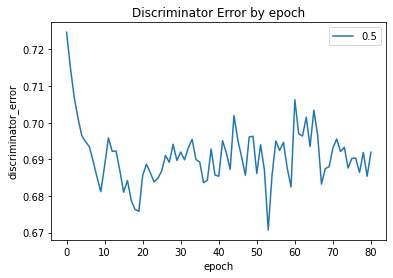

In [ ]:
# Discriminator
fig, ax = plt.subplots()

for i in l.keys():
  if i != 1e-2:
    ax.plot(np.arange(0, EPOCHS+1), l[i]['dErr_history'])

ax.set(xlabel='epoch', ylabel='discriminator_error',
       title='Discriminator Error by epoch')
ax.legend(l.keys())

plt.show()

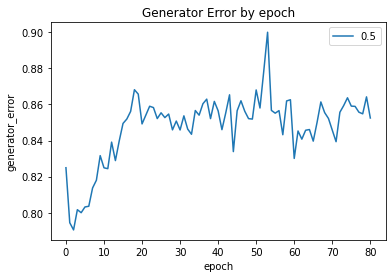

In [ ]:
# Generator
fig, ax = plt.subplots()

for i in l.keys():
  if i != 1e-2:
    ax.plot(np.arange(0, EPOCHS+1), l[i]['gErr_history'])

ax.set(xlabel='epoch', ylabel='generator_error',
       title='Generator Error by epoch')
ax.legend(l.keys())

plt.show()

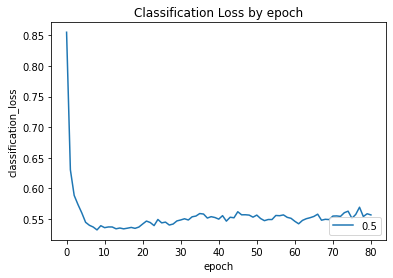

In [ ]:
# Classification
fig, ax = plt.subplots()

for i in l.keys():
  if i != 1e-2:
    ax.plot(np.arange(0, EPOCHS+1), l[i]['closs_history'])

# blue, orange, green, red, violet

ax.set(xlabel='epoch', ylabel='classification_loss',
       title='Classification Loss by epoch')
ax.legend(l.keys(), loc = "lower right")

plt.show()

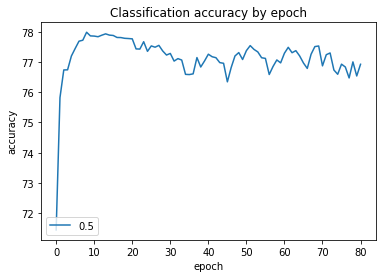

In [ ]:
# Accuracy
fig, ax = plt.subplots()

for i in l.keys():
  if i != 1e-2:
    ax.plot(np.arange(0, EPOCHS+1), l[i]['accuracy_history'])

ax.set(xlabel='epoch', ylabel='accuracy',
       title='Classification accuracy by epoch')
ax.legend(l.keys(), loc = 'lower left')

plt.show()

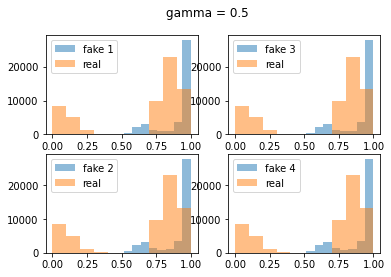

In [ ]:
for i in l.keys():
  names = [l[i]['fake_dataset_init'], l[i]['fake_dataset_mid'], 
           l[i]['fake_dataset_mid2'], l[i]['fake_dataset_end']]
  for nm in names:
    nm.columns = list(compas.columns)[:-1]
  fig, ax = plt.subplots(nrows=2, ncols=2)

  ax[0,0].hist(nm.DateOfBirth, 10, label = 'fake 1', alpha = 0.5)
  ax[0,0].hist(compas.DateOfBirth, 10, label = 'real', alpha = 0.5)
  ax[0,0].legend(loc='upper left')

  ax[1,0].hist(nm.DateOfBirth, 10, label = 'fake 2', alpha = 0.5)
  ax[1,0].hist(compas.DateOfBirth, 10, label = 'real', alpha = 0.5)
  ax[1,0].legend(loc='upper left')

  ax[0,1].hist(nm.DateOfBirth, 10, label = 'fake 3', alpha = 0.5)
  ax[0,1].hist(compas.DateOfBirth, 10, label = 'real', alpha = 0.5)
  ax[0,1].legend(loc='upper left')

  ax[1,1].hist(nm.DateOfBirth, 10, label = 'fake 4', alpha = 0.5)
  ax[1,1].hist(compas.DateOfBirth, 10, label = 'real', alpha = 0.5)
  ax[1,1].legend(loc='upper left')

  fig.suptitle(f'gamma = {i}')

  plt.show()

In [ ]:
print('---------------------------------------------------')
print('init')
print('---------------------------------------------------')
print(l[0]['fake_dataset_init'].Agency_Text[:6].values)
print(compas.Agency_Text[:6].values)
print('---------------------------------------------------')
print('mid')
print('---------------------------------------------------')
print(l[0]['fake_dataset_mid'].Agency_Text[:6].values)
print(compas.Agency_Text[:6].values)
print('---------------------------------------------------')
print('mid2')
print('---------------------------------------------------')
print(l[0]['fake_dataset_mid2'].Agency_Text[:6].values)
print(compas.Agency_Text[:6].values)
print('---------------------------------------------------')
print('end')
print('---------------------------------------------------')
print(l[0]['fake_dataset_end'].Agency_Text[:6].values)
print(compas.Agency_Text[:6].values)

---------------------------------------------------
init
---------------------------------------------------


KeyError: ignored

In [ ]:
print('---------------------------------------------------')
print('init')
print('---------------------------------------------------')
print(l[0]['fake_dataset_init'].Language[:6].values)
print(compas.Agency_Text[:6].values)
print('---------------------------------------------------')
print('mid')
print('---------------------------------------------------')
print(l[0]['fake_dataset_mid'].Language[:6].values)
print(compas.Agency_Text[:6].values)
print('---------------------------------------------------')
print('mid2')
print('---------------------------------------------------')
print(l[0]['fake_dataset_mid2'].Language[:6].values)
print(compas.Agency_Text[:6].values)
print('---------------------------------------------------')
print('end')
print('---------------------------------------------------')
print(l[0]['fake_dataset_end'].Language[:6].values)
print(compas.Agency_Text[:6].values)

##### weight decay

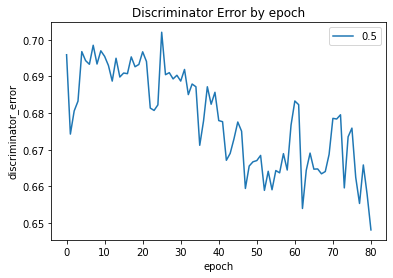

In [ ]:
# Discriminator
fig, ax = plt.subplots()

for i in l.keys():
  if i != 1e-2:
    ax.plot(np.arange(0, EPOCHS+1), l[i]['dErr_history'])

ax.set(xlabel='epoch', ylabel='discriminator_error',
       title='Discriminator Error by epoch')
ax.legend(l.keys())

plt.show()

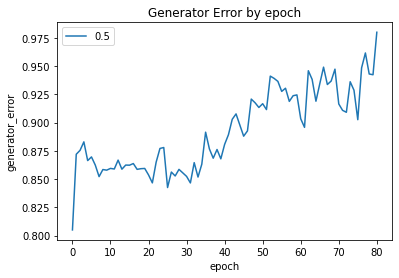

In [ ]:
# Generator
fig, ax = plt.subplots()

for i in l.keys():
  if i != 1e-2:
    ax.plot(np.arange(0, EPOCHS+1), l[i]['gErr_history'])

ax.set(xlabel='epoch', ylabel='generator_error',
       title='Generator Error by epoch')
ax.legend(l.keys())

plt.show()

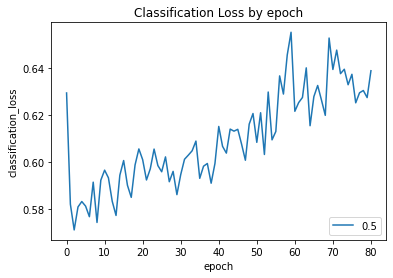

In [ ]:
# Classification
fig, ax = plt.subplots()

for i in l.keys():
  if i != 1e-2:
    ax.plot(np.arange(0, EPOCHS+1), l[i]['closs_history'])

# blue, orange, green, red, violet

ax.set(xlabel='epoch', ylabel='classification_loss',
       title='Classification Loss by epoch')
ax.legend(l.keys(), loc = "lower right")

plt.show()

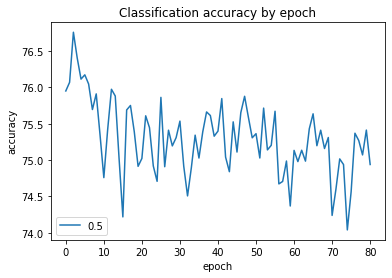

In [ ]:
# Accuracy
fig, ax = plt.subplots()

for i in l.keys():
  if i != 1e-2:
    ax.plot(np.arange(0, EPOCHS+1), l[i]['accuracy_history'])

ax.set(xlabel='epoch', ylabel='accuracy',
       title='Classification accuracy by epoch')
ax.legend(l.keys(), loc = 'lower left')

plt.show()

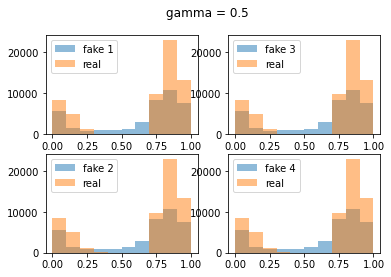

In [ ]:
for i in l.keys():
  names = [l[i]['fake_dataset_init'], l[i]['fake_dataset_mid'], 
           l[i]['fake_dataset_mid2'], l[i]['fake_dataset_end']]
  for nm in names:
    nm.columns = list(compas.columns)[:-1]
  fig, ax = plt.subplots(nrows=2, ncols=2)

  ax[0,0].hist(nm.DateOfBirth, 10, label = 'fake 1', alpha = 0.5)
  ax[0,0].hist(compas.DateOfBirth, 10, label = 'real', alpha = 0.5)
  ax[0,0].legend(loc='upper left')

  ax[1,0].hist(nm.DateOfBirth, 10, label = 'fake 2', alpha = 0.5)
  ax[1,0].hist(compas.DateOfBirth, 10, label = 'real', alpha = 0.5)
  ax[1,0].legend(loc='upper left')

  ax[0,1].hist(nm.DateOfBirth, 10, label = 'fake 3', alpha = 0.5)
  ax[0,1].hist(compas.DateOfBirth, 10, label = 'real', alpha = 0.5)
  ax[0,1].legend(loc='upper left')

  ax[1,1].hist(nm.DateOfBirth, 10, label = 'fake 4', alpha = 0.5)
  ax[1,1].hist(compas.DateOfBirth, 10, label = 'real', alpha = 0.5)
  ax[1,1].legend(loc='upper left')

  fig.suptitle(f'gamma = {i}')

  plt.show()

In [ ]:
print('---------------------------------------------------')
print('init')
print('---------------------------------------------------')
print(l[0]['fake_dataset_init'].Agency_Text[:6].values)
print(compas.Agency_Text[:6].values)
print('---------------------------------------------------')
print('mid')
print('---------------------------------------------------')
print(l[0]['fake_dataset_mid'].Agency_Text[:6].values)
print(compas.Agency_Text[:6].values)
print('---------------------------------------------------')
print('mid2')
print('---------------------------------------------------')
print(l[0]['fake_dataset_mid2'].Agency_Text[:6].values)
print(compas.Agency_Text[:6].values)
print('---------------------------------------------------')
print('end')
print('---------------------------------------------------')
print(l[0]['fake_dataset_end'].Agency_Text[:6].values)
print(compas.Agency_Text[:6].values)

---------------------------------------------------
init
---------------------------------------------------


KeyError: ignored

In [ ]:
print('---------------------------------------------------')
print('init')
print('---------------------------------------------------')
print(l[0]['fake_dataset_init'].Language[:6].values)
print(compas.Agency_Text[:6].values)
print('---------------------------------------------------')
print('mid')
print('---------------------------------------------------')
print(l[0]['fake_dataset_mid'].Language[:6].values)
print(compas.Agency_Text[:6].values)
print('---------------------------------------------------')
print('mid2')
print('---------------------------------------------------')
print(l[0]['fake_dataset_mid2'].Language[:6].values)
print(compas.Agency_Text[:6].values)
print('---------------------------------------------------')
print('end')
print('---------------------------------------------------')
print(l[0]['fake_dataset_end'].Language[:6].values)
print(compas.Agency_Text[:6].values)

##### weight decay

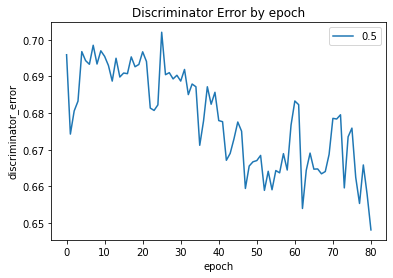

In [ ]:
# Discriminator
fig, ax = plt.subplots()

for i in l.keys():
  if i != 1e-2:
    ax.plot(np.arange(0, EPOCHS+1), l[i]['dErr_history'])

ax.set(xlabel='epoch', ylabel='discriminator_error',
       title='Discriminator Error by epoch')
ax.legend(l.keys())

plt.show()

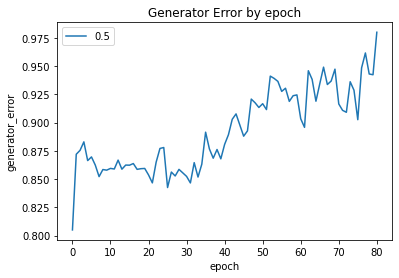

In [ ]:
# Generator
fig, ax = plt.subplots()

for i in l.keys():
  if i != 1e-2:
    ax.plot(np.arange(0, EPOCHS+1), l[i]['gErr_history'])

ax.set(xlabel='epoch', ylabel='generator_error',
       title='Generator Error by epoch')
ax.legend(l.keys())

plt.show()

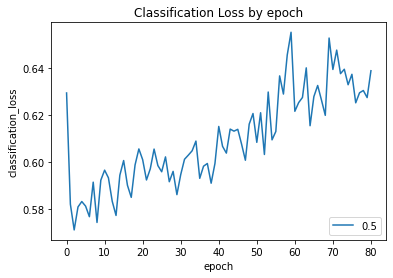

In [ ]:
# Classification
fig, ax = plt.subplots()

for i in l.keys():
  if i != 1e-2:
    ax.plot(np.arange(0, EPOCHS+1), l[i]['closs_history'])

# blue, orange, green, red, violet

ax.set(xlabel='epoch', ylabel='classification_loss',
       title='Classification Loss by epoch')
ax.legend(l.keys(), loc = "lower right")

plt.show()

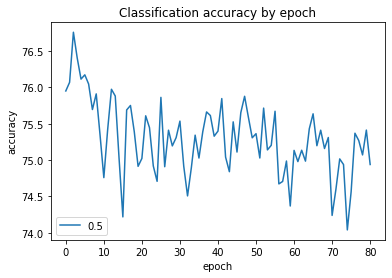

In [ ]:
# Accuracy
fig, ax = plt.subplots()

for i in l.keys():
  if i != 1e-2:
    ax.plot(np.arange(0, EPOCHS+1), l[i]['accuracy_history'])

ax.set(xlabel='epoch', ylabel='accuracy',
       title='Classification accuracy by epoch')
ax.legend(l.keys(), loc = 'lower left')

plt.show()

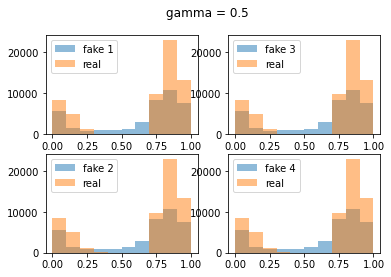

In [ ]:
for i in l.keys():
  names = [l[i]['fake_dataset_init'], l[i]['fake_dataset_mid'], 
           l[i]['fake_dataset_mid2'], l[i]['fake_dataset_end']]
  for nm in names:
    nm.columns = list(compas.columns)[:-1]
  fig, ax = plt.subplots(nrows=2, ncols=2)

  ax[0,0].hist(nm.DateOfBirth, 10, label = 'fake 1', alpha = 0.5)
  ax[0,0].hist(compas.DateOfBirth, 10, label = 'real', alpha = 0.5)
  ax[0,0].legend(loc='upper left')

  ax[1,0].hist(nm.DateOfBirth, 10, label = 'fake 2', alpha = 0.5)
  ax[1,0].hist(compas.DateOfBirth, 10, label = 'real', alpha = 0.5)
  ax[1,0].legend(loc='upper left')

  ax[0,1].hist(nm.DateOfBirth, 10, label = 'fake 3', alpha = 0.5)
  ax[0,1].hist(compas.DateOfBirth, 10, label = 'real', alpha = 0.5)
  ax[0,1].legend(loc='upper left')

  ax[1,1].hist(nm.DateOfBirth, 10, label = 'fake 4', alpha = 0.5)
  ax[1,1].hist(compas.DateOfBirth, 10, label = 'real', alpha = 0.5)
  ax[1,1].legend(loc='upper left')

  fig.suptitle(f'gamma = {i}')

  plt.show()

In [ ]:
print('---------------------------------------------------')
print('init')
print('---------------------------------------------------')
print(l[0]['fake_dataset_init'].Agency_Text[:6].values)
print(compas.Agency_Text[:6].values)
print('---------------------------------------------------')
print('mid')
print('---------------------------------------------------')
print(l[0]['fake_dataset_mid'].Agency_Text[:6].values)
print(compas.Agency_Text[:6].values)
print('---------------------------------------------------')
print('mid2')
print('---------------------------------------------------')
print(l[0]['fake_dataset_mid2'].Agency_Text[:6].values)
print(compas.Agency_Text[:6].values)
print('---------------------------------------------------')
print('end')
print('---------------------------------------------------')
print(l[0]['fake_dataset_end'].Agency_Text[:6].values)
print(compas.Agency_Text[:6].values)

---------------------------------------------------
init
---------------------------------------------------


KeyError: ignored

In [ ]:
print('---------------------------------------------------')
print('init')
print('---------------------------------------------------')
print(l[0]['fake_dataset_init'].Language[:6].values)
print(compas.Agency_Text[:6].values)
print('---------------------------------------------------')
print('mid')
print('---------------------------------------------------')
print(l[0]['fake_dataset_mid'].Language[:6].values)
print(compas.Agency_Text[:6].values)
print('---------------------------------------------------')
print('mid2')
print('---------------------------------------------------')
print(l[0]['fake_dataset_mid2'].Language[:6].values)
print(compas.Agency_Text[:6].values)
print('---------------------------------------------------')
print('end')
print('---------------------------------------------------')
print(l[0]['fake_dataset_end'].Language[:6].values)
print(compas.Agency_Text[:6].values)

### FairGAN

In [ ]:
def train_discriminator_fair(optimizer_real, optimizer_fair, real_data, fake_data, sensitive_data, original_dim,  penalty = 0.01):
    N = real_data.size(0)

    # 1.1 Train on Real Data
    prediction_real = discriminator_real(real_data)
    error_real = loss(prediction_real, 0.9*ones_target(N))

    # 1.2 Train on Fake Data
    prediction_fake = discriminator_real(fake_data[:,:original_dim])
    error_fake = loss(prediction_fake, zeros_target(N))
    
    # 1.3 L2 regularization
    l2_parameters = []
    for parameter in discriminator_real.parameters():
        l2_parameters.append(parameter.view(-1))
    l2 = 1/N * penalty * torch.square(torch.cat(l2_parameters)).sum()

    d_loss_real = (error_real + error_fake)/2 + l2
    d_loss_real.backward()
    optimizer_real.step()

    # Fairness
    sensitive_real = discriminator_fair(fake_data)
    err_sensitive = loss(sensitive_real, sensitive_data.unsqueeze(1))

    err_sensitive.backward()
    optimizer_fair.step()

    return d_loss_real, err_sensitive


def train_generator_fair(decoder_optimizer, encoder_optimizer, fake_data, target, original_dim, gam, delt):
    N = fake_data.size(0)

    # Real vs Fake
    prediction_real = discriminator_real(fake_data[:,:original_dim])
    g_error_real = loss(prediction_real, ones_target(N))

    # Fairness
    prediction_fair = discriminator_fair(fake_data)
    g_error_fair = loss(prediction_fair, zeros_target(N))

    #Classificator
    fake_labels = classifier(fake_data).reshape(-1)
    #fake_labels = 1-fake_labels
    c_loss = loss(fake_labels, target)
    acc = binary_acc(fake_labels, target)
    
    #Total Error
    error = g_error_real + delt * g_error_fair + gam * c_loss
    error.backward()
    decoder_optimizer.step()
    encoder_optimizer.step()
    
    return g_error_real, g_error_fair, c_loss, acc

##### cross-validation

In [ ]:
loss = nn.BCEWithLogitsLoss()

l = {1: {'gamma': 0.0001, 'delta': 100, 'val_accuracy': [], 'val_acc': 0, 'total': 0, 'fair_acc':0, 'fair_accuracy': []},
     2: {'gamma': 0.0001, 'delta': 0.5, 'val_accuracy': [], 'val_acc': 0, 'total': 0, 'fair_acc':0, 'fair_accuracy': []},
     3: {'gamma': 0.0001, 'delta': 0.0001,'val_accuracy': [], 'val_acc': 0, 'total': 0, 'fair_acc':0, 'fair_accuracy': []},
     4: {'gamma': 0.01, 'delta': 10,'val_accuracy': [], 'val_acc': 0, 'total': 0, 'fair_acc':0, 'fair_accuracy': []},
     5: {'gamma': 0.01, 'delta': 0.5,'val_accuracy': [], 'val_acc': 0, 'total': 0, 'fair_acc':0, 'fair_accuracy': []},
     6: {'gamma': 0.01, 'delta': 0.0001,'val_accuracy': [], 'val_acc': 0, 'total': 0, 'fair_acc':0, 'fair_accuracy': []},
     7: {'gamma': 0.5, 'delta': 100,'val_accuracy': [], 'val_acc': 0, 'total': 0, 'fair_acc':0, 'fair_accuracy': []},
     8: {'gamma': 0.5, 'delta': 0.5,'val_accuracy': [], 'val_acc': 0, 'total': 0, 'fair_acc':0, 'fair_accuracy': []},
     9: {'gamma': 0.5, 'delta': 0.01,'val_accuracy': [], 'val_acc': 0, 'total': 0, 'fair_acc':0, 'fair_accuracy': []},
     10: {'gamma': 100, 'delta': 100,'val_accuracy': [], 'val_acc': 0, 'total': 0, 'fair_acc':0, 'fair_accuracy': []},
     11: {'gamma': 100, 'delta': 0.5,'val_accuracy': [], 'val_acc': 0, 'total': 0, 'fair_acc':0, 'fair_accuracy': []},
     12: {'gamma': 100, 'delta': 0.01,'val_accuracy': [], 'val_acc': 0, 'total': 0, 'fair_acc':0, 'fair_accuracy': []}}

In [ ]:
# Configuration options
k_folds = 5
num_epochs = 20


for ki in l.keys():
  results = {}
  results2 = {}

  gam = l[ki]['gamma']
  delt = l[ki]['delta']

  kfold = KFold(n_splits=k_folds, shuffle=True)
  for fold, (train_ids, test_ids) in enumerate(kfold.split(compas)):
    
    # Print
    print(f'FOLD {fold}')
    print('--------------------------------')

    # Sample elements randomly from a given list of ids, no replacement.
    x_train = compas.iloc[train_ids, 0:-1]
    y_train = compas.iloc[train_ids, -1]
    x_test = compas.iloc[test_ids, 0:-1]
    y_test = compas.iloc[test_ids, -1]


    train_data = trainData(torch.FloatTensor(x_train.values), torch.FloatTensor(y_train.values))
    test_data = trainData(torch.FloatTensor(x_test.values), torch.FloatTensor(y_test.values))
    train_loader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE)
    test_loader = DataLoader(dataset=test_data, batch_size=8, drop_last=True)

    classifier = binaryClassification(15)
    classifier.load_state_dict(torch.load(dir+'model_3'))
    preprocessing = pre_generator(0, 15, 15) #encoder
    generator = VAE_generator(15, 15) #decoder
    discriminator_real = binaryClassification(15)
    discriminator_fair = binaryClassification(15)

    preproc_optimizer = optim.Adam(preprocessing.parameters(), lr=1e-3, betas = (0,0.99))
    g_optimizer = optim.Adam(generator.parameters(), lr=1e-3, betas = (0, 0.99))
    d_optimizer_1 = optim.Adam(discriminator_real.parameters(), lr=1e-3, betas = (0, 0.99))
    d_optimizer_2 = optim.Adam(discriminator_fair.parameters(), lr=1e-3, betas = (0, 0.99))


    for epoch in range(num_epochs+1):
        epoch_loss = 0
        epoch_acc = 0
        epoch_gErr_real = []
        epoch_gErr_fair = []
        epoch_dErr_real = []
        epoch_dErr_fair = []
        for n_batch, (real_batch, labels) in enumerate(train_loader):
            N = real_batch.size(0)
            d_optimizer_1.zero_grad()
            d_optimizer_2.zero_grad()
            g_optimizer.zero_grad()
            preproc_optimizer.zero_grad() 
            # 1. Train Discriminator
            sensitive_batch = real_batch[:,-1]
            real_batch=real_batch[:,0:-1]
            mu,log_var = preprocessing(real_batch)
            fake_data = generator(mu,log_var)
            fak_data = fake_data.detach()

            if n_batch%10==9:
              d_error_real, d_error_fair = train_discriminator_fair(d_optimizer_1, d_optimizer_2, real_batch, fak_data, sensitive_batch)
              epoch_dErr_real.append(d_error_real.item())
              epoch_dErr_fair.append(d_error_fair.item())

            # 2. Train Generator
            g_error_real, g_error_fair, c_loss, acc = train_generator_fair(g_optimizer, preproc_optimizer, fake_data, labels, gam=gam, delt=delt)
            epoch_loss += c_loss.item()
            epoch_acc += acc.item()
            epoch_gErr_real.append(g_error_real.item())
            epoch_gErr_fair.append(g_error_fair.item())

        print(f'Epoch: {epoch+0:03} | D_Error_Real: {sum(epoch_dErr_real)/(len(epoch_dErr_real)):.4f} | D_Error_Fair: {sum(epoch_dErr_fair)/(len(epoch_dErr_fair)):.4f}| G_Error_Real: {sum(epoch_gErr_real)/len(train_loader):.4f} | G_Error_Fair: {sum(epoch_gErr_fair)/len(train_loader):.4f}')
        print(f'Epoch: {epoch+0:03} | Loss: {epoch_loss/len(train_loader):.5f} | Acc: {epoch_acc/len(train_loader):.3f}')
        print('Starting testing')

        # Validation
        if epoch == num_epochs:
          l[ki]['val_acc'] = 0
          l[ki]['total'] = 0
          l[ki]['fair_acc'] = 0
          with torch.no_grad():
              for X_batch, y_batch in test_loader:
                  N = X_batch.size(0)
                  sensitive_batch = X_batch[:,-1]
                  real_batch = X_batch[:,0:-1]

                  mu,log_var = preprocessing(real_batch)
                  fake_batch = generator(mu,log_var)
                  output = classifier(fake_batch)
                  acc = binary_acc(output, y_batch.unsqueeze(1))

                  sensitive_real = discriminator_fair(fake_batch)
                  acc_sensitive = binary_acc(sensitive_real, sensitive_batch.unsqueeze(1))


                  # results
                  l[ki]['val_acc'] += acc.item()
                  l[ki]['total'] += 1
                  l[ki]['fair_acc'] += acc_sensitive.item()

                          # Print accuracy
              print('Accuracy for fold %d: %d %%' % (fold, l[ki]['val_acc']/l[ki]['total']))
              print('Fairness accuracy for fold %d: %d %%' % (fold, l[ki]['fair_acc']/l[ki]['total']))
              print('--------------------------------')
              results[fold] = l[ki]['val_acc']/l[ki]['total']
              results2[fold] = l[ki]['fair_acc']/l[ki]['total']
    
  # Print fold results
  print(f'K-FOLD CROSS VALIDATION RESULTS FOR {k_folds} FOLDS')
  print('--------------------------------')
  count = 0.0
  for key, value in results.items():
    print(f'Fold {key}: {value} %')
    count += value
  print(f'Average: {count/len(results.items())} %')

  l[ki]['val_accuracy'] = count/len(results.items())

    # Print fold results
  print(f'K-FOLD CROSS VALIDATION RESULTS FOR {k_folds} FOLDS')
  print('--------------------------------')
  count = 0.0
  for key, value in results2.items():
    print(f'Fold {key}: {value} %')
    count += value
  print(f'Average: {count/len(results2.items())} %')

  l[ki]['fair_accuracy'] = count/len(results2.items())



##### Plots Fair

In [ ]:
with open(dir + 'fairgan.pkl', 'wb') as f:
    pickle.dump(l, f)

In [ ]:
l[1]['val_accuracy']

74.42813938198553

In [ ]:
for i in l.keys():
  print('gamma', l[i]['gamma'], 'delta', l[i]['delta'], l[i]['val_accuracy'], l[i]['fair_accuracy'])

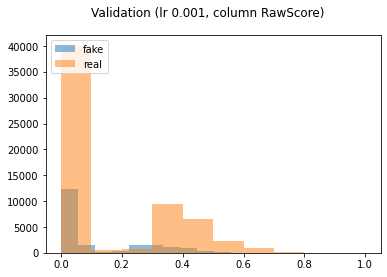

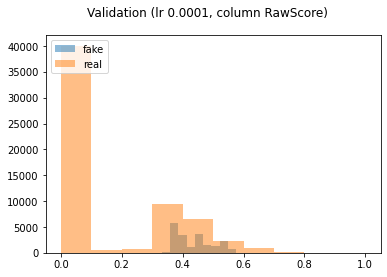

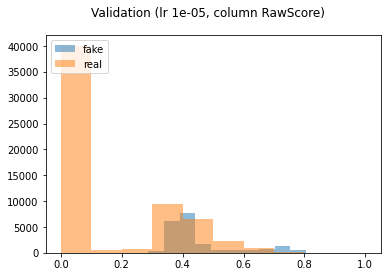

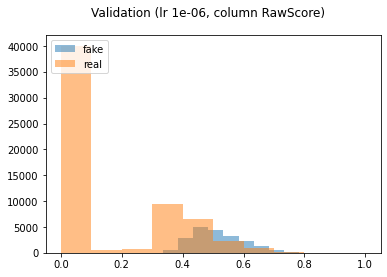

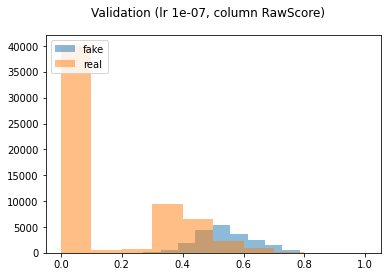

In [ ]:
for i in l.keys():

    for count, col in enumerate(compas.columns[:-1]):
        if col == 'RawScore':
            fig, ax = plt.subplots()

            ax.hist(l[i]['val_set'].iloc[:,count], 10, label = 'fake', alpha = 0.5)
            ax.hist(compas.iloc[:,count], 10, label = 'real', alpha = 0.5)
            ax.legend(loc='upper left')

            fig.suptitle(f'Validation (lr {i}, column {col})')

            plt.show()

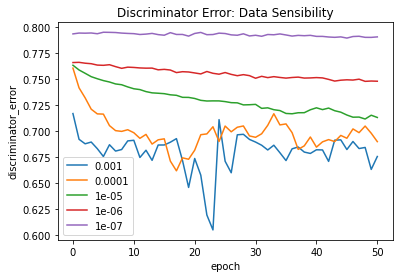

In [ ]:
# Discriminator
fig, ax = plt.subplots()

for i in l.keys():
  ax.plot(np.arange(0, EPOCHS+1), l[i]['dErr_real_history'])

ax.set(xlabel='epoch', ylabel='discriminator_error',
       title='Discriminator Error: Data Sensibility')
ax.legend(l.keys())

plt.show()

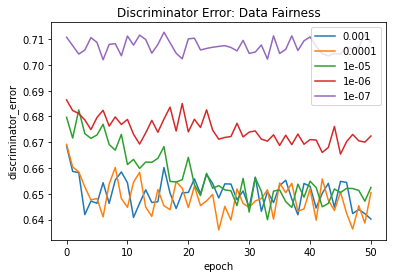

In [ ]:
# Discriminator
fig, ax = plt.subplots()

for i in l.keys():
  ax.plot(np.arange(0, EPOCHS+1), l[i]['dErr_fair_history'])

ax.set(xlabel='epoch', ylabel='discriminator_error',
       title='Discriminator Error: Data Fairness')
ax.legend(l.keys())

plt.show()

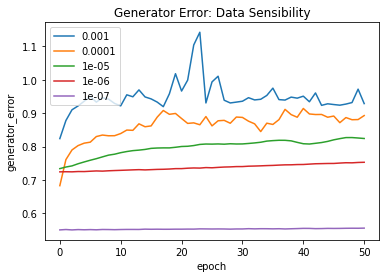

In [ ]:
# Generator
fig, ax = plt.subplots()

for i in l.keys():
  ax.plot(np.arange(0, EPOCHS+1), l[i]['gErr_real_history'])

ax.set(xlabel='epoch', ylabel='generator_error',
       title='Generator Error: Data Sensibility')
ax.legend(l.keys())

plt.show()

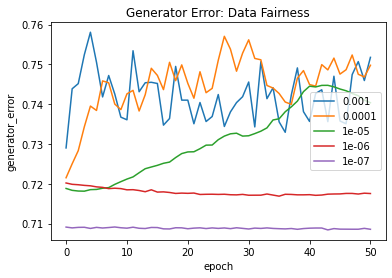

In [ ]:
# Generator
fig, ax = plt.subplots()

for i in l.keys():
  ax.plot(np.arange(0, EPOCHS+1), l[i]['gErr_fair_history'])

ax.set(xlabel='epoch', ylabel='generator_error',
       title='Generator Error: Data Fairness')
ax.legend(l.keys())

plt.show()

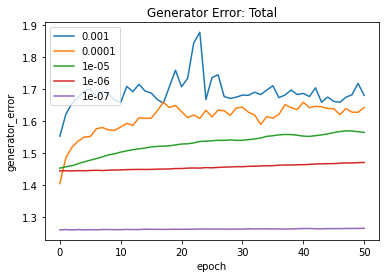

In [ ]:
# Generator
fig, ax = plt.subplots()

for i in l.keys():
  ax.plot(np.arange(0, EPOCHS+1), np.array(l[i]['gErr_fair_history']) + np.array(l[i]['gErr_real_history']))

ax.set(xlabel='epoch', ylabel='generator_error',
       title='Generator Error: Total')
ax.legend(l.keys())

plt.show()

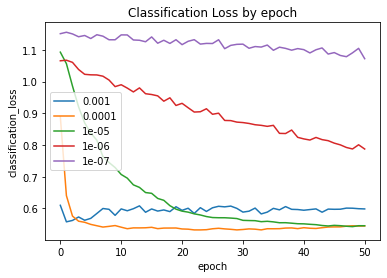

In [ ]:
# Classification
fig, ax = plt.subplots()

for i in l.keys():
  ax.plot(np.arange(0, EPOCHS+1), l[i]['closs_history'])

# blue, orange, green, red, violet

ax.set(xlabel='epoch', ylabel='classification_loss',
       title='Classification Loss by epoch')
ax.legend(l.keys())

plt.show()

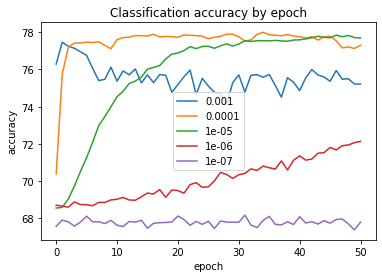

In [ ]:
# Accuracy
fig, ax = plt.subplots()

for i in l.keys():
  ax.plot(np.arange(0, EPOCHS+1), l[i]['accuracy_history'])

ax.set(xlabel='epoch', ylabel='accuracy',
       title='Classification accuracy by epoch')
ax.legend(l.keys())

plt.show()

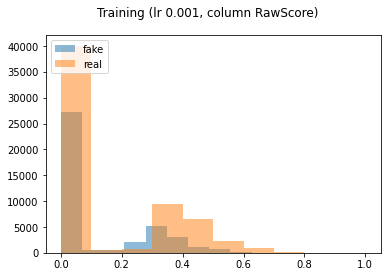

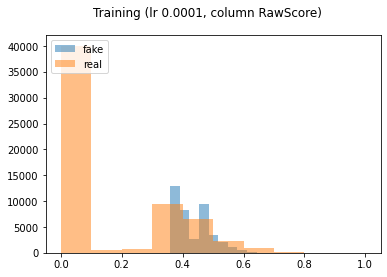

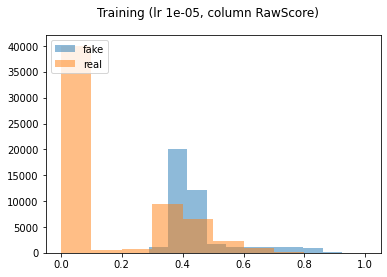

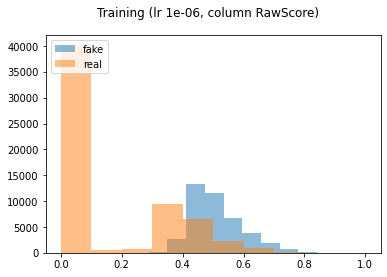

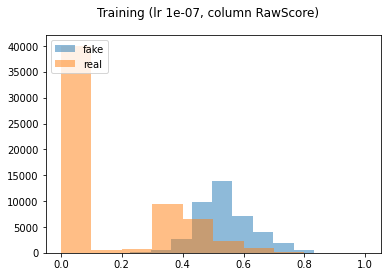

In [ ]:
for i in l.keys():

    for count, col in enumerate(compas.columns[:-1]):
        if col == 'RawScore':
            fig, ax = plt.subplots()

            ax.hist(l[i]['fake_dataset_end'].iloc[:,count], 10, label = 'fake', alpha = 0.5)
            ax.hist(compas.iloc[:,count], 10, label = 'real', alpha = 0.5)
            ax.legend(loc='upper left')

            fig.suptitle(f'Training (lr {i}, column {col})')

            plt.show()

In [ ]:
print('---------------------------------------------------')
print('init')
print('---------------------------------------------------')
print(l[0]['fake_dataset_init'].Agency_Text[:6].values)
print(compas.Agency_Text[:6].values)
print('---------------------------------------------------')
print('mid')
print('---------------------------------------------------')
print(l[0]['fake_dataset_mid'].Agency_Text[:6].values)
print(compas.Agency_Text[:6].values)
print('---------------------------------------------------')
print('mid2')
print('---------------------------------------------------')
print(l[0]['fake_dataset_mid2'].Agency_Text[:6].values)
print(compas.Agency_Text[:6].values)
print('---------------------------------------------------')
print('end')
print('---------------------------------------------------')
print(l[0]['fake_dataset_end'].Agency_Text[:6].values)
print(compas.Agency_Text[:6].values)

---------------------------------------------------
init
---------------------------------------------------
[0.43211451 0.49837169 0.38401151 0.49765807 0.36456594 0.44381708]
[0.66666667 0.66666667 0.66666667 0.66666667 0.66666667 0.66666667]
---------------------------------------------------
mid
---------------------------------------------------
[0.47094166 0.48159066 0.51502186 0.35682273 0.46648636 0.47922108]
[0.66666667 0.66666667 0.66666667 0.66666667 0.66666667 0.66666667]
---------------------------------------------------
mid2
---------------------------------------------------
[0.51318371 0.4741109  0.52793604 0.57416135 0.53930777 0.49308136]
[0.66666667 0.66666667 0.66666667 0.66666667 0.66666667 0.66666667]
---------------------------------------------------
end
---------------------------------------------------
[0.4934476  0.50522715 0.31716937 0.509184   0.52500671 0.53865564]
[0.66666667 0.66666667 0.66666667 0.66666667 0.66666667 0.66666667]


In [ ]:
print('---------------------------------------------------')
print('init')
print('---------------------------------------------------')
print(l[0]['fake_dataset_init'].Language[:6].values)
print(compas.Agency_Text[:6].values)
print('---------------------------------------------------')
print('mid')
print('---------------------------------------------------')
print(l[0]['fake_dataset_mid'].Language[:6].values)
print(compas.Agency_Text[:6].values)
print('---------------------------------------------------')
print('mid2')
print('---------------------------------------------------')
print(l[0]['fake_dataset_mid2'].Language[:6].values)
print(compas.Agency_Text[:6].values)
print('---------------------------------------------------')
print('end')
print('---------------------------------------------------')
print(l[0]['fake_dataset_end'].Language[:6].values)
print(compas.Agency_Text[:6].values)

---------------------------------------------------
init
---------------------------------------------------
[0.45907322 0.43785909 0.45822001 0.47954497 0.49291831 0.42739472]
[0.66666667 0.66666667 0.66666667 0.66666667 0.66666667 0.66666667]
---------------------------------------------------
mid
---------------------------------------------------
[0.3821182  0.37010461 0.51181525 0.66372699 0.43613043 0.60195863]
[0.66666667 0.66666667 0.66666667 0.66666667 0.66666667 0.66666667]
---------------------------------------------------
mid2
---------------------------------------------------
[0.41161597 0.58897096 0.37273395 0.39201683 0.46599314 0.59602183]
[0.66666667 0.66666667 0.66666667 0.66666667 0.66666667 0.66666667]
---------------------------------------------------
end
---------------------------------------------------
[0.51423341 0.47239658 0.322934   0.52870739 0.53456265 0.47934601]
[0.66666667 0.66666667 0.66666667 0.66666667 0.66666667 0.66666667]


#### non-cross

In [ ]:
loss = nn.BCEWithLogitsLoss()
EPOCHS = 50

l = {0.5: {'accuracy_history': [], 'gErr_real_history': [], 'dErr_real_history': [], 'gErr_fair_history': [], 'dErr_fair_history': [], 'closs_history': [], 
           'fake_dataset_end': pd.DataFrame(),'val_set': pd.DataFrame(), 'val_acc': 0, 'total': 0, 'fair_acc': 0}}

for counter, value in enumerate(l.keys()):
  classifier = binaryClassification(9)
  classifier.load_state_dict(torch.load(dir+'model_5'))

  train_loader, test_loader = data_prep(compas)
  preprocessing = pre_generator(6, 15, 15) #encoder
  generator = VAE_generator(15, 15) #decoder
  discriminator_real = binaryClassification(9)
  discriminator_fair = binaryClassification(15)

  preproc_optimizer = optim.Adam(preprocessing.parameters(), lr=1e-3, betas = (0,0.99))
  g_optimizer = optim.Adam(generator.parameters(), lr=1e-3, betas = (0, 0.99))
  d_optimizer_1 = optim.Adam(discriminator_real.parameters(), lr=1e-3, betas = (0, 0.99))
  d_optimizer_2 = optim.Adam(discriminator_fair.parameters(), lr=1e-3, betas = (0, 0.99))


  for epoch in range(EPOCHS+1):
      epoch_loss = 0
      epoch_acc = 0
      epoch_gErr_real = []
      epoch_gErr_fair = []
      epoch_dErr_real = []
      epoch_dErr_fair = []
      for n_batch, (real_batch, labels) in enumerate(train_loader):
          N = real_batch.size(0)
          d_optimizer_1.zero_grad()
          d_optimizer_2.zero_grad()
          g_optimizer.zero_grad()
          preproc_optimizer.zero_grad() 
          # 1. Train Discriminator
          sensitive_batch = real_batch[:,-1]
          real_batch=real_batch[:,0:-1]
          mu,log_var = preprocessing(real_batch)
          fake_data = generator(mu,log_var)
          fak_data = fake_data.detach()
          if epoch == EPOCHS: 
            l[value]['fake_dataset_end'] = pd.concat([l[value]['fake_dataset_end'], pd.DataFrame(fake_data.tolist())], ignore_index=True)

          if n_batch%5==4:
            d_error_real, d_error_fair = train_discriminator_fair(d_optimizer_1, d_optimizer_2, real_batch, fak_data, sensitive_batch, 9)
            epoch_dErr_real.append(d_error_real.item())
            epoch_dErr_fair.append(d_error_fair.item())

          # 2. Train Generator
          g_error_real, g_error_fair, c_loss, acc = train_generator_fair(g_optimizer, preproc_optimizer, fake_data, labels, 9,  gam=100, delt=value)
          epoch_loss += c_loss.item()
          epoch_acc += acc.item()
          epoch_gErr_real.append(g_error_real.item())
          epoch_gErr_fair.append(g_error_fair.item())

      l[value]['accuracy_history'].append(epoch_acc/len(train_loader))
      l[value]['closs_history'].append(epoch_loss/len(train_loader))
      l[value]['gErr_real_history'].append(sum(epoch_gErr_real)/len(train_loader))
      l[value]['gErr_fair_history'].append(sum(epoch_gErr_fair)/len(train_loader))
      l[value]['dErr_real_history'].append(sum(epoch_dErr_real)/(len(epoch_dErr_real)))
      l[value]['dErr_fair_history'].append(sum(epoch_dErr_fair)/(len(epoch_dErr_fair)))
      print(f'Epoch: {epoch+0:03} | D_Error_Real: {sum(epoch_dErr_real)/(len(epoch_dErr_real)):.4f} | D_Error_Fair: {sum(epoch_dErr_fair)/(len(epoch_dErr_fair)):.4f}| G_Error_Real: {sum(epoch_gErr_real)/len(train_loader):.4f} | G_Error_Fair: {sum(epoch_gErr_fair)/len(train_loader):.4f}')
      print(f'Epoch: {epoch+0:03} | Loss: {epoch_loss/len(train_loader):.5f} | Acc: {epoch_acc/len(train_loader):.3f}')


      # Validation
      if epoch == EPOCHS:
        with torch.no_grad():
            for X_batch, y_batch in test_loader:
                N = X_batch.size(0)
                sensitive_batch = X_batch[:,-1]
                real_batch = X_batch[:,0:-1]

                mu,log_var = preprocessing(real_batch)
                fake_batch = generator(mu,log_var)
                output = classifier(fake_batch)

                prediction_fair = discriminator_fair(fake_batch)
                acc_sensitive = binary_acc(prediction_fair, sensitive_batch.unsqueeze(1))

                acc = binary_acc(output, y_batch.unsqueeze(1))

                # results
                l[value]['val_set'] = pd.concat([l[value]['val_set'], pd.DataFrame(fake_batch.tolist())], ignore_index=True)
                l[value]['val_acc'] += acc.item()
                l[value]['fair_acc'] += acc_sensitive.item()
                l[value]['total'] += 1
                

Epoch: 000 | D_Error_Real: 0.5948 | D_Error_Fair: 0.3343| G_Error_Real: 1.1066 | G_Error_Fair: 0.1680
Epoch: 000 | Loss: 0.63177 | Acc: 70.215
Epoch: 001 | D_Error_Real: 0.3923 | D_Error_Fair: 0.3136| G_Error_Real: 1.9054 | G_Error_Fair: 0.0998
Epoch: 001 | Loss: 0.54581 | Acc: 75.299
Epoch: 002 | D_Error_Real: 0.5151 | D_Error_Fair: 0.3195| G_Error_Real: 1.5592 | G_Error_Fair: 0.1038
Epoch: 002 | Loss: 0.53887 | Acc: 76.081
Epoch: 003 | D_Error_Real: 0.5220 | D_Error_Fair: 0.3137| G_Error_Real: 1.5709 | G_Error_Fair: 0.1031
Epoch: 003 | Loss: 0.52813 | Acc: 76.404
Epoch: 004 | D_Error_Real: 0.5268 | D_Error_Fair: 0.2950| G_Error_Real: 1.5443 | G_Error_Fair: 0.0927
Epoch: 004 | Loss: 0.52315 | Acc: 77.014
Epoch: 005 | D_Error_Real: 0.5235 | D_Error_Fair: 0.2998| G_Error_Real: 1.5609 | G_Error_Fair: 0.0936
Epoch: 005 | Loss: 0.51905 | Acc: 77.153
Epoch: 006 | D_Error_Real: 0.5345 | D_Error_Fair: 0.3076| G_Error_Real: 1.5631 | G_Error_Fair: 0.0993
Epoch: 006 | Loss: 0.51792 | Acc: 77.245

In [ ]:
real_batch.shape

torch.Size([32, 9])

##### Plots Fair gamma = 100

In [ ]:
for i in l.keys():
  print(i, l[i]['val_acc']/l[i]['total'], l[i]['fair_acc']/l[i]['total'])

0.0001 76.90876494023904 63.80438247011952
0.5 77.30159362549801 63.80796812749004
100 72.27250996015937 64.00956175298805


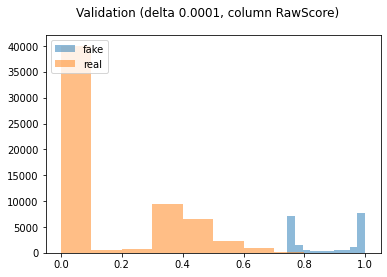

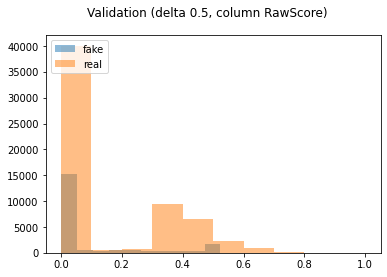

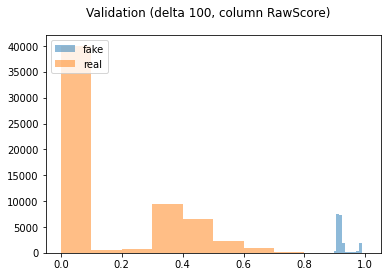

In [ ]:
for i in l.keys():

    for count, col in enumerate(compas.columns[:-1]):
        if col == 'RawScore':
            fig, ax = plt.subplots()

            ax.hist(l[i]['val_set'].iloc[:,count], 10, label = 'fake', alpha = 0.5)
            ax.hist(compas.iloc[:,count], 10, label = 'real', alpha = 0.5)
            ax.legend(loc='upper left')

            fig.suptitle(f'Validation (delta {i}, column {col})')

            plt.show()

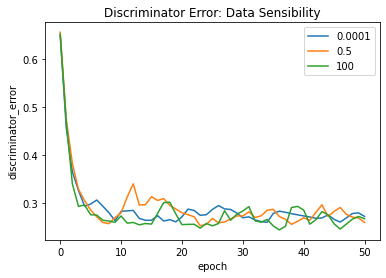

In [ ]:
# Discriminator
fig, ax = plt.subplots()

for i in l.keys():
  ax.plot(np.arange(0, EPOCHS+1), l[i]['dErr_real_history'])

ax.set(xlabel='epoch', ylabel='discriminator_error',
       title='Discriminator Error: Data Sensibility')
ax.legend(l.keys())

plt.show()

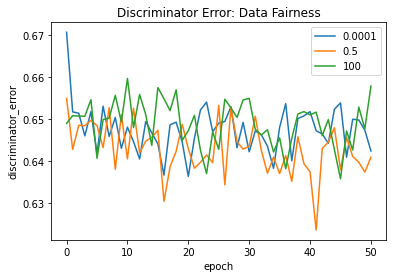

In [ ]:
# Discriminator
fig, ax = plt.subplots()

for i in l.keys():
  ax.plot(np.arange(0, EPOCHS+1), l[i]['dErr_fair_history'])

ax.set(xlabel='epoch', ylabel='discriminator_error',
       title='Discriminator Error: Data Fairness')
ax.legend(l.keys())

plt.show()

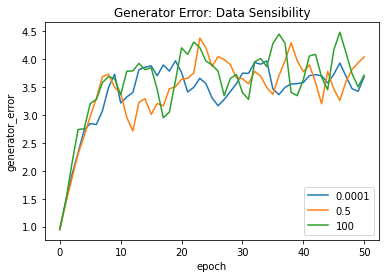

In [ ]:
# Generator
fig, ax = plt.subplots()

for i in l.keys():
  ax.plot(np.arange(0, EPOCHS+1), l[i]['gErr_real_history'])

ax.set(xlabel='epoch', ylabel='generator_error',
       title='Generator Error: Data Sensibility')
ax.legend(l.keys())

plt.show()

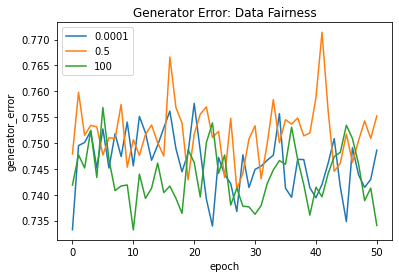

In [ ]:
# Generator
fig, ax = plt.subplots()

for i in l.keys():
  ax.plot(np.arange(0, EPOCHS+1), l[i]['gErr_fair_history'])

ax.set(xlabel='epoch', ylabel='generator_error',
       title='Generator Error: Data Fairness')
ax.legend(l.keys())

plt.show()

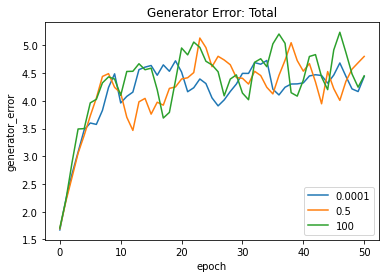

In [ ]:
# Generator
fig, ax = plt.subplots()

for i in l.keys():
  ax.plot(np.arange(0, EPOCHS+1), np.array(l[i]['gErr_fair_history']) + np.array(l[i]['gErr_real_history']))

ax.set(xlabel='epoch', ylabel='generator_error',
       title='Generator Error: Total')
ax.legend(l.keys())

plt.show()

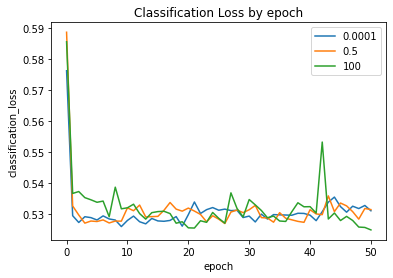

In [ ]:
# Classification
fig, ax = plt.subplots()

for i in l.keys():
  ax.plot(np.arange(0, EPOCHS+1), l[i]['closs_history'])

# blue, orange, green, red, violet

ax.set(xlabel='epoch', ylabel='classification_loss',
       title='Classification Loss by epoch')
ax.legend(l.keys())

plt.show()

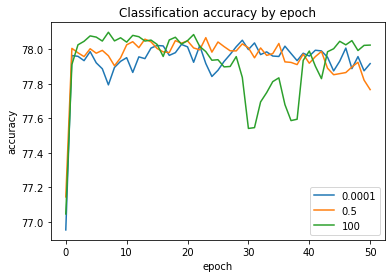

In [ ]:
# Accuracy
fig, ax = plt.subplots()

for i in l.keys():
  ax.plot(np.arange(0, EPOCHS+1), l[i]['accuracy_history'])

ax.set(xlabel='epoch', ylabel='accuracy',
       title='Classification accuracy by epoch')
ax.legend(l.keys())

plt.show()

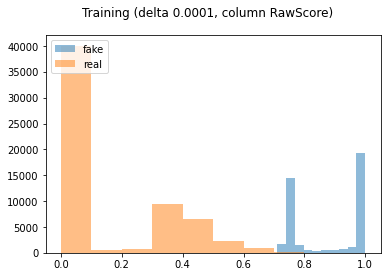

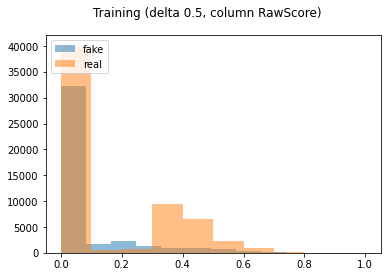

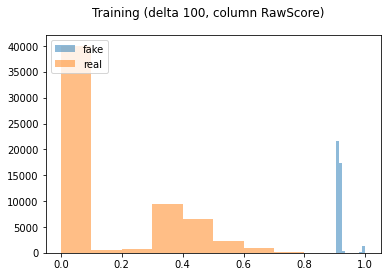

In [ ]:
for i in l.keys():

    for count, col in enumerate(compas.columns[:-1]):
        if col == 'RawScore':
            fig, ax = plt.subplots()

            ax.hist(l[i]['fake_dataset_end'].iloc[:,count], 10, label = 'fake', alpha = 0.5)
            ax.hist(compas.iloc[:,count], 10, label = 'real', alpha = 0.5)
            ax.legend(loc='upper left')

            fig.suptitle(f'Training (delta {i}, column {col})')

            plt.show()

##### Plots Fair gamma = 0.5

In [ ]:
for i in l.keys():
  print(i, l[i]['val_acc']/l[i]['total'], l[i]['fair_acc']/l[i]['total'])

0.0001 74.38565737051793 64.43824701195219
0.5 71.46932270916335 63.88804780876494
100 65.11035856573706 64.41155378486056


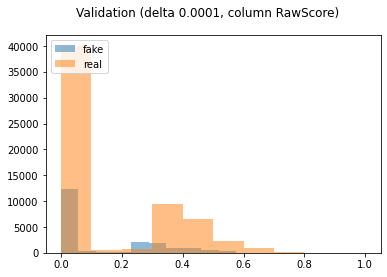

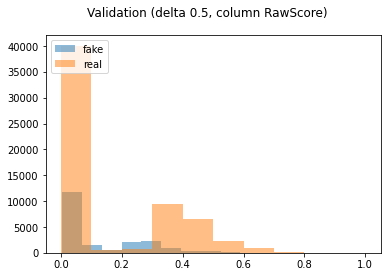

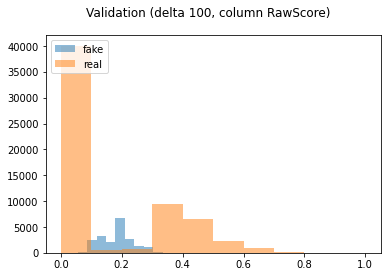

In [ ]:
for i in l.keys():

    for count, col in enumerate(compas.columns[:-1]):
        if col == 'RawScore':
            fig, ax = plt.subplots()

            ax.hist(l[i]['val_set'].iloc[:,count], 10, label = 'fake', alpha = 0.5)
            ax.hist(compas.iloc[:,count], 10, label = 'real', alpha = 0.5)
            ax.legend(loc='upper left')

            fig.suptitle(f'Validation (delta {i}, column {col})')

            plt.show()

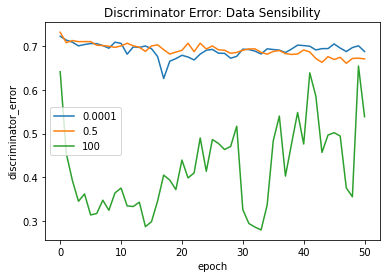

In [ ]:
# Discriminator
fig, ax = plt.subplots()

for i in l.keys():
  ax.plot(np.arange(0, EPOCHS+1), l[i]['dErr_real_history'])

ax.set(xlabel='epoch', ylabel='discriminator_error',
       title='Discriminator Error: Data Sensibility')
ax.legend(l.keys())

plt.show()

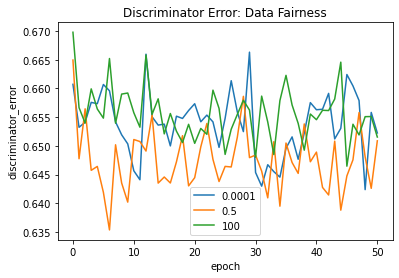

In [ ]:
# Discriminator
fig, ax = plt.subplots()

for i in l.keys():
  ax.plot(np.arange(0, EPOCHS+1), l[i]['dErr_fair_history'])

ax.set(xlabel='epoch', ylabel='discriminator_error',
       title='Discriminator Error: Data Fairness')
ax.legend(l.keys())

plt.show()

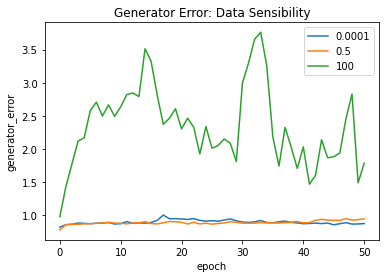

In [ ]:
# Generator
fig, ax = plt.subplots()

for i in l.keys():
  ax.plot(np.arange(0, EPOCHS+1), l[i]['gErr_real_history'])

ax.set(xlabel='epoch', ylabel='generator_error',
       title='Generator Error: Data Sensibility')
ax.legend(l.keys())

plt.show()

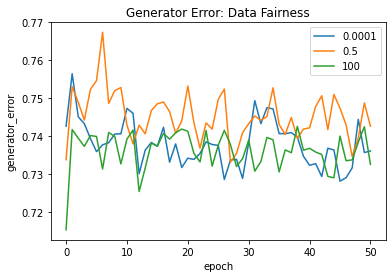

In [ ]:
# Generator
fig, ax = plt.subplots()

for i in l.keys():
  ax.plot(np.arange(0, EPOCHS+1), l[i]['gErr_fair_history'])

ax.set(xlabel='epoch', ylabel='generator_error',
       title='Generator Error: Data Fairness')
ax.legend(l.keys())

plt.show()

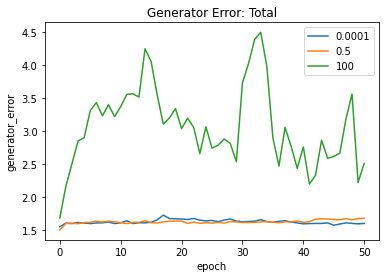

In [ ]:
# Generator
fig, ax = plt.subplots()

for i in l.keys():
  ax.plot(np.arange(0, EPOCHS+1), np.array(l[i]['gErr_fair_history']) + np.array(l[i]['gErr_real_history']))

ax.set(xlabel='epoch', ylabel='generator_error',
       title='Generator Error: Total')
ax.legend(l.keys())

plt.show()

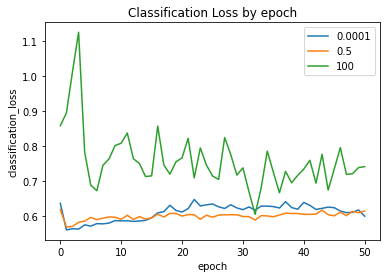

In [ ]:
# Classification
fig, ax = plt.subplots()

for i in l.keys():
  ax.plot(np.arange(0, EPOCHS+1), l[i]['closs_history'])

# blue, orange, green, red, violet

ax.set(xlabel='epoch', ylabel='classification_loss',
       title='Classification Loss by epoch')
ax.legend(l.keys())

plt.show()

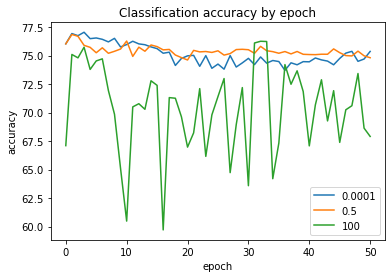

In [ ]:
# Accuracy
fig, ax = plt.subplots()

for i in l.keys():
  ax.plot(np.arange(0, EPOCHS+1), l[i]['accuracy_history'])

ax.set(xlabel='epoch', ylabel='accuracy',
       title='Classification accuracy by epoch')
ax.legend(l.keys())

plt.show()

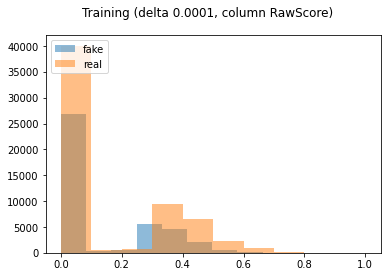

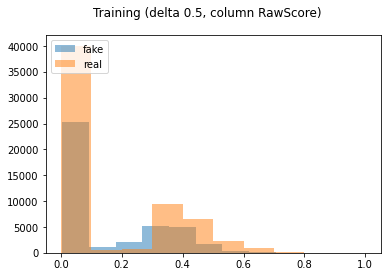

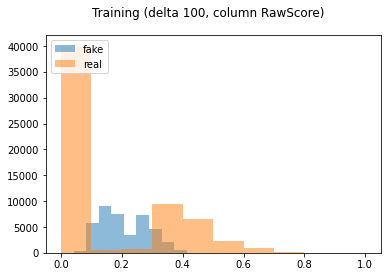

In [ ]:
for i in l.keys():

    for count, col in enumerate(compas.columns[:-1]):
        if col == 'RawScore':
            fig, ax = plt.subplots()

            ax.hist(l[i]['fake_dataset_end'].iloc[:,count], 10, label = 'fake', alpha = 0.5)
            ax.hist(compas.iloc[:,count], 10, label = 'real', alpha = 0.5)
            ax.legend(loc='upper left')

            fig.suptitle(f'Training (delta {i}, column {col})')

            plt.show()



##### Plots Fair SDDT gamma=100, delta = 0.5


In [ ]:
for i in l.keys():
  print(i, l[i]['val_acc']/l[i]['total'], l[i]['fair_acc']/l[i]['total'])

0.5 64.200796812749 77.9780876494024


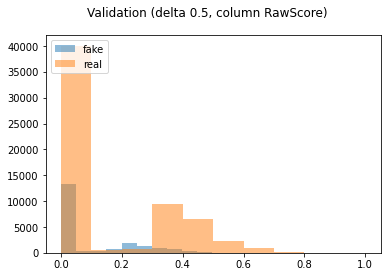

In [ ]:
for i in l.keys():

    for count, col in enumerate(compas.columns[:-1]):
        if col == 'RawScore':
            fig, ax = plt.subplots()

            ax.hist(l[i]['val_set'].iloc[:,count], 10, label = 'fake', alpha = 0.5)
            ax.hist(compas.iloc[:,count], 10, label = 'real', alpha = 0.5)
            ax.legend(loc='upper left')

            fig.suptitle(f'Validation (delta {i}, column {col})')

            plt.show()

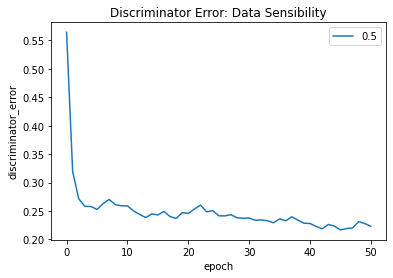

In [ ]:
# Discriminator
fig, ax = plt.subplots()

for i in l.keys():
  ax.plot(np.arange(0, EPOCHS+1), l[i]['dErr_real_history'])

ax.set(xlabel='epoch', ylabel='discriminator_error',
       title='Discriminator Error: Data Sensibility')
ax.legend(l.keys())

plt.show()

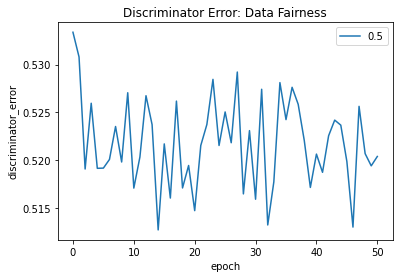

In [ ]:
# Discriminator
fig, ax = plt.subplots()

for i in l.keys():
  ax.plot(np.arange(0, EPOCHS+1), l[i]['dErr_fair_history'])

ax.set(xlabel='epoch', ylabel='discriminator_error',
       title='Discriminator Error: Data Fairness')
ax.legend(l.keys())

plt.show()

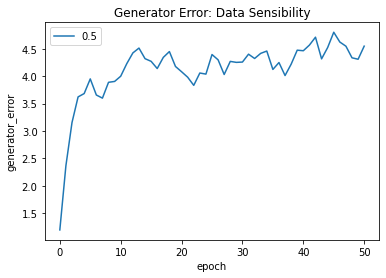

In [ ]:
# Generator
fig, ax = plt.subplots()

for i in l.keys():
  ax.plot(np.arange(0, EPOCHS+1), l[i]['gErr_real_history'])

ax.set(xlabel='epoch', ylabel='generator_error',
       title='Generator Error: Data Sensibility')
ax.legend(l.keys())

plt.show()

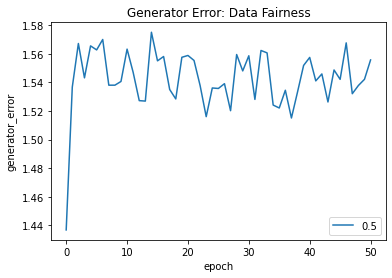

In [ ]:
# Generator
fig, ax = plt.subplots()

for i in l.keys():
  ax.plot(np.arange(0, EPOCHS+1), l[i]['gErr_fair_history'])

ax.set(xlabel='epoch', ylabel='generator_error',
       title='Generator Error: Data Fairness')
ax.legend(l.keys())

plt.show()

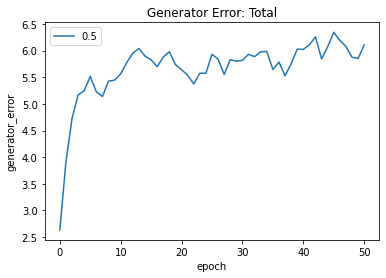

In [ ]:
# Generator
fig, ax = plt.subplots()

for i in l.keys():
  ax.plot(np.arange(0, EPOCHS+1), np.array(l[i]['gErr_fair_history']) + np.array(l[i]['gErr_real_history']))

ax.set(xlabel='epoch', ylabel='generator_error',
       title='Generator Error: Total')
ax.legend(l.keys())

plt.show()

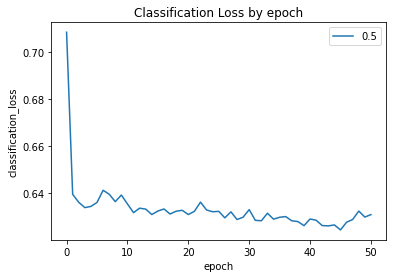

In [ ]:
# Classification
fig, ax = plt.subplots()

for i in l.keys():
  ax.plot(np.arange(0, EPOCHS+1), l[i]['closs_history'])

# blue, orange, green, red, violet

ax.set(xlabel='epoch', ylabel='classification_loss',
       title='Classification Loss by epoch')
ax.legend(l.keys())

plt.show()

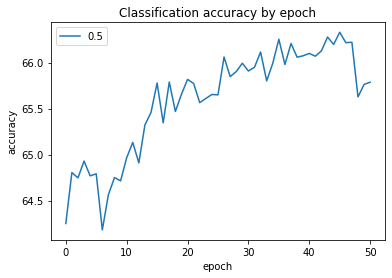

In [ ]:
# Accuracy
fig, ax = plt.subplots()

for i in l.keys():
  ax.plot(np.arange(0, EPOCHS+1), l[i]['accuracy_history'])

ax.set(xlabel='epoch', ylabel='accuracy',
       title='Classification accuracy by epoch')
ax.legend(l.keys())

plt.show()

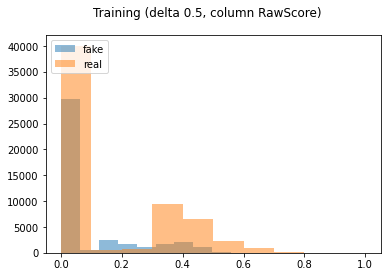

In [ ]:
for i in l.keys():

    for count, col in enumerate(compas.columns[:-1]):
        if col == 'RawScore':
            fig, ax = plt.subplots()

            ax.hist(l[i]['fake_dataset_end'].iloc[:,count], 10, label = 'fake', alpha = 0.5)
            ax.hist(compas.iloc[:,count], 10, label = 'real', alpha = 0.5)
            ax.legend(loc='upper left')

            fig.suptitle(f'Training (delta {i}, column {col})')

            plt.show()



##### Plots Fair SDDT gamma=0.5, delta = 0.5


In [ ]:
for i in l.keys():
  print(i, l[i]['val_acc']/l[i]['total'], l[i]['fair_acc']/l[i]['total'])

0.5 61.068924302788844 78.40318725099601


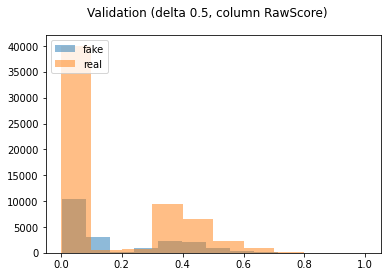

In [ ]:
for i in l.keys():

    for count, col in enumerate(compas.columns[:-1]):
        if col == 'RawScore':
            fig, ax = plt.subplots()

            ax.hist(l[i]['val_set'].iloc[:,count], 10, label = 'fake', alpha = 0.5)
            ax.hist(compas.iloc[:,count], 10, label = 'real', alpha = 0.5)
            ax.legend(loc='upper left')

            fig.suptitle(f'Validation (delta {i}, column {col})')

            plt.show()

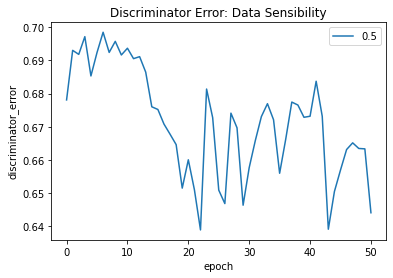

In [ ]:
# Discriminator
fig, ax = plt.subplots()

for i in l.keys():
  ax.plot(np.arange(0, EPOCHS+1), l[i]['dErr_real_history'])

ax.set(xlabel='epoch', ylabel='discriminator_error',
       title='Discriminator Error: Data Sensibility')
ax.legend(l.keys())

plt.show()

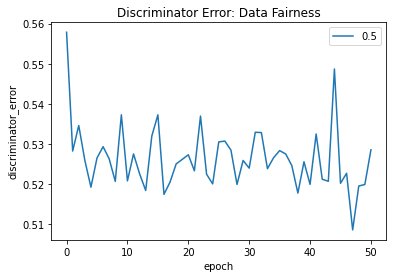

In [ ]:
# Discriminator
fig, ax = plt.subplots()

for i in l.keys():
  ax.plot(np.arange(0, EPOCHS+1), l[i]['dErr_fair_history'])

ax.set(xlabel='epoch', ylabel='discriminator_error',
       title='Discriminator Error: Data Fairness')
ax.legend(l.keys())

plt.show()

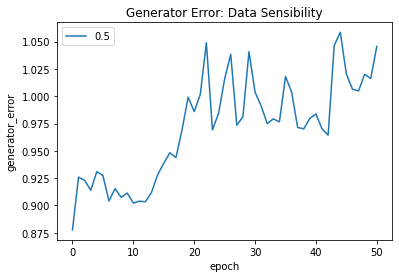

In [ ]:
# Generator
fig, ax = plt.subplots()

for i in l.keys():
  ax.plot(np.arange(0, EPOCHS+1), l[i]['gErr_real_history'])

ax.set(xlabel='epoch', ylabel='generator_error',
       title='Generator Error: Data Sensibility')
ax.legend(l.keys())

plt.show()

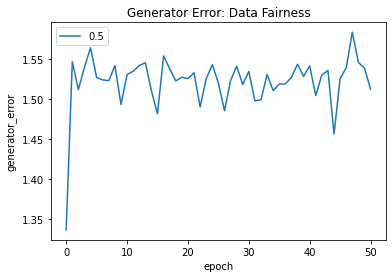

In [ ]:
# Generator
fig, ax = plt.subplots()

for i in l.keys():
  ax.plot(np.arange(0, EPOCHS+1), l[i]['gErr_fair_history'])

ax.set(xlabel='epoch', ylabel='generator_error',
       title='Generator Error: Data Fairness')
ax.legend(l.keys())

plt.show()

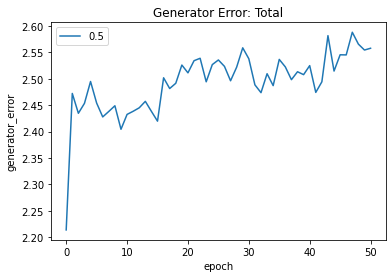

In [ ]:
# Generator
fig, ax = plt.subplots()

for i in l.keys():
  ax.plot(np.arange(0, EPOCHS+1), np.array(l[i]['gErr_fair_history']) + np.array(l[i]['gErr_real_history']))

ax.set(xlabel='epoch', ylabel='generator_error',
       title='Generator Error: Total')
ax.legend(l.keys())

plt.show()

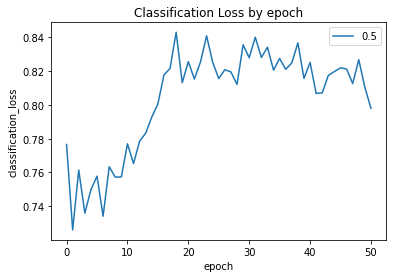

In [ ]:
# Classification
fig, ax = plt.subplots()

for i in l.keys():
  ax.plot(np.arange(0, EPOCHS+1), l[i]['closs_history'])

# blue, orange, green, red, violet

ax.set(xlabel='epoch', ylabel='classification_loss',
       title='Classification Loss by epoch')
ax.legend(l.keys())

plt.show()

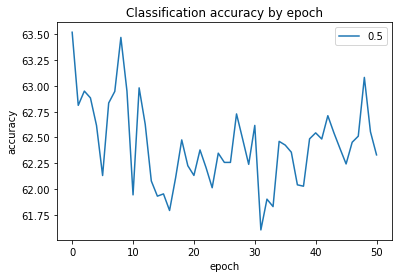

In [ ]:
# Accuracy
fig, ax = plt.subplots()

for i in l.keys():
  ax.plot(np.arange(0, EPOCHS+1), l[i]['accuracy_history'])

ax.set(xlabel='epoch', ylabel='accuracy',
       title='Classification accuracy by epoch')
ax.legend(l.keys())

plt.show()

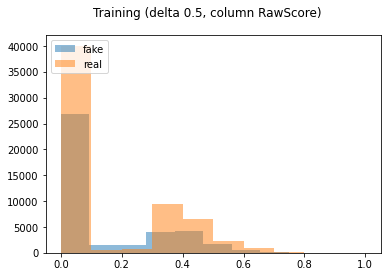

In [ ]:
for i in l.keys():

    for count, col in enumerate(compas.columns[:-1]):
        if col == 'RawScore':
            fig, ax = plt.subplots()

            ax.hist(l[i]['fake_dataset_end'].iloc[:,count], 10, label = 'fake', alpha = 0.5)
            ax.hist(compas.iloc[:,count], 10, label = 'real', alpha = 0.5)
            ax.legend(loc='upper left')

            fig.suptitle(f'Training (delta {i}, column {col})')

            plt.show()



##### Plots Fair DDST gamma=0.5, delta = 0.5


In [ ]:
for i in l.keys():
  print(i, l[i]['val_acc']/l[i]['total'], l[i]['fair_acc']/l[i]['total'])

0.5 73.76341948310139 91.13121272365805


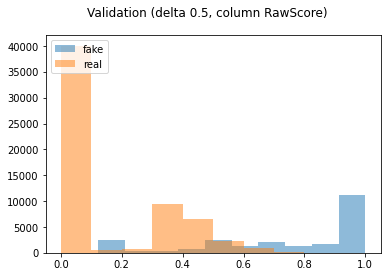

In [ ]:
for i in l.keys():

    for count, col in enumerate(compas.columns[:-1]):
        if col == 'RawScore':
            fig, ax = plt.subplots()

            ax.hist(l[i]['val_set'].iloc[:,count], 10, label = 'fake', alpha = 0.5)
            ax.hist(compas.iloc[:,count], 10, label = 'real', alpha = 0.5)
            ax.legend(loc='upper left')

            fig.suptitle(f'Validation (delta {i}, column {col})')

            plt.show()

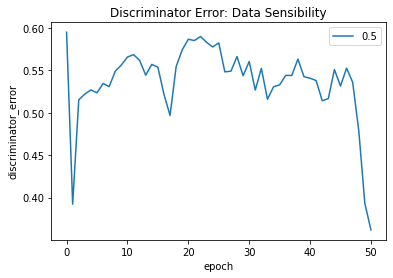

In [ ]:
# Discriminator
fig, ax = plt.subplots()

for i in l.keys():
  ax.plot(np.arange(0, EPOCHS+1), l[i]['dErr_real_history'])

ax.set(xlabel='epoch', ylabel='discriminator_error',
       title='Discriminator Error: Data Sensibility')
ax.legend(l.keys())

plt.show()

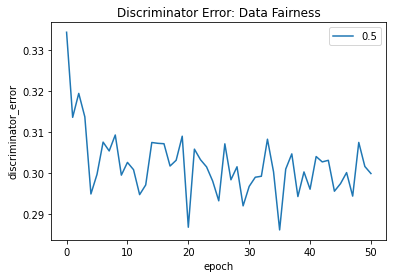

In [ ]:
# Discriminator
fig, ax = plt.subplots()

for i in l.keys():
  ax.plot(np.arange(0, EPOCHS+1), l[i]['dErr_fair_history'])

ax.set(xlabel='epoch', ylabel='discriminator_error',
       title='Discriminator Error: Data Fairness')
ax.legend(l.keys())

plt.show()

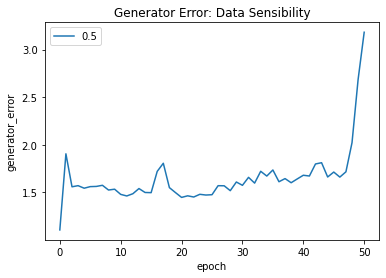

In [ ]:
# Generator
fig, ax = plt.subplots()

for i in l.keys():
  ax.plot(np.arange(0, EPOCHS+1), l[i]['gErr_real_history'])

ax.set(xlabel='epoch', ylabel='generator_error',
       title='Generator Error: Data Sensibility')
ax.legend(l.keys())

plt.show()

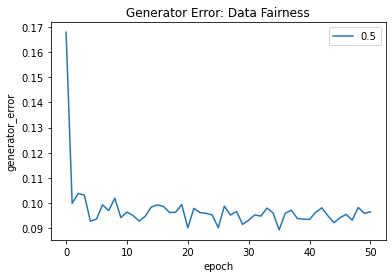

In [ ]:
# Generator
fig, ax = plt.subplots()

for i in l.keys():
  ax.plot(np.arange(0, EPOCHS+1), l[i]['gErr_fair_history'])

ax.set(xlabel='epoch', ylabel='generator_error',
       title='Generator Error: Data Fairness')
ax.legend(l.keys())

plt.show()

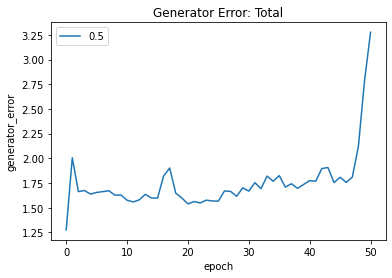

In [ ]:
# Generator
fig, ax = plt.subplots()

for i in l.keys():
  ax.plot(np.arange(0, EPOCHS+1), np.array(l[i]['gErr_fair_history']) + np.array(l[i]['gErr_real_history']))

ax.set(xlabel='epoch', ylabel='generator_error',
       title='Generator Error: Total')
ax.legend(l.keys())

plt.show()

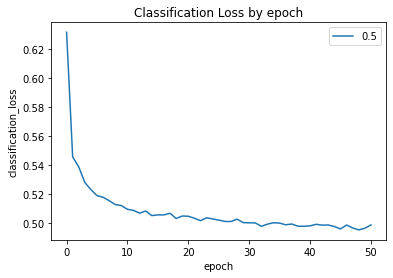

In [ ]:
# Classification
fig, ax = plt.subplots()

for i in l.keys():
  ax.plot(np.arange(0, EPOCHS+1), l[i]['closs_history'])

# blue, orange, green, red, violet

ax.set(xlabel='epoch', ylabel='classification_loss',
       title='Classification Loss by epoch')
ax.legend(l.keys())

plt.show()

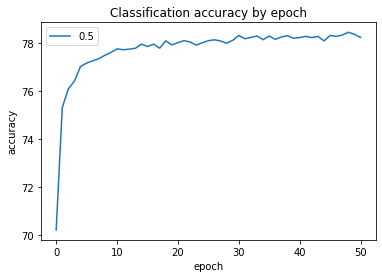

In [ ]:
# Accuracy
fig, ax = plt.subplots()

for i in l.keys():
  ax.plot(np.arange(0, EPOCHS+1), l[i]['accuracy_history'])

ax.set(xlabel='epoch', ylabel='accuracy',
       title='Classification accuracy by epoch')
ax.legend(l.keys())

plt.show()

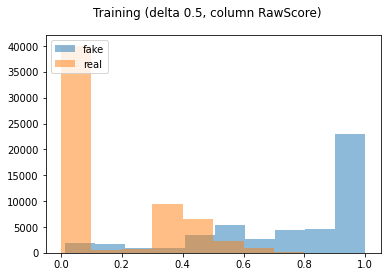

In [ ]:
for i in l.keys():

    for count, col in enumerate(compas.columns[:-1]):
        if col == 'RawScore':
            fig, ax = plt.subplots()

            ax.hist(l[i]['fake_dataset_end'].iloc[:,count], 10, label = 'fake', alpha = 0.5)
            ax.hist(compas.iloc[:,count], 10, label = 'real', alpha = 0.5)
            ax.legend(loc='upper left')

            fig.suptitle(f'Training (delta {i}, column {col})')

            plt.show()

##### Plots Fair target zeros

In [ ]:
for i in l.keys():
  print(i, l[i]['val_acc']/l[i]['total'], l[i]['fair_acc']/l[i]['total'])

0.0001 75.03705179282869 63.98645418326693
0.5 70.72350597609562 63.88247011952191
100 0.0 0.0


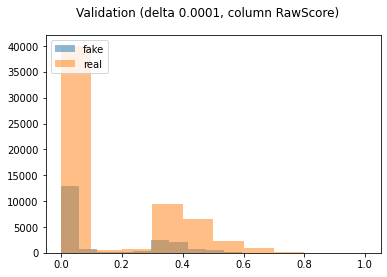

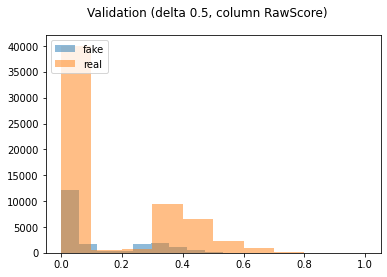

/usr/local/lib/python3.7/dist-packages/matplotlib/axes/_axes.py:6630: RuntimeWarning: All-NaN slice encountered
  xmin = min(xmin, np.nanmin(xi))
/usr/local/lib/python3.7/dist-packages/matplotlib/axes/_axes.py:6631: RuntimeWarning: All-NaN slice encountered
  xmax = max(xmax, np.nanmax(xi))


ValueError: ignored

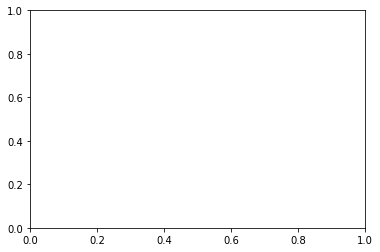

In [ ]:
for i in l.keys():

    for count, col in enumerate(compas.columns[:-1]):
        if col == 'RawScore':
            fig, ax = plt.subplots()

            ax.hist(l[i]['val_set'].iloc[:,count], 10, label = 'fake', alpha = 0.5)
            ax.hist(compas.iloc[:,count], 10, label = 'real', alpha = 0.5)
            ax.legend(loc='upper left')

            fig.suptitle(f'Validation (delta {i}, column {col})')

            plt.show()

In [ ]:
# Discriminator
fig, ax = plt.subplots()

for i in l.keys():
  ax.plot(np.arange(0, EPOCHS+1), l[i]['dErr_real_history'])

ax.set(xlabel='epoch', ylabel='discriminator_error',
       title='Discriminator Error: Data Sensibility')
ax.legend(l.keys())

plt.show()

In [ ]:
# Discriminator
fig, ax = plt.subplots()

for i in l.keys():
  ax.plot(np.arange(0, EPOCHS+1), l[i]['dErr_fair_history'])

ax.set(xlabel='epoch', ylabel='discriminator_error',
       title='Discriminator Error: Data Fairness')
ax.legend(l.keys())

plt.show()

In [ ]:
# Generator
fig, ax = plt.subplots()

for i in l.keys():
  ax.plot(np.arange(0, EPOCHS+1), l[i]['gErr_real_history'])

ax.set(xlabel='epoch', ylabel='generator_error',
       title='Generator Error: Data Sensibility')
ax.legend(l.keys())

plt.show()

In [ ]:
# Generator
fig, ax = plt.subplots()

for i in l.keys():
  ax.plot(np.arange(0, EPOCHS+1), l[i]['gErr_fair_history'])

ax.set(xlabel='epoch', ylabel='generator_error',
       title='Generator Error: Data Fairness')
ax.legend(l.keys())

plt.show()

In [ ]:
# Generator
fig, ax = plt.subplots()

for i in l.keys():
  ax.plot(np.arange(0, EPOCHS+1), np.array(l[i]['gErr_fair_history']) + np.array(l[i]['gErr_real_history']))

ax.set(xlabel='epoch', ylabel='generator_error',
       title='Generator Error: Total')
ax.legend(l.keys())

plt.show()

In [ ]:
# Classification
fig, ax = plt.subplots()

for i in l.keys():
  ax.plot(np.arange(0, EPOCHS+1), l[i]['closs_history'])

# blue, orange, green, red, violet

ax.set(xlabel='epoch', ylabel='classification_loss',
       title='Classification Loss by epoch')
ax.legend(l.keys())

plt.show()

In [ ]:
# Accuracy
fig, ax = plt.subplots()

for i in l.keys():
  ax.plot(np.arange(0, EPOCHS+1), l[i]['accuracy_history'])

ax.set(xlabel='epoch', ylabel='accuracy',
       title='Classification accuracy by epoch')
ax.legend(l.keys())

plt.show()

In [ ]:
for i in l.keys():

    for count, col in enumerate(compas.columns[:-1]):
        if col == 'RawScore':
            fig, ax = plt.subplots()

            ax.hist(l[i]['fake_dataset_end'].iloc[:,count], 10, label = 'fake', alpha = 0.5)
            ax.hist(compas.iloc[:,count], 10, label = 'real', alpha = 0.5)
            ax.legend(loc='upper left')

            fig.suptitle(f'Training (delta {i}, column {col})')

            plt.show()

### Change dataset

In [ ]:
loss = nn.BCEWithLogitsLoss()
EPOCHS = 50

l = {0.5: {'accuracy_history': [], 'gErr_history': [], 'dErr_history': [], 'gErr_details': [], 'dErr_details': [], 'closs_history': [], 
           'fake_dataset_init': pd.DataFrame(), 'fake_dataset_mid': pd.DataFrame(), 'fake_dataset_mid2': pd.DataFrame(), 'fake_dataset_end': pd.DataFrame()}}

In [ ]:
def train_generator(optimizer_encoder, optimizer_decoder, fake_data, dim, target, gam):
    N = fake_data.size(0)
    
    #Generator
    prediction = discriminator(fake_data[:,0:dim])
    g_error = loss(prediction, 0.9*ones_target(N))

    #Classificator
    fake_labels = classifier(fake_data).reshape(-1)
    #fake_labels = 1-fake_labels
    c_loss = loss(fake_labels, target)
    acc = binary_acc(fake_labels, target)
    
    #Total Error
    error = g_error + gam * c_loss
    error.backward()
    optimizer_encoder.step()
    optimizer_decoder.step()
    
    return g_error, c_loss, acc

In [ ]:
loss = nn.BCEWithLogitsLoss()
EPOCHS = 50

l = {100: {'accuracy_history': [], 'gErr_history': [], 'dErr_history': [], 'gErr_details': [], 'dErr_details': [], 'closs_history': [], 
         'fake_dataset_init': pd.DataFrame(), 'fake_dataset_mid': pd.DataFrame(), 'fake_dataset_mid2': pd.DataFrame(), 'fake_dataset_end': pd.DataFrame(),
         'val_set': pd.DataFrame(), 'val_closs': 0, 'val_acc': 0, 'val_derr':[], 'val_gerr':[], 'total': 0},
     0.5: {'accuracy_history': [], 'gErr_history': [], 'dErr_history': [], 'gErr_details': [], 'dErr_details': [], 'closs_history': [], 
         'fake_dataset_init': pd.DataFrame(), 'fake_dataset_mid': pd.DataFrame(), 'fake_dataset_mid2': pd.DataFrame(), 'fake_dataset_end': pd.DataFrame(),
         'val_set': pd.DataFrame(), 'val_closs': 0, 'val_acc': 0, 'val_derr':[], 'val_gerr':[], 'total': 0}}
         
for counter in l.keys():
  classifier = binaryClassification(15)
  classifier.load_state_dict(torch.load(dir+'model_3'))

  train_loader, test_loader = data_prep(new_df)
  preprocessing = pre_generator(5, 15, 15) #encoder
  generator = VAE_generator(15, 15) #decoder
  generator.load_state_dict(torch.load(dir+'decoder_compas_gender'))
  discriminator = binaryClassification(10)

  for name, child in generator.named_children():
    for param in child.parameters():
      param.requires_grad = False


  preproc_optimizer = optim.Adam(preprocessing.parameters(), lr=1e-3, betas = (0,0.99))
  g_optimizer = optim.Adam(generator.parameters(), lr=1e-3, betas = (0, 0.99))
  d_optimizer = optim.Adam(discriminator.parameters(), lr=1e-3, betas = (0, 0.99))
  #preproc_scheduler = optim.lr_scheduler.MultiStepLR(preproc_optimizer, milestones=[20, 40, 60], gamma=0.1)
  #g_scheduler = optim.lr_scheduler.MultiStepLR(g_optimizer, milestones=[20, 40, 60], gamma=0.1)
  #d_scheduler = optim.lr_scheduler.MultiStepLR(d_optimizer, milestones=[20, 40, 60], gamma=0.1)


  for epoch in range(EPOCHS+1):
      epoch_loss = 0
      epoch_acc = 0
      epoch_gErr = []
      epoch_dErr = []
      for n_batch, (real_batch, labels) in enumerate(train_loader):
          N = real_batch.size(0)
          d_optimizer.zero_grad()
          g_optimizer.zero_grad()
          preproc_optimizer.zero_grad()
          # 1. Train Discriminator
          mu,log_var = preprocessing(real_batch)
          fake_data = generator(mu,log_var)
          fak_data = fake_data.detach()
          if epoch == 0:
            l[counter]['fake_dataset_init'] = pd.concat([l[counter]['fake_dataset_init'], pd.DataFrame(fake_data.tolist())], ignore_index=True, axis = 0)
          if epoch == EPOCHS//3:
            l[counter]['fake_dataset_mid'] = pd.concat([l[counter]['fake_dataset_mid'], pd.DataFrame(fake_data.tolist())], ignore_index=True, axis = 0)
          if epoch == EPOCHS//3*2:
            l[counter]['fake_dataset_mid2'] = pd.concat([l[counter]['fake_dataset_mid2'], pd.DataFrame(fake_data.tolist())], ignore_index=True, axis = 0)
          if epoch == EPOCHS: 
            l[counter]['fake_dataset_end'] = pd.concat([l[counter]['fake_dataset_end'], pd.DataFrame(fake_data.tolist())], ignore_index=True, axis = 0)

          if n_batch%10==9:
            d_error = train_discriminator(d_optimizer, real_batch, fak_data[:,0:10])
            epoch_dErr.append(d_error.item())

          # 2. Train Generator
          g_error, c_loss, acc = train_generator(g_optimizer, preproc_optimizer, fake_data, 10, labels, counter)
          epoch_loss += c_loss.item()
          epoch_acc += acc.item()
          epoch_gErr.append(g_error.item())

  
      l[counter]['accuracy_history'].append(epoch_acc/len(train_loader))
      l[counter]['closs_history'].append(epoch_loss/len(train_loader))
      if epoch <3:
          l[counter]['gErr_details'].append(epoch_gErr)
          l[counter]['dErr_details'].append(epoch_dErr)
      l[counter]['gErr_history'].append(sum(epoch_gErr)/len(train_loader))
      l[counter]['dErr_history'].append(sum(epoch_dErr)/(len(epoch_dErr)))
      print(f'Epoch: {epoch+0:03} | D_Error: {sum(epoch_dErr)/(len(epoch_dErr)):.4f} | G_Error: {sum(epoch_gErr)/len(train_loader):.4f}')
      print(f'Epoch: {epoch+0:03} | Loss: {epoch_loss/len(train_loader):.5f} | Acc: {epoch_acc/len(train_loader):.3f}')

      # Validation
      if epoch == EPOCHS:
        with torch.no_grad():
            for X_batch, y_batch in test_loader:
                N = X_batch.size(0)

                mu,log_var = preprocessing(X_batch)
                fake_batch = generator(mu,log_var)
                output = classifier(fake_batch)

                # losses
                prediction = discriminator(fake_batch[:,0:10])
                derr = loss(prediction, zeros_target(N))
                gerr = loss(prediction, ones_target(N))
                closs = loss(output, y_batch.unsqueeze(1))
                acc = binary_acc(output, y_batch.unsqueeze(1))

                # results
                l[counter]['val_set'] = pd.concat([l[counter]['val_set'], pd.DataFrame(fake_batch.tolist())], ignore_index=True)
                l[counter]['val_gerr'].append(gerr.item())
                l[counter]['val_derr'].append(derr.item())
                l[counter]['val_acc'] += acc.item()
                l[counter]['val_closs'] += closs.item()
                l[counter]['total'] += 1

Epoch: 000 | D_Error: 0.6152 | G_Error: 0.9322
Epoch: 000 | Loss: 1.06641 | Acc: 53.852
Epoch: 001 | D_Error: 0.4003 | G_Error: 1.5046
Epoch: 001 | Loss: 0.83135 | Acc: 58.355
Epoch: 002 | D_Error: 0.2732 | G_Error: 2.3016
Epoch: 002 | Loss: 0.63715 | Acc: 68.541
Epoch: 003 | D_Error: 0.2396 | G_Error: 2.9378
Epoch: 003 | Loss: 0.60681 | Acc: 71.190
Epoch: 004 | D_Error: 0.2280 | G_Error: 3.3927
Epoch: 004 | Loss: 0.59589 | Acc: 72.117
Epoch: 005 | D_Error: 0.2234 | G_Error: 3.6569
Epoch: 005 | Loss: 0.59227 | Acc: 72.071
Epoch: 006 | D_Error: 0.2219 | G_Error: 3.8018
Epoch: 006 | Loss: 0.59097 | Acc: 72.081
Epoch: 007 | D_Error: 0.2180 | G_Error: 3.9407
Epoch: 007 | Loss: 0.58664 | Acc: 72.187
Epoch: 008 | D_Error: 0.2154 | G_Error: 4.0392
Epoch: 008 | Loss: 0.58278 | Acc: 72.617
Epoch: 009 | D_Error: 0.2135 | G_Error: 4.0786
Epoch: 009 | Loss: 0.58231 | Acc: 72.805
Epoch: 010 | D_Error: 0.2126 | G_Error: 4.0981
Epoch: 010 | Loss: 0.58106 | Acc: 72.579
Epoch: 011 | D_Error: 0.2114 | G

##### Plots decoder frozen

In [ ]:
for i in l.keys():
  print(i, l[i]['val_acc']/l[i]['total'])

#100: 76.544
#0.5: 53.546

100 64.7677269715043
0.5 52.68455931080186


In [ ]:
print((52.971 +52.822 + 52.447 + 52.526)/4)
print((53.535 +53.161 + 53.095+ 53.240)/4)
print((55.019 +61.214+ 55.599 + 60.028)/4)
print((64.434 +61.772 + 68.365+ 62.390)/4)
print((61.397 +62.880 + 63.422 + 63.587)/4)

52.691500000000005
53.25775
57.964999999999996
64.24024999999999
62.8215


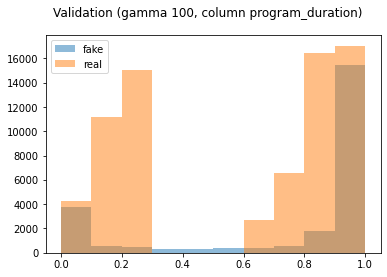

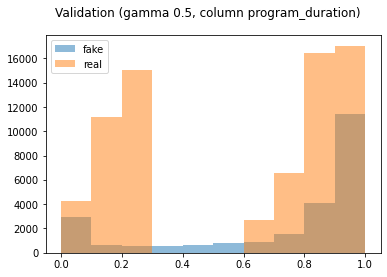

In [ ]:
for i in l.keys():

    for count, col in enumerate(new_df.columns[:-1]):
        if col == 'program_duration':
            fig, ax = plt.subplots()

            ax.hist(l[i]['val_set'].iloc[:,count], 10, label = 'fake', alpha = 0.5)
            ax.hist(new_df.iloc[:,count], 10, label = 'real', alpha = 0.5)
            ax.legend(loc='upper left')

            fig.suptitle(f'Validation (gamma {i}, column {col})')

            plt.show()

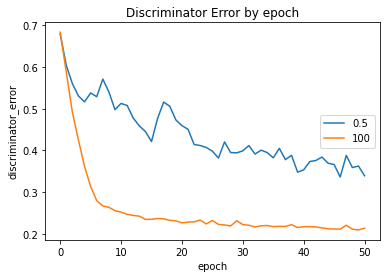

In [ ]:
# Discriminator
fig, ax = plt.subplots()

for i in l.keys():
    ax.plot(np.arange(0, EPOCHS+1), l[i]['dErr_history'])
ax.set(xlabel='epoch', ylabel='discriminator_error',
      title='Discriminator Error by epoch')
ax.legend(l.keys(), loc = 'center right')
plt.show()

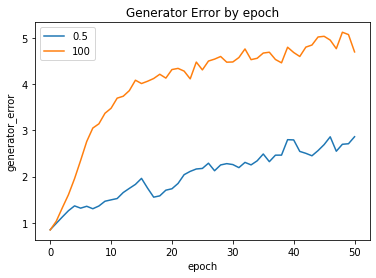

In [ ]:
# Generator
fig, ax = plt.subplots()

for i in l.keys():
    ax.plot(np.arange(0, EPOCHS+1), l[i]['gErr_history'])
ax.set(xlabel='epoch', ylabel='generator_error',
      title='Generator Error by epoch')
ax.legend(l.keys(), loc = 'upper left')
plt.show()

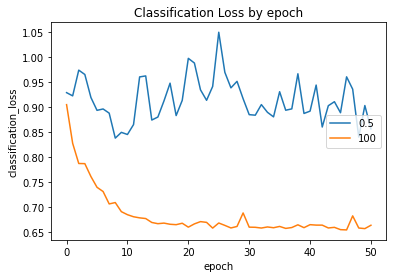

In [ ]:
# Classification
fig, ax = plt.subplots()

for i in l.keys():
    ax.plot(np.arange(0, EPOCHS+1), l[i]['closs_history'])
ax.set(xlabel='epoch', ylabel='classification_loss',
      title='Classification Loss by epoch')
ax.legend(l.keys(), loc = 'center right')
plt.show()

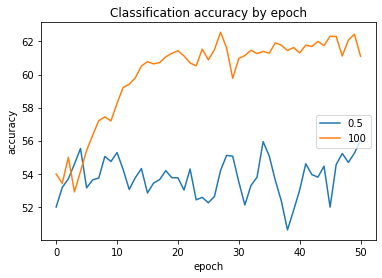

In [ ]:
# Accuracy
fig, ax = plt.subplots()

for i in l.keys():
    ax.plot(np.arange(0, EPOCHS+1), l[i]['accuracy_history'])
ax.set(xlabel='epoch', ylabel='accuracy',
      title='Classification accuracy by epoch')
ax.legend(l.keys(), loc = 'center right')
plt.show()

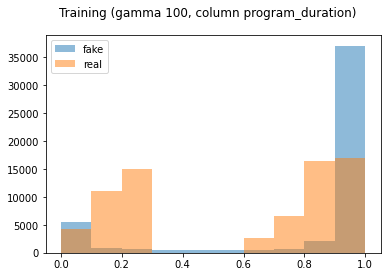

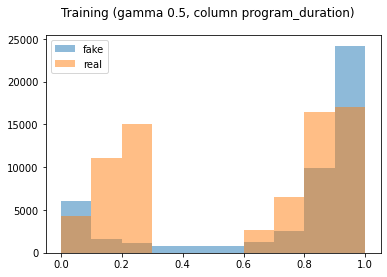

In [ ]:
for i in l.keys():

    for count, col in enumerate(new_df.columns[:-1]):
        if col == 'program_duration':
            fig, ax = plt.subplots()

            ax.hist(l[i]['fake_dataset_end'].iloc[:,count], 10, label = 'fake', alpha = 0.5)
            ax.hist(new_df.iloc[:,count], 10, label = 'real', alpha = 0.5)
            ax.legend(loc='upper left')

            fig.suptitle(f'Training (gamma {i}, column {col})')

            plt.show()

##### Plots decoder free

In [ ]:
for i in l.keys():
  print(l[i]['val_acc']/l[i]['total'])

52.97051027170311
70.94002650762094
69.4403578528827
70.69615639496355
72.9181577203446


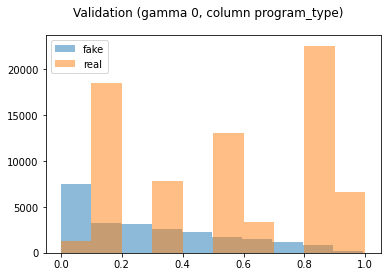

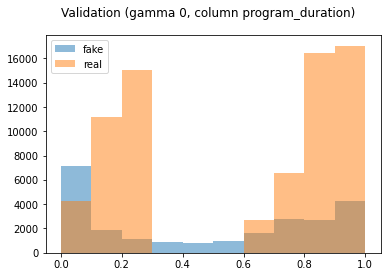

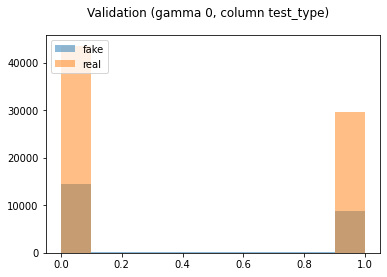

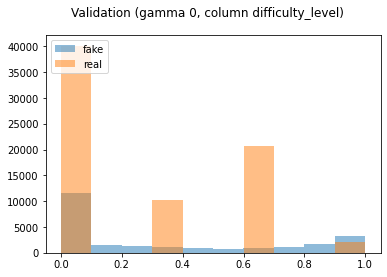

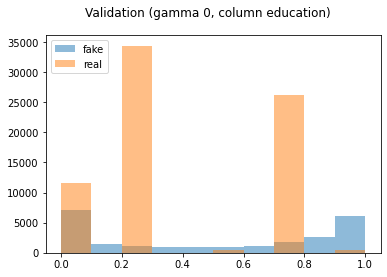

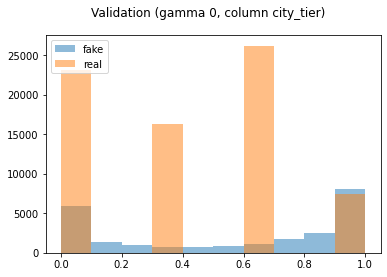

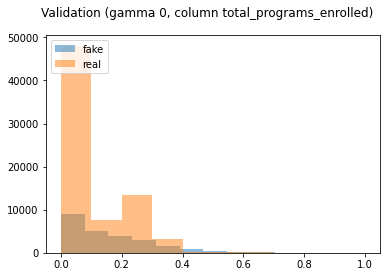

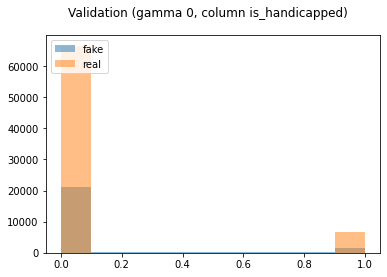

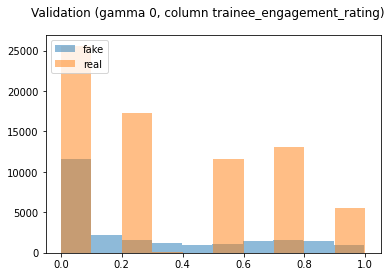

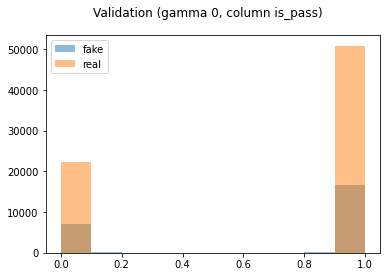

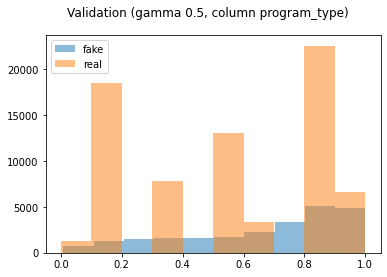

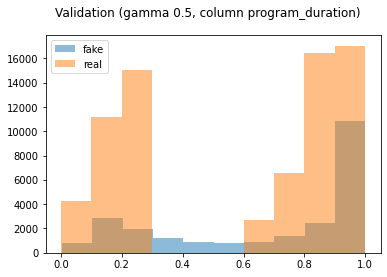

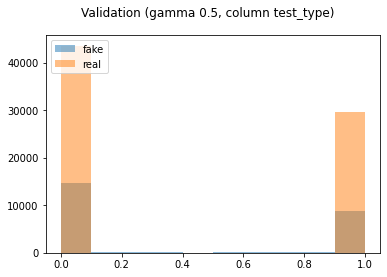

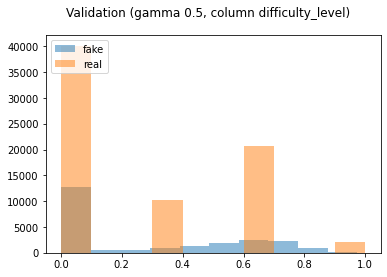

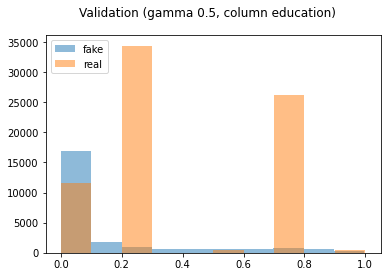

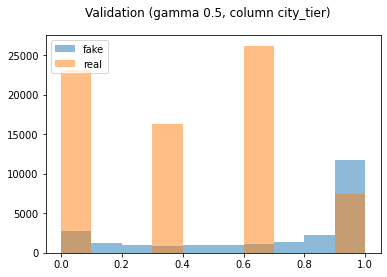

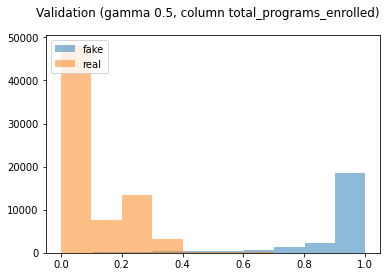

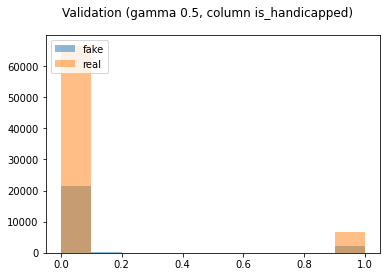

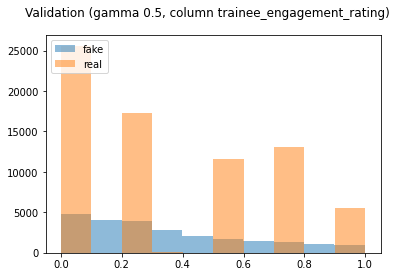

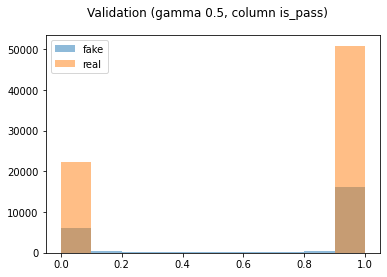

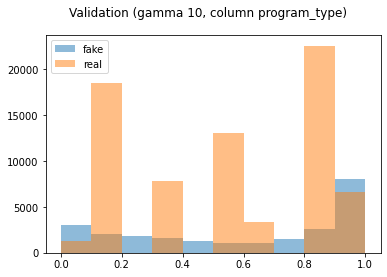

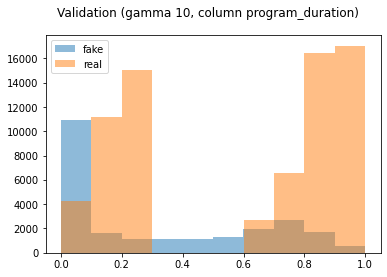

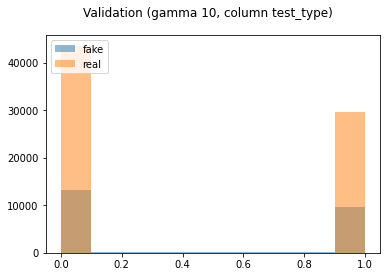

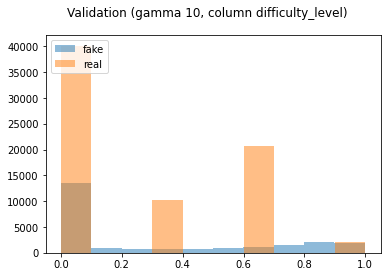

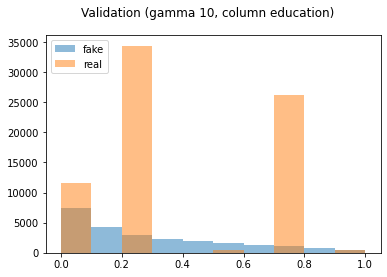

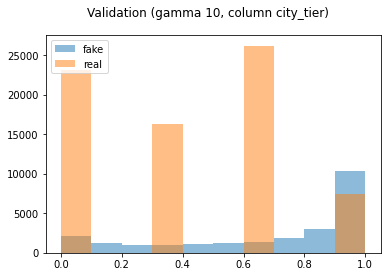

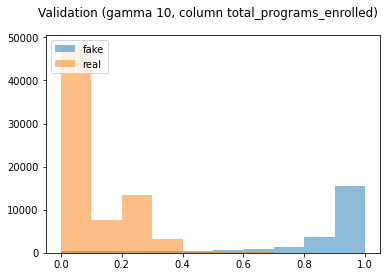

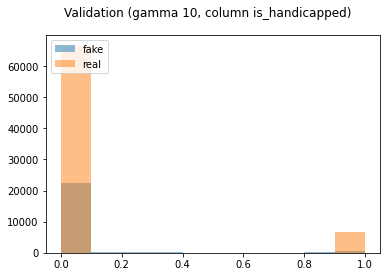

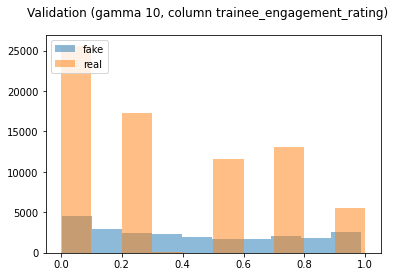

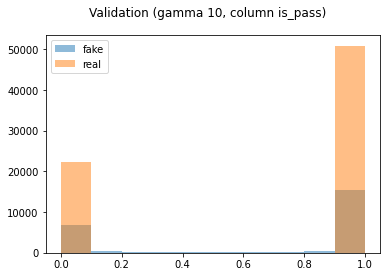

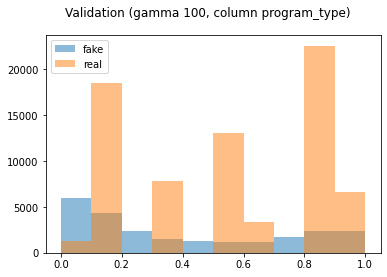

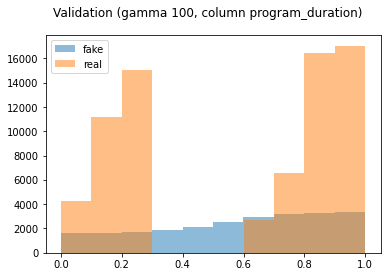

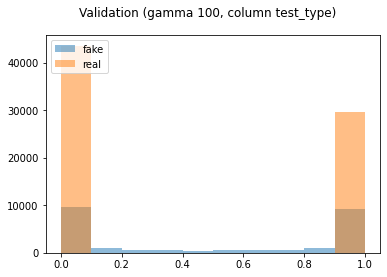

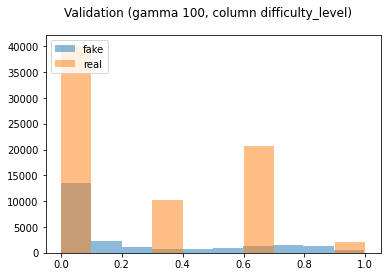

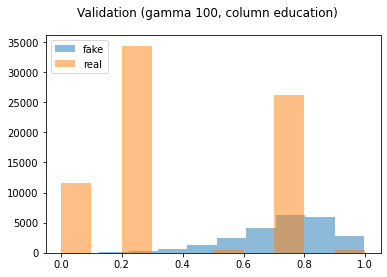

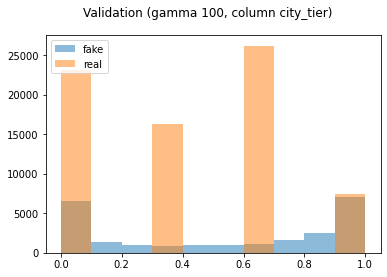

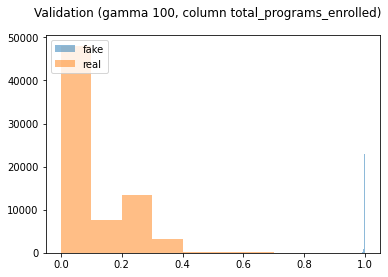

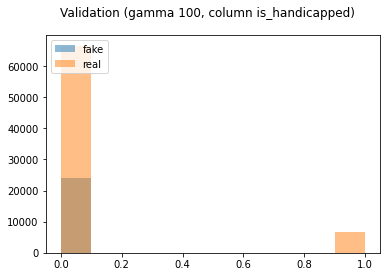

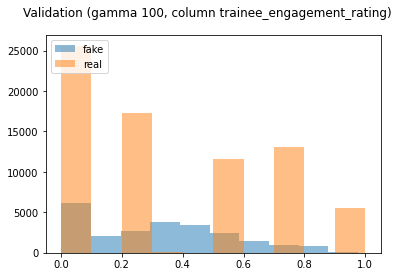

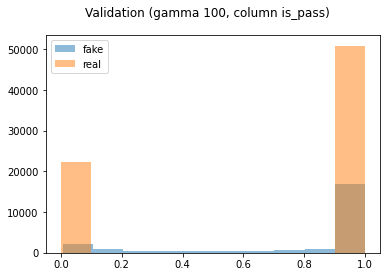

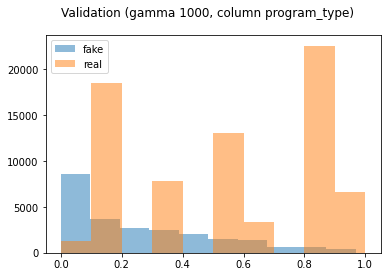

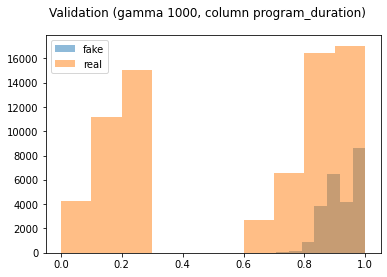

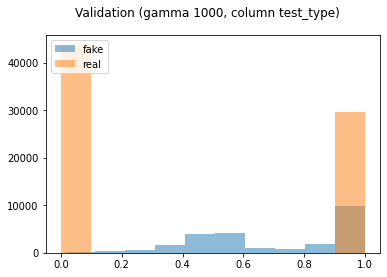

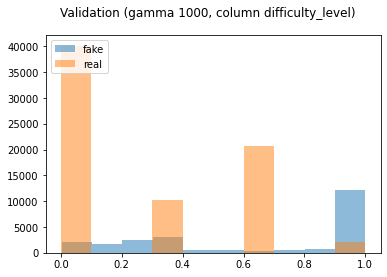

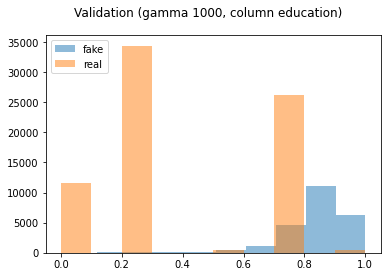

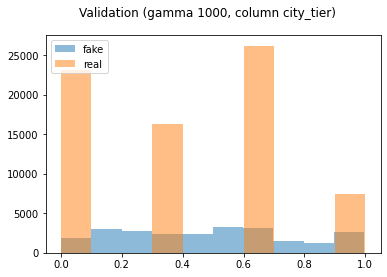

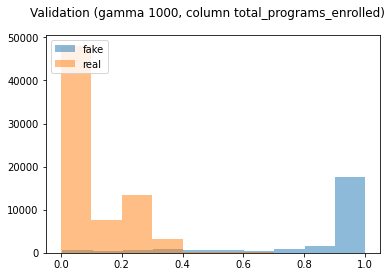

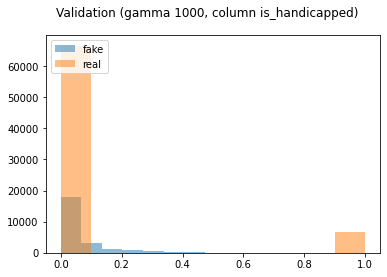

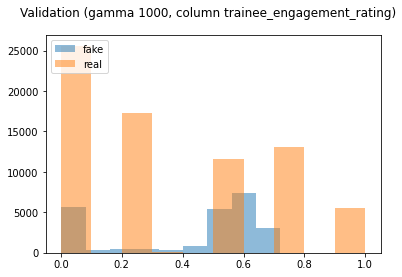

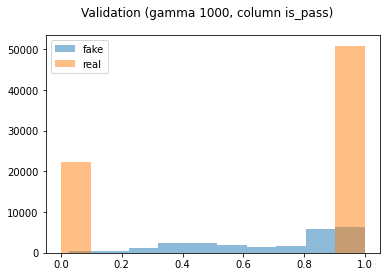

In [ ]:
for i in l.keys():

    for count, col in enumerate(new_df.columns[:-1]):
        fig, ax = plt.subplots()

        ax.hist(l[i]['val_set'].iloc[:,count], 10, label = 'fake', alpha = 0.5)
        ax.hist(new_df.iloc[:,count], 10, label = 'real', alpha = 0.5)
        ax.legend(loc='upper left')

        fig.suptitle(f'Validation (gamma {i}, column {col})')

        plt.show()

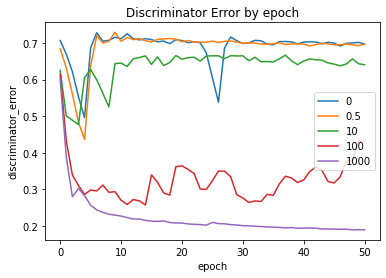

In [ ]:
# Discriminator
fig, ax = plt.subplots()

for i in l.keys():
    ax.plot(np.arange(0, EPOCHS+1), l[i]['dErr_history'])
ax.set(xlabel='epoch', ylabel='discriminator_error',
      title='Discriminator Error by epoch')
ax.legend(l.keys(), loc = 'center right')
plt.show()

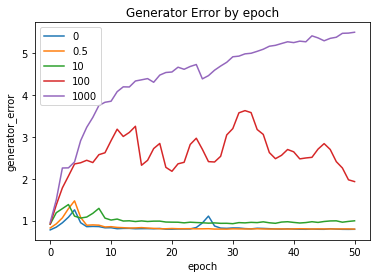

In [ ]:
# Generator
fig, ax = plt.subplots()

for i in l.keys():
    ax.plot(np.arange(0, EPOCHS+1), l[i]['gErr_history'])
ax.set(xlabel='epoch', ylabel='generator_error',
      title='Generator Error by epoch')
ax.legend(l.keys(), loc = 'upper left')
plt.show()

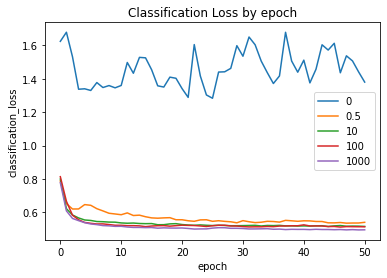

In [ ]:
# Classification
fig, ax = plt.subplots()

for i in l.keys():
    ax.plot(np.arange(0, EPOCHS+1), l[i]['closs_history'])
ax.set(xlabel='epoch', ylabel='classification_loss',
      title='Classification Loss by epoch')
ax.legend(l.keys(), loc = 'center right')
plt.show()

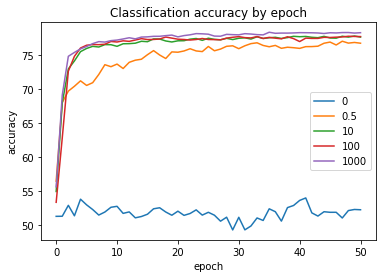

In [ ]:
# Accuracy
fig, ax = plt.subplots()

for i in l.keys():
    ax.plot(np.arange(0, EPOCHS+1), l[i]['accuracy_history'])
ax.set(xlabel='epoch', ylabel='accuracy',
      title='Classification accuracy by epoch')
ax.legend(l.keys(), loc = 'center right')
plt.show()

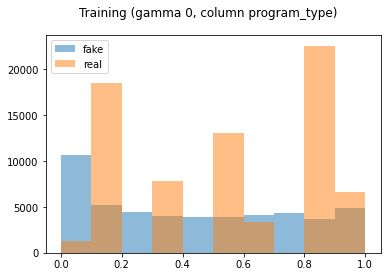

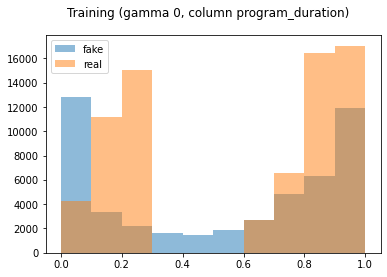

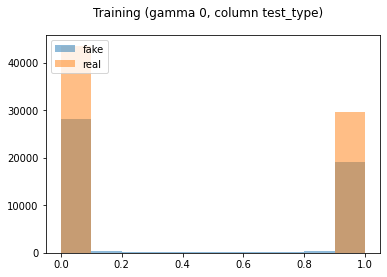

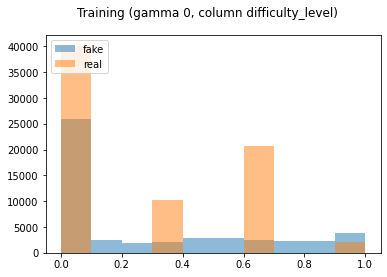

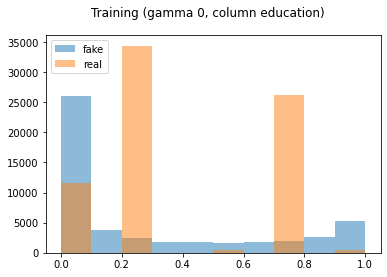

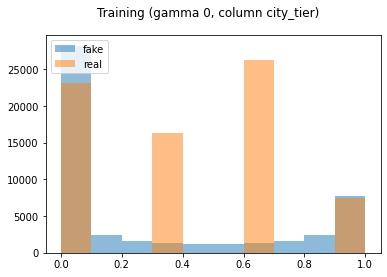

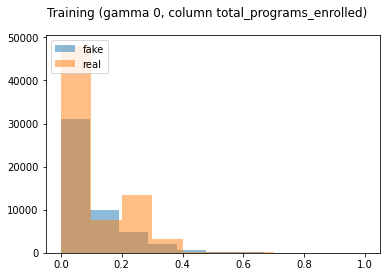

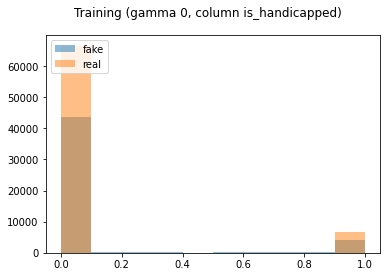

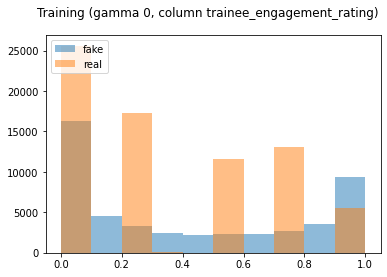

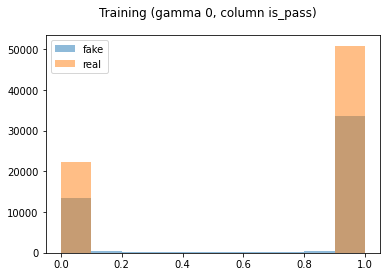

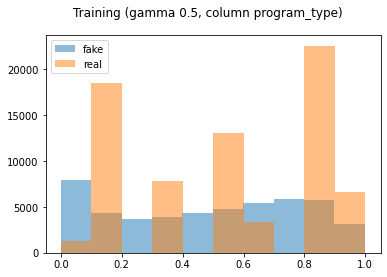

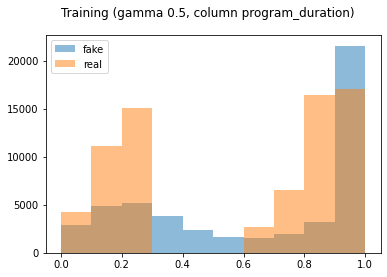

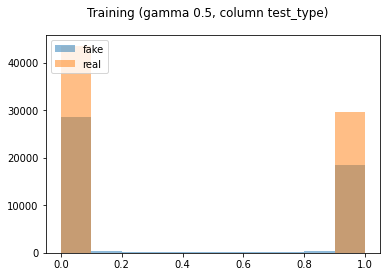

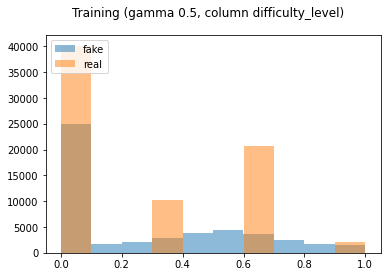

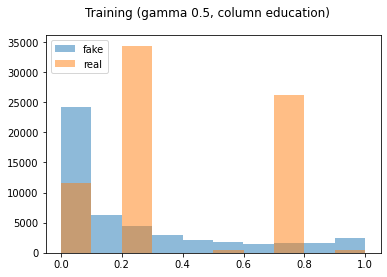

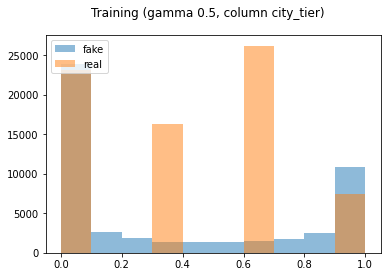

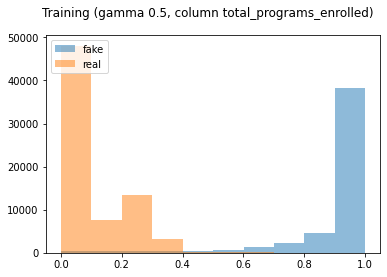

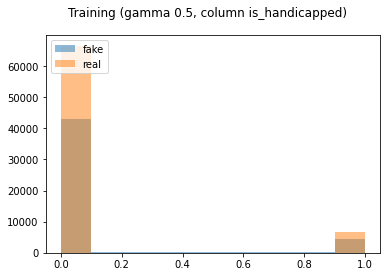

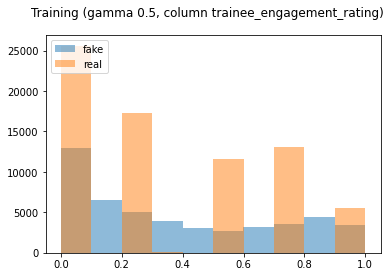

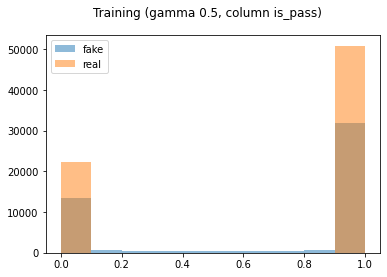

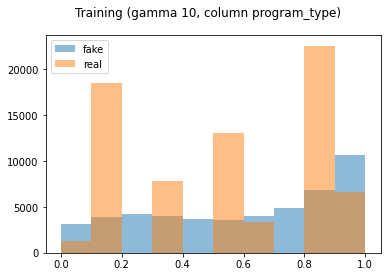

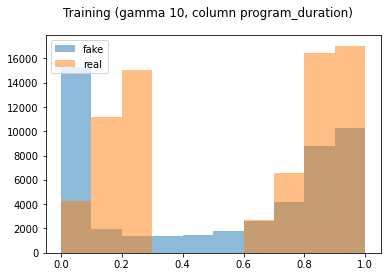

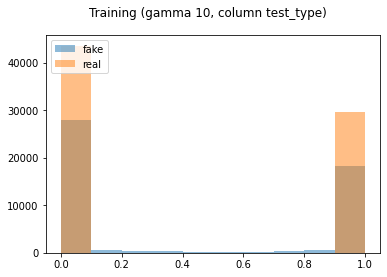

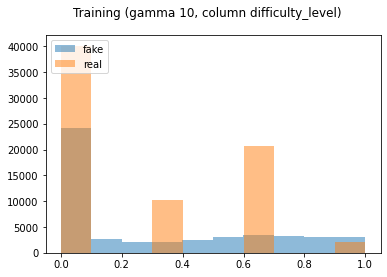

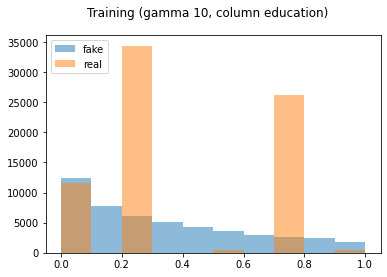

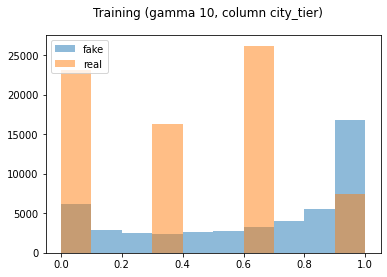

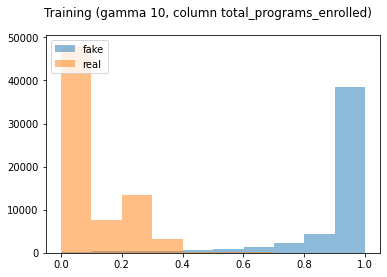

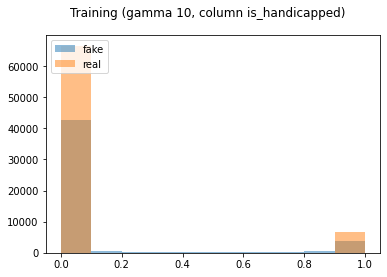

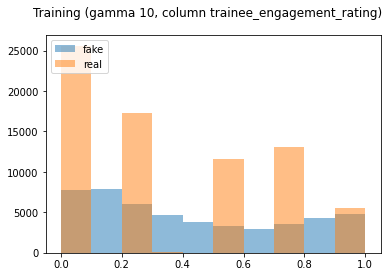

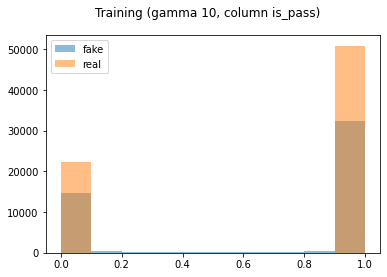

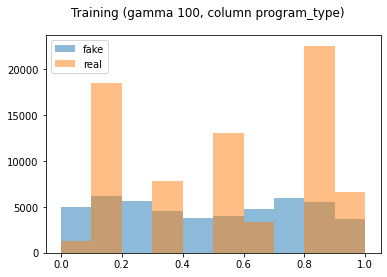

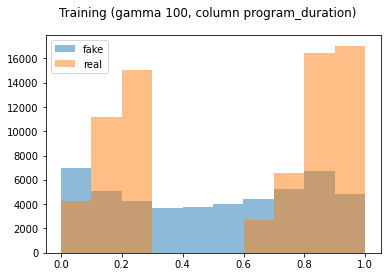

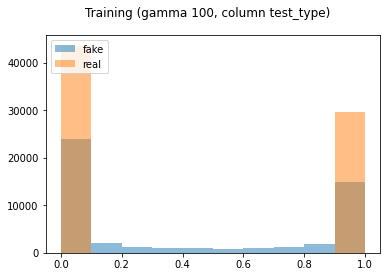

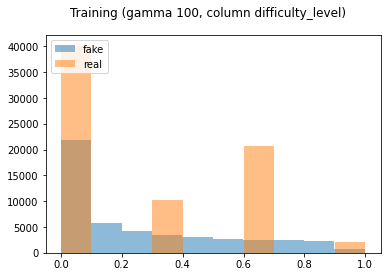

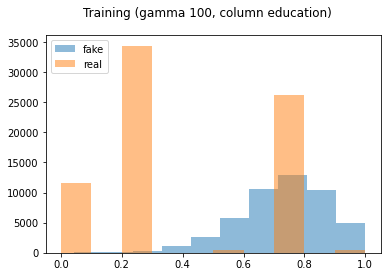

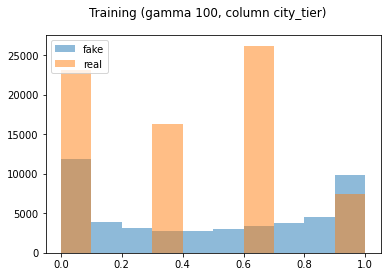

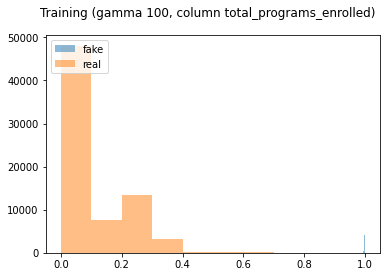

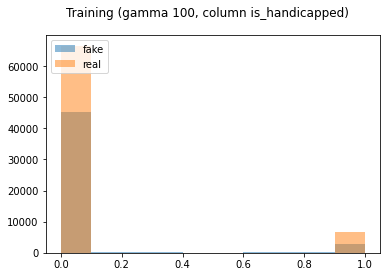

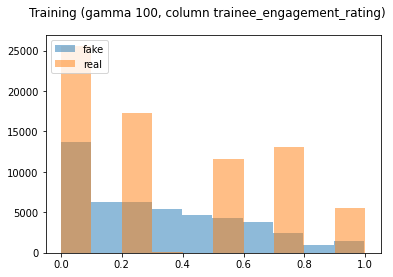

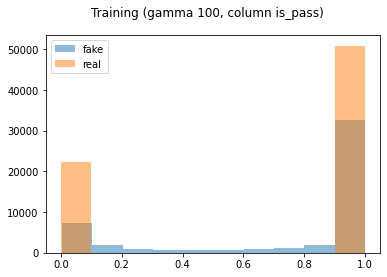

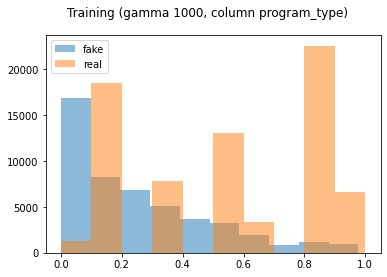

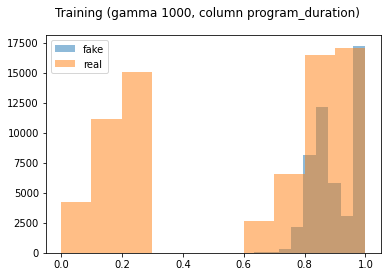

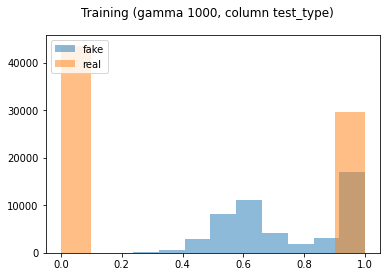

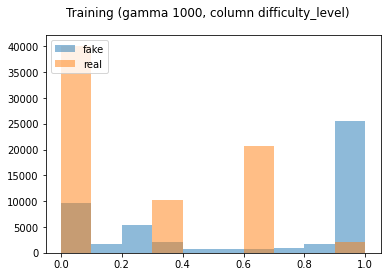

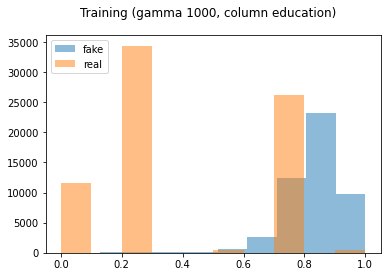

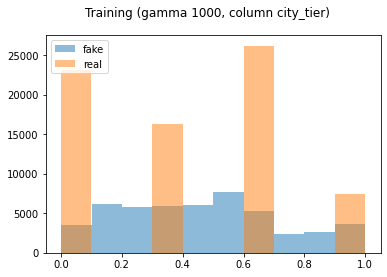

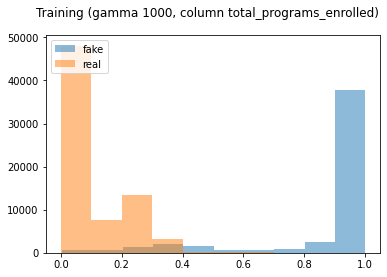

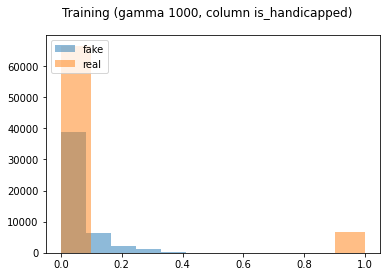

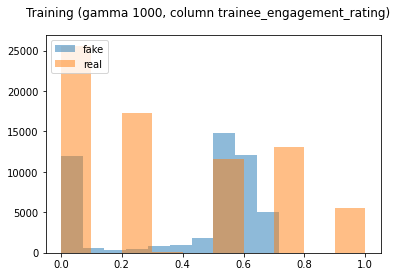

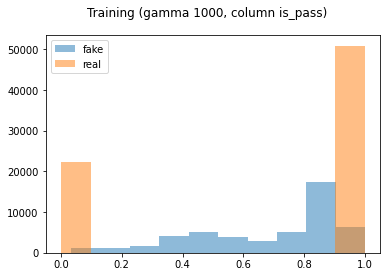

In [ ]:
for i in l.keys():

    for count, col in enumerate(new_df.columns[:-1]):
        fig, ax = plt.subplots()

        ax.hist(l[i]['fake_dataset_end'].iloc[:,count], 10, label = 'fake', alpha = 0.5)
        ax.hist(new_df.iloc[:,count], 10, label = 'real', alpha = 0.5)
        ax.legend(loc='upper left')

        fig.suptitle(f'Training (gamma {i}, column {col})')

        plt.show()